## 1. Check GPU Availability

In [69]:
import torch

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
DEVICE = None
if torch.cuda.is_available():
    DEVICE = "cuda"
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
else:
    DEVICE = "cpu"
    print("⚠️ No GPU detected! Go to Runtime → Change runtime type → GPU")

PyTorch version: 2.9.0+cu126
CUDA available: True
GPU: Tesla T4
GPU Memory: 15.8 GB


## 2. Mount Google Drive (for persistent storage)

In [70]:
import sys
import os

# Mount Google Drive for persistent storage
from google.colab import drive
drive.mount('/content/drive')

# Create project directory in Drive
BASE_DIR = "/content/drive/MyDrive/ML_Sentiment_Analysis"
os.makedirs(os.path.join(BASE_DIR, 'checkpoints'), exist_ok=True)
os.makedirs(os.path.join(BASE_DIR, 'results'), exist_ok=True)
os.makedirs(os.path.join(BASE_DIR, 'plots'), exist_ok=True)

print("✅ Google Drive mounted!")
print(f"📁 Base directory: {BASE_DIR}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive mounted!
📁 Base directory: /content/drive/MyDrive/ML_Sentiment_Analysis


## 3. Clone/Upload Project

In [71]:
import os

# ==================== CONFIGURE YOUR REPO HERE ====================
GITHUB_REPO = "https://github.com/R3dP4ndaXD/sentiment_analysis.git"
# ==================================================================

repo_name = "sentiment_analysis"
target_dir = f'/content/{repo_name}'

# Ensure we are in a stable directory before attempting to clone
# This helps avoid issues if the previous working directory was deleted
os.chdir('/content')

# Remove existing directory if it exists
if os.path.exists(target_dir):
    !rm -rf {target_dir}

# Clone from GitHub
!git clone {GITHUB_REPO} {target_dir}

# Change to project directory
os.chdir(target_dir)
print(f"✅ Cloned {GITHUB_REPO}")
print(f"📁 Working directory: {os.getcwd()}")

Cloning into '/content/sentiment_analysis'...
remote: Enumerating objects: 321, done.
remote: Counting objects: 100% (321/321), done.
remote: Compressing objects: 100% (214/214), done.
remote: Total 321 (delta 196), reused 216 (delta 92), pack-reused 0 (from 0)
Receiving objects: 100% (321/321), 2.08 MiB | 26.33 MiB/s, done.
Resolving deltas: 100% (196/196), done.
✅ Cloned https://github.com/R3dP4ndaXD/sentiment_analysis.git
📁 Working directory: /content/sentiment_analysis


In [72]:
# Verify project structure
!ls -la
print("\n📂 Source directory:")
!ls -la src/

total 48
drwxr-xr-x 8 root root 4096 Jan 11 16:51 .
drwxr-xr-x 1 root root 4096 Jan 11 16:51 ..
-rw-r--r-- 1 root root 6714 Jan 11 16:51 cerinta.md
drwxr-xr-x 4 root root 4096 Jan 11 16:51 data
drwxr-xr-x 8 root root 4096 Jan 11 16:51 .git
drwxr-xr-x 2 root root 4096 Jan 11 16:51 .github
-rw-r--r-- 1 root root  595 Jan 11 16:51 .gitignore
drwxr-xr-x 2 root root 4096 Jan 11 16:51 notebooks
-rw-r--r-- 1 root root  230 Jan 11 16:51 requirements.txt
drwxr-xr-x 9 root root 4096 Jan 11 16:51 results
drwxr-xr-x 8 root root 4096 Jan 11 16:51 src

📂 Source directory:
total 64
drwxr-xr-x 8 root root  4096 Jan 11 16:51 .
drwxr-xr-x 8 root root  4096 Jan 11 16:51 ..
-rw-r--r-- 1 root root  3687 Jan 11 16:51 config.py
drwxr-xr-x 2 root root  4096 Jan 11 16:51 data
drwxr-xr-x 2 root root  4096 Jan 11 16:51 embeddings
drwxr-xr-x 2 root root  4096 Jan 11 16:51 evaluate
drwxr-xr-x 2 root root  4096 Jan 11 16:51 models
drwxr-xr-x 2 root root  4096 Jan 11 16:51 preprocessing
-rw-r--r-- 1 root root 25235 

## 4. Install Dependencies

In [73]:
# Install from requirements.txt if exists
!pip install -q -r requirements.txt 2>/dev/null || echo "No requirements.txt found"

# Install core dependencies
!pip install -q torch pandas scikit-learn matplotlib seaborn spacy

# Download Romanian spaCy model
!python -m spacy download ro_core_news_sm -q

print("✅ Dependencies installed!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 127.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('ro_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
✅ Dependencies installed!


## 5. Download Dataset

In [74]:
import os
import pandas as pd

# Create data directories
os.makedirs('data/raw', exist_ok=True)
os.makedirs('data/processed', exist_ok=True)

# Download ro_sent dataset
TRAIN_URL = "https://raw.githubusercontent.com/dumitrescustefan/Romanian-Transformers/examples/examples/sentiment_analysis/ro/train.csv"
TEST_URL = "https://raw.githubusercontent.com/dumitrescustefan/Romanian-Transformers/examples/examples/sentiment_analysis/ro/test.csv"

!wget -q -O data/raw/train.csv "{TRAIN_URL}" 2>/dev/null || echo "Downloading train.csv..."
!wget -q -O data/raw/test.csv "{TEST_URL}" 2>/dev/null || echo "Downloading test.csv..."

# Check if download succeeded, if not try alternative method
if not os.path.exists('data/raw/train.csv') or os.path.getsize('data/raw/train.csv') < 1000:
    print("Trying alternative download method...")
    # Use datasets library as fallback
    !pip install -q datasets
    from datasets import load_dataset
    dataset = load_dataset("dumitrescustefan/ro_sent")
    dataset['train'].to_pandas().to_csv('data/raw/train.csv', index=False)
    dataset['test'].to_pandas().to_csv('data/raw/test.csv', index=False)

# Verify download
train_df = pd.read_csv('data/raw/train.csv')
test_df = pd.read_csv('data/raw/test.csv')
print(f"✅ Train samples: {len(train_df)}")
print(f"✅ Test samples: {len(test_df)}")
print(f"\nColumns: {train_df.columns.tolist()}")
print(f"\nLabel distribution (train):")
print(train_df['label'].value_counts())

✅ Train samples: 17941
✅ Test samples: 11005

Columns: ['index', 'text', 'label']

Label distribution (train):
label
1    11094
0     6847
Name: count, dtype: int64


In [75]:
# Create train/val/test split
from sklearn.model_selection import train_test_split

# Split train into train/val (85/15)
train_data, val_data = train_test_split(
    train_df,
    test_size=0.15,
    random_state=42,
    stratify=train_df['label']
)

# Save processed splits
DATA_DIR = "data/processed"
train_data.to_csv('data/processed/train.csv', index=False)
val_data.to_csv('data/processed/val.csv', index=False)
test_df.to_csv('data/processed/test.csv', index=False)

print(f"✅ Train: {len(train_data)} | Val: {len(val_data)} | Test: {len(test_df)}")

✅ Train: 15249 | Val: 2692 | Test: 11005


## 6. Run Experiments

Configure and run your training experiments below.

In [86]:
# Paths for persistent storage on Google Drive
CHECKPOINT_DIR = "/content/drive/MyDrive/ML_Sentiment_Analysis/checkpoints"
RESULTS_DIR = "/content/drive/MyDrive/ML_Sentiment_Analysis/results"
PLOTS_DIR = "/content/drive/MyDrive/ML_Sentiment_Analysis/plots"

# Create directories if they don't exist
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(PLOTS_DIR, exist_ok=True)

print(f"Checkpoint dir: {CHECKPOINT_DIR}")
print(f"Results dir: {RESULTS_DIR}")
print(f"Plots dir: {PLOTS_DIR}")

# ==================== EMBEDDINGS CONFIG ====================
# Download Romanian fastText embeddings (run once - ~4.5GB)
# !wget -q https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ro.300.bin.gz
# !gunzip cc.ro.300.bin.gz
# !mv cc.ro.300.bin /content/drive/MyDrive/ML_Sentiment_Analysis/

FASTTEXT_PATH = "/content/drive/MyDrive/ML_Sentiment_Analysis/cc.ro.300.bin"
FREEZE_EMBEDDINGS = False
# ============================================================


import os
import sys
from IPython import get_ipython

# Paths for persistent storage on Google Drive
CHECKPOINT_DIR = "/content/drive/MyDrive/ML_Sentiment_Analysis/checkpoints"
RESULTS_DIR = "/content/drive/MyDrive/ML_Sentiment_Analysis/results"
PLOTS_DIR = "/content/drive/MyDrive/ML_Sentiment_Analysis/plots"

# Create directories if they don't exist
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(PLOTS_DIR, exist_ok=True)

print(f"Checkpoint dir: {CHECKPOINT_DIR}")
print(f"Results dir: {RESULTS_DIR}")
print(f"Plots dir: {PLOTS_DIR}")

# ==================== EMBEDDINGS CONFIG ====================
# Download Romanian fastText embeddings (run once - ~4.5GB)
# !wget -q https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ro.300.bin.gz
# !gunzip cc.ro.300.bin.gz
# !mv cc.ro.300.bin /content/drive/MyDrive/ML_Sentiment_Analysis/

FASTTEXT_PATH = "/content/drive/MyDrive/ML_Sentiment_Analysis/cc.ro.300.bin"
FREEZE_EMBEDDINGS = False
# ============================================================

# ==================== CONFIG HELPER ====================
def run_experiment(base_params, specific_params):
    """Helper to run experiments with specific configurations."""
    config = base_params.copy()
    config.update(specific_params)

    # Auto-generate experiment name if not set
    if 'experiment_name' not in config:
        aug_type = config.get('augment', 'none')
        aug_suffix = "_noaug" if aug_type == 'none' else f"_{aug_type}"
        if aug_type != 'none':
            aug_prob = config.get('aug_prob', 0.5)
            aug_suffix += f"_p{aug_prob}"

        model = config['model']
        if 'bi' not in config.get('model') and config.get('bidirectional'):
            model += '_bi'

        expand_factor = config.get('expand_factor', 1.0)
        expand_suffix = "" if expand_factor == 1.0 else f"_exp{expand_factor}"

        hidden_dim = config.get('hidden_dim', 256)
        hidden_dim_suffix =  f"_hd{hidden_dim}"

        num_layers = config.get('num_layers', 2)
        num_layers_suffix =  f"_nl{num_layers}"

        dropout = config.get('dropout', 0.3)
        dropout_suffix =  f"_dr{dropout}"

        config['experiment_name'] = (
            f"{model}"
            f"{hidden_dim_suffix}"
            f"{num_layers_suffix}"
            f"{dropout_suffix}"
            f"{expand_suffix}"
            f"{aug_suffix}"
        )

    print(f"🚀 Starting Experiment: {config['experiment_name']}")

    # Build command string
    cmd_parts = ["python -m src.run_experiment"]
    for k, v in config.items():
        if isinstance(v, bool):
            if v: cmd_parts.append(f"--{k}")
        else:
            cmd_parts.append(f"--{k} {v}")

    cmd = " ".join(cmd_parts)
    print(f"Executing: {cmd}\n")

    # Execute using IPython magic for real-time output
    get_ipython().system(cmd)

# Base Configuration Map
BASE_CONFIG = {
    'model': 'bilstm_attention',
    'embedding_dim': 300,
    'hidden_dim': 128,
    'num_layers': 2,
    'dropout': 0.5,
    'pooling': 'max',
    'epochs': 30,
    'batch_size': 64,
    'lr': 0.0005,
    'weight_decay': 1e-3,
    'optimizer': 'adamw',
    'scheduler': 'plateau',
    'gradient_clip': 1.0,
    'max_seq_len': 160,
    'min_freq': 2,
    'max_vocab_size': 50000,
    'pretrained_embeddings': FASTTEXT_PATH,
    'early_stopping': 5,
    'checkpoint_metric': 'val_f1',
    'device': DEVICE,
    'data_dir': DATA_DIR,
    'checkpoint_dir': CHECKPOINT_DIR,
    'plots_dir': PLOTS_DIR,
    'results_dir': RESULTS_DIR,
    'remove_stopwords': False,
    'weighted_sampler': True, #
    'balance_classes': False,
    'expand_factor': 1.0,
    'bidirectional': True,
    'num_workers': 2,
    'freeze_embeddings': True
}
    #--resume {PATH}
    #--evaluate_only /
    #--checkpoint {PATH} \
    #--verbose \
    #--no_plots \

Checkpoint dir: /content/drive/MyDrive/ML_Sentiment_Analysis/checkpoints
Results dir: /content/drive/MyDrive/ML_Sentiment_Analysis/results
Plots dir: /content/drive/MyDrive/ML_Sentiment_Analysis/plots
Checkpoint dir: /content/drive/MyDrive/ML_Sentiment_Analysis/checkpoints
Results dir: /content/drive/MyDrive/ML_Sentiment_Analysis/results
Plots dir: /content/drive/MyDrive/ML_Sentiment_Analysis/plots


No aug


In [85]:
# No Augmentation Experiment
no_aug_params = {
    # 'experiment_name': 'simple_rnn_bi_hd128_nl2_finetune_noaug',
    # 'resume': '/content/drive/MyDrive/ML_Sentiment_Analysis/checkpoints/simple_rnn_bi_hd128_nl1_noaug/best_val_f1.pt',
    # 'lr': 5e-5,
    # 'epochs': 10,
    # 'dropout': 0.3,
    'augment': 'none',
    'num_workers': 8,
}

run_experiment(BASE_CONFIG, no_aug_params)


🚀 Starting Experiment: simple_rnn_bi_hd128_nl2_dr0.3_noaug
Executing: python -m src.run_experiment --model simple_rnn --embedding_dim 300 --hidden_dim 128 --num_layers 2 --dropout 0.3 --pooling max --epochs 30 --batch_size 64 --lr 0.0005 --weight_decay 0.001 --optimizer adamw --scheduler plateau --gradient_clip 1.0 --max_seq_len 160 --min_freq 2 --max_vocab_size 50000 --pretrained_embeddings /content/drive/MyDrive/ML_Sentiment_Analysis/cc.ro.300.bin --early_stopping 5 --checkpoint_metric val_f1 --device cuda --data_dir data/processed --checkpoint_dir /content/drive/MyDrive/ML_Sentiment_Analysis/checkpoints --plots_dir /content/drive/MyDrive/ML_Sentiment_Analysis/plots --results_dir /content/drive/MyDrive/ML_Sentiment_Analysis/results --weighted_sampler --expand_factor 1.0 --bidirectional --num_workers 8 --freeze_embeddings --augment none --experiment_name simple_rnn_bi_hd128_nl2_dr0.3_noaug

2026-01-11 18:27:32.477584: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unab

Aug



In [88]:
# Augmentation Experiment
BALANCED_DATA_DIR = '/content/drive/MyDrive/ML_Sentiment_Analysis/data/balanced/'

aug_params = {
    'experiment_name': 'bilstm_attention_hd128_nl2_dr0.5_resume_eda_plus_p0.1',
    'resume': '/content/drive/MyDrive/ML_Sentiment_Analysis/checkpoints/bilstm_attention_hd128_nl2_dr0.5_eda_plus_p0.1/best_val_f1.pt',
    'lr': 1e-5,
    'epochs': 10,
    'weighted_sampler': False,
    'augment': 'eda_plus',
    'aug_prob': 0.1,
    'aug_mode': 'one_of',
    'data_dir': BALANCED_DATA_DIR,
    'num_workers': 0  # Lower workers for complex augmentation
}
run_experiment(BASE_CONFIG, aug_params)

🚀 Starting Experiment: bilstm_attention_hd128_nl2_dr0.5_eda_plus_p0.1
Executing: python -m src.run_experiment --model bilstm_attention --embedding_dim 300 --hidden_dim 128 --num_layers 2 --dropout 0.5 --pooling max --epochs 30 --batch_size 64 --lr 0.0005 --weight_decay 0.001 --optimizer adamw --scheduler plateau --gradient_clip 1.0 --max_seq_len 160 --min_freq 2 --max_vocab_size 50000 --pretrained_embeddings /content/drive/MyDrive/ML_Sentiment_Analysis/cc.ro.300.bin --early_stopping 5 --checkpoint_metric val_f1 --device cuda --data_dir /content/drive/MyDrive/ML_Sentiment_Analysis/data/balanced/ --checkpoint_dir /content/drive/MyDrive/ML_Sentiment_Analysis/checkpoints --plots_dir /content/drive/MyDrive/ML_Sentiment_Analysis/plots --results_dir /content/drive/MyDrive/ML_Sentiment_Analysis/results --expand_factor 1.0 --bidirectional --num_workers 0 --freeze_embeddings --augment eda_plus --aug_prob 0.1 --aug_mode one_of --experiment_name bilstm_attention_hd128_nl2_dr0.5_eda_plus_p0.1

2026

## 7. View Results

In [89]:
import json
import pandas as pd
from pathlib import Path

# Load all experiment summaries
results_dir = Path(RESULTS_DIR)
summaries = []

if results_dir.exists():
    for exp_dir in results_dir.iterdir():
        if exp_dir.is_dir():
            summary_file = exp_dir / 'summary.json'
            if summary_file.exists():
                with open(summary_file) as f:
                    summary = json.load(f)
                    summary['experiment'] = exp_dir.name
                    summaries.append(summary)

if summaries:
    df = pd.DataFrame(summaries)
    print("\n" + "="*60)
    print("EXPERIMENT RESULTS SUMMARY")
    print("="*60)
    display(df[['experiment', 'model', 'best_val_f1', 'best_val_acc', 'epochs_trained']].sort_values('best_val_f1', ascending=False))
else:
    print("No results found yet. Run experiments first!")


EXPERIMENT RESULTS SUMMARY


experiment             model  \
19          simple_rnn_bi_hd128_nl1_finetune_noaug        simple_rnn   
15    bilstm_attention_1layer_128hid_eda_plus_p0.1  bilstm_attention   
11                  bilstm_attention_eda_plus_p0.3  bilstm_attention   
24  bilstm_attention_hd128_nl2_dr0.5_eda_plus_p0.1  bilstm_attention   
13                 lstm_batchnorm_bi_eda_plus_p0.3    lstm_batchnorm   
0                          lstm_batchnorm_bi_noaug    lstm_batchnorm   
14        bilstm_attention_1layer_128hid_noaug_old  bilstm_attention   
7                           bilstm_attention_noaug  bilstm_attention   
2                    stacked_lstm_bi_eda_plus_p0.3      stacked_lstm   
22                bilstm_attention_hd128_nl2_noaug  bilstm_attention   
10                           stacked_lstm_bi_noaug      stacked_lstm   
8                              simple_rnn_bi_noaug        simple_rnn   
12                    stacked_rnn_bi_eda_plus_p0.3       stacked_rnn   
3                            lstm_bi_eda_plus_p0.3              lstm   
5                                    lstm_bi_noaug              lstm   
4                      simple_rnn_bi_eda_plus_p0.3        simple_rnn   
9                           simple_rnn_bi_eda_p0.3        simple_rnn   
21                         lstm_bi_hd128_nl2_noaug              lstm   
6                             stacked_rnn_bi_noaug       stacked_rnn   
1                                 simple_rnn_noaug        simple_rnn   
17                   simple_rnn_bi_hd128_nl1_noaug        simple_rnn   
20                   simple_rnn_bi_hd128_nl2_noaug        simple_rnn   
23             simple_rnn_bi_hd128_nl2_dr0.3_noaug        simple_rnn   
16                     lstm_bi_hd128_nl1_noaug_old              lstm   
18                bilstm_attention_hd128_nl1_noaug  bilstm_attention   

    best_val_f1  best_val_acc  epochs_trained  
19     0.913699      0.891994              28  
15     0.912674      0.891616              16  
11     0.912357      0.893127              14  
24     0.912228      0.890483              29  
13     0.912010      0.892372              10  
0      0.911469      0.890106              20  
14     0.911315      0.890483              16  
7      0.911097      0.890483              11  
2      0.910879      0.889728               9  
22     0.910332      0.890861              30  
10     0.908649      0.887840              13  
8      0.908592      0.886707              14  
12     0.908427      0.886707              15  
3      0.908305      0.887840              10  
5      0.908081      0.887462              20  
4      0.907946      0.884063              15  
9      0.907806      0.886707              12  
21     0.906949      0.883686              25  
6      0.905751      0.882553              11  
1      0.905660      0.882931              19  
17     0.895623      0.871224              25  
20     0.890625      0.865181              18  
23     0.884472      0.859517              11  
16     0.767137      0.649547              12  
18     0.761459      0.618580               6


📊 bilstm_attention_1layer_128hid_eda_plus_p0.1
----------------------------------------

confusion_matrix.png:


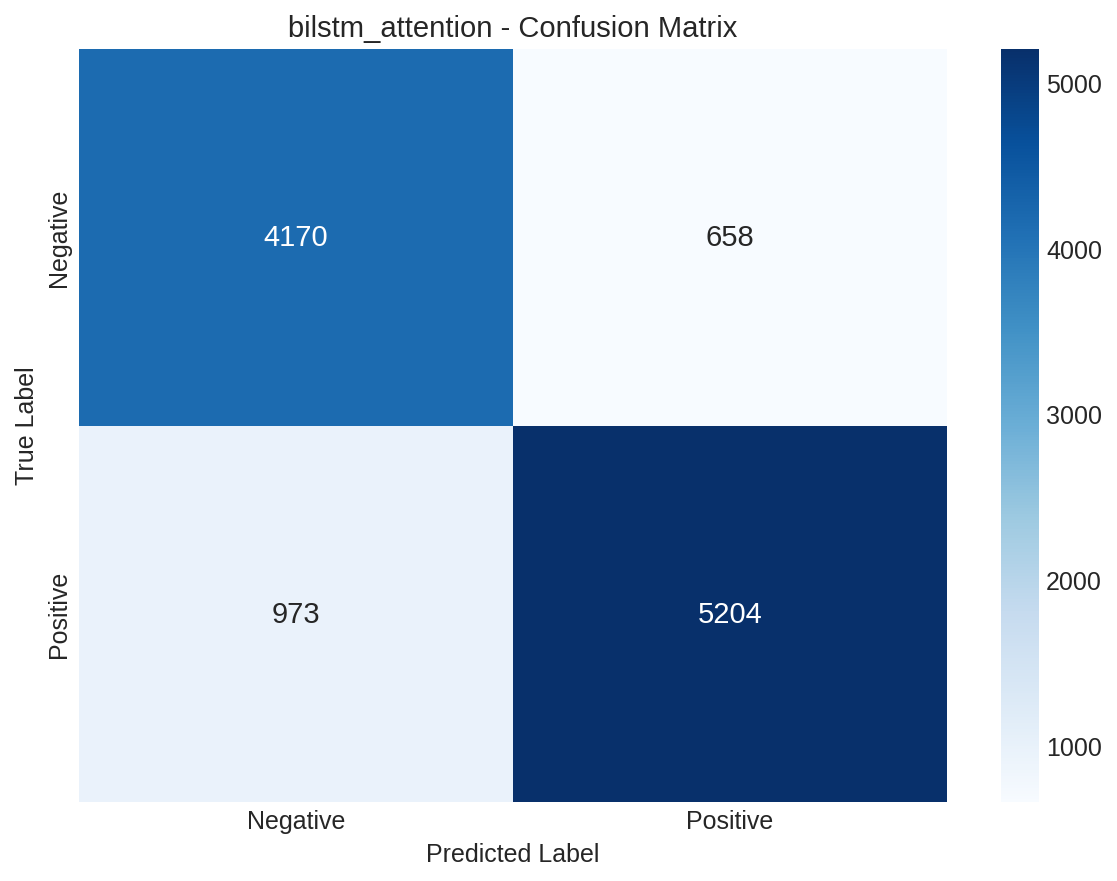


confusion_matrix_normalized.png:


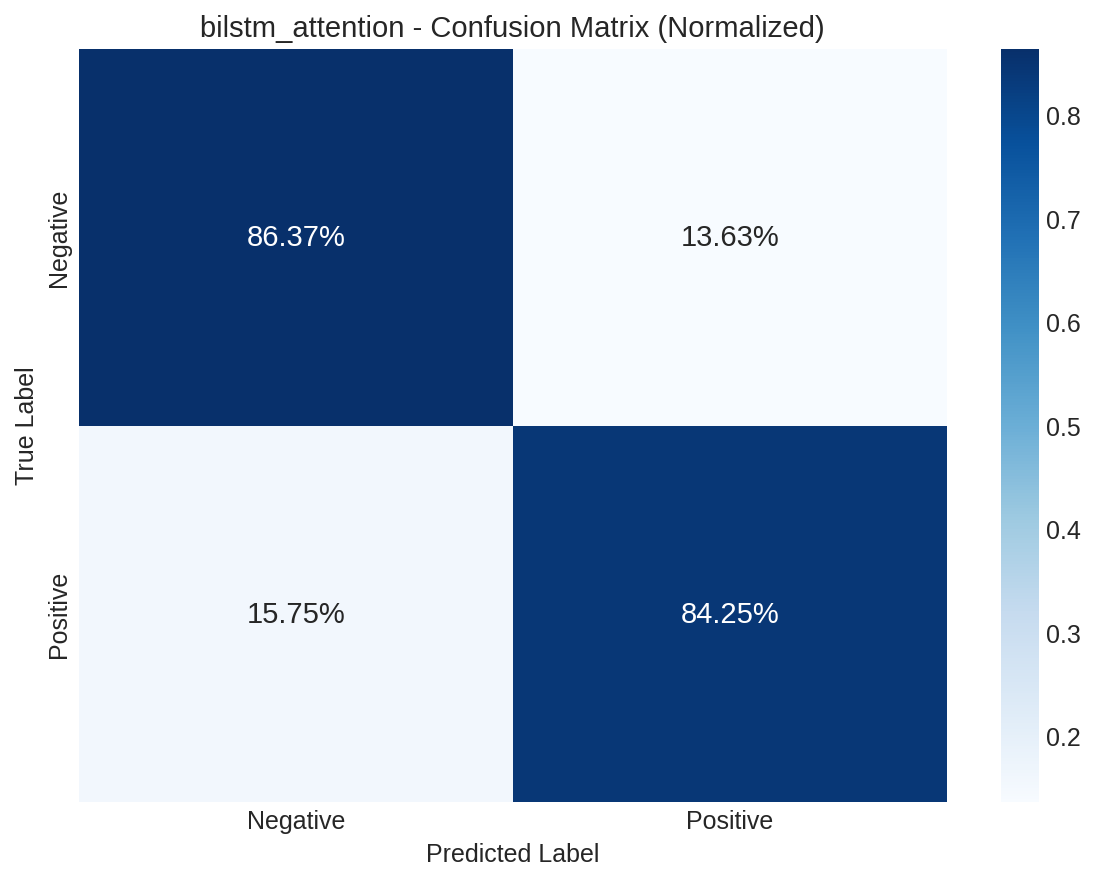


loss_curves.png:


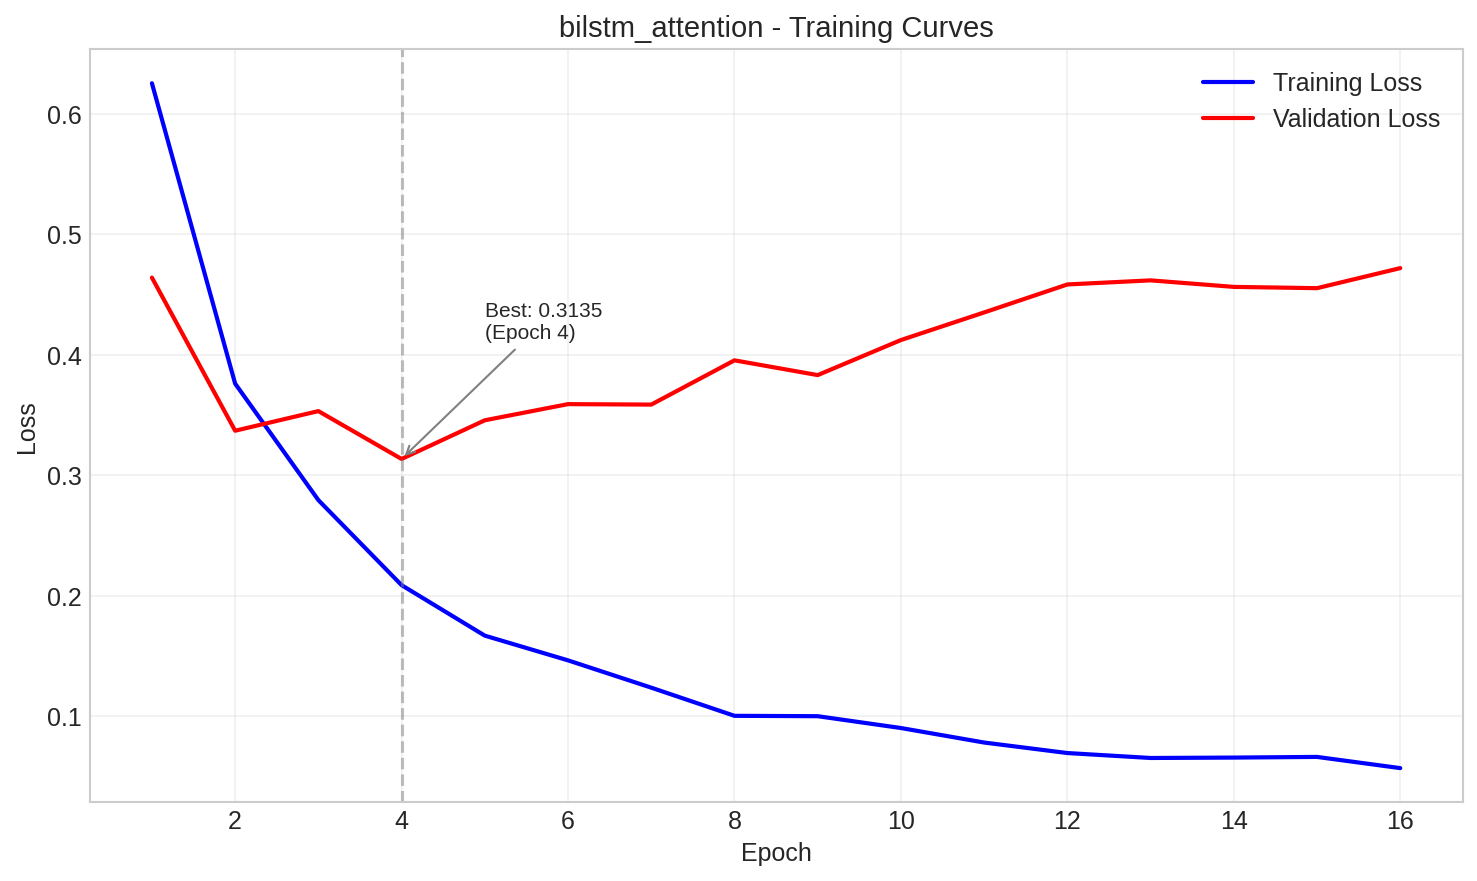


metrics_curves.png:


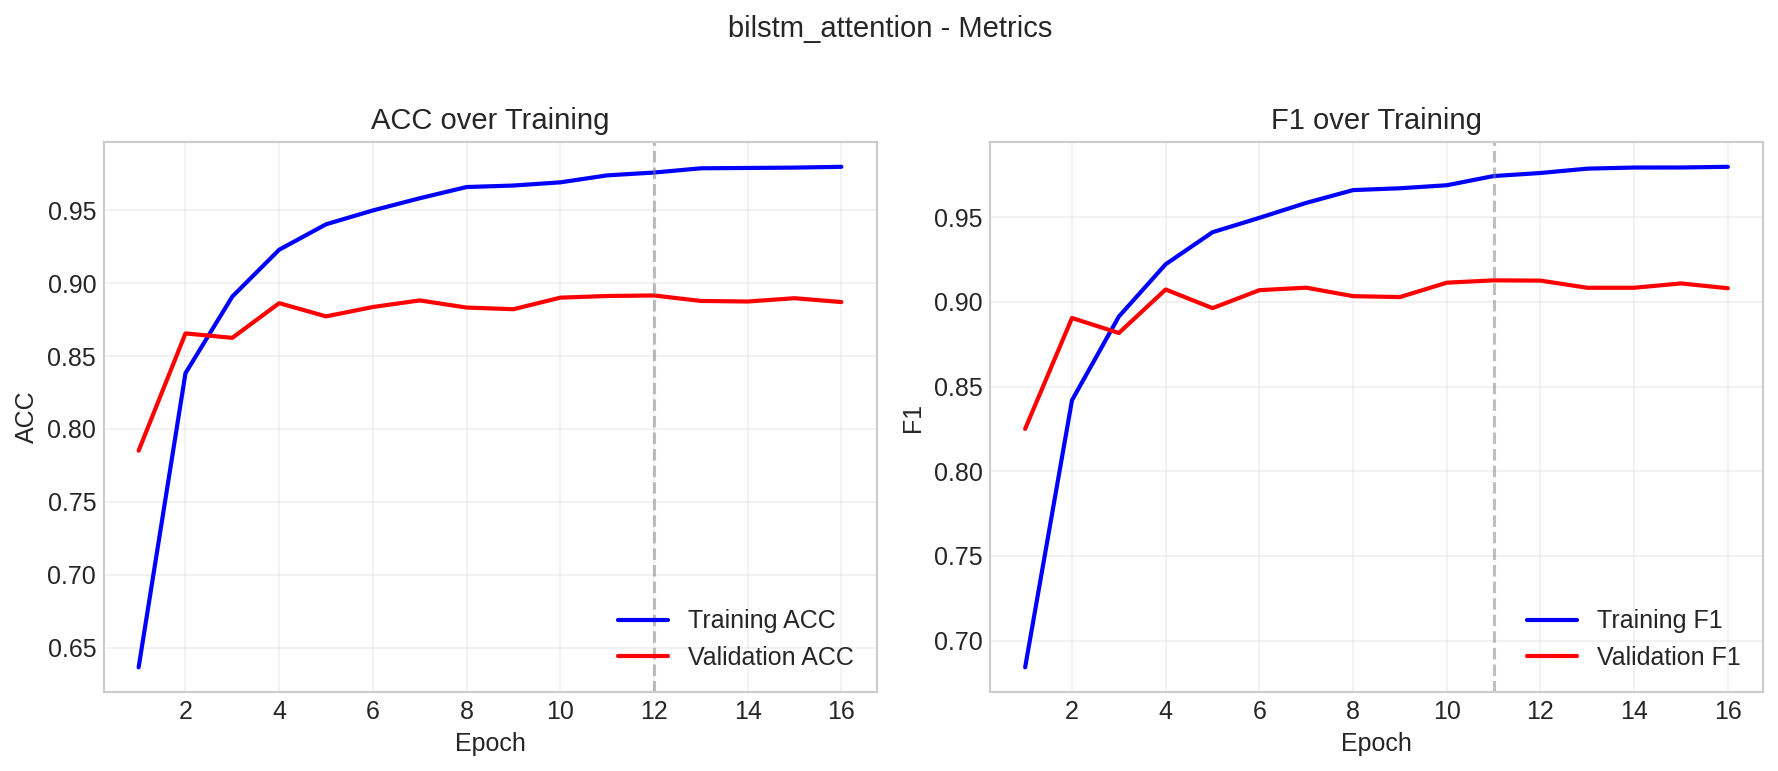


📊 bilstm_attention_1layer_128hid_noaug_old
----------------------------------------

confusion_matrix.png:


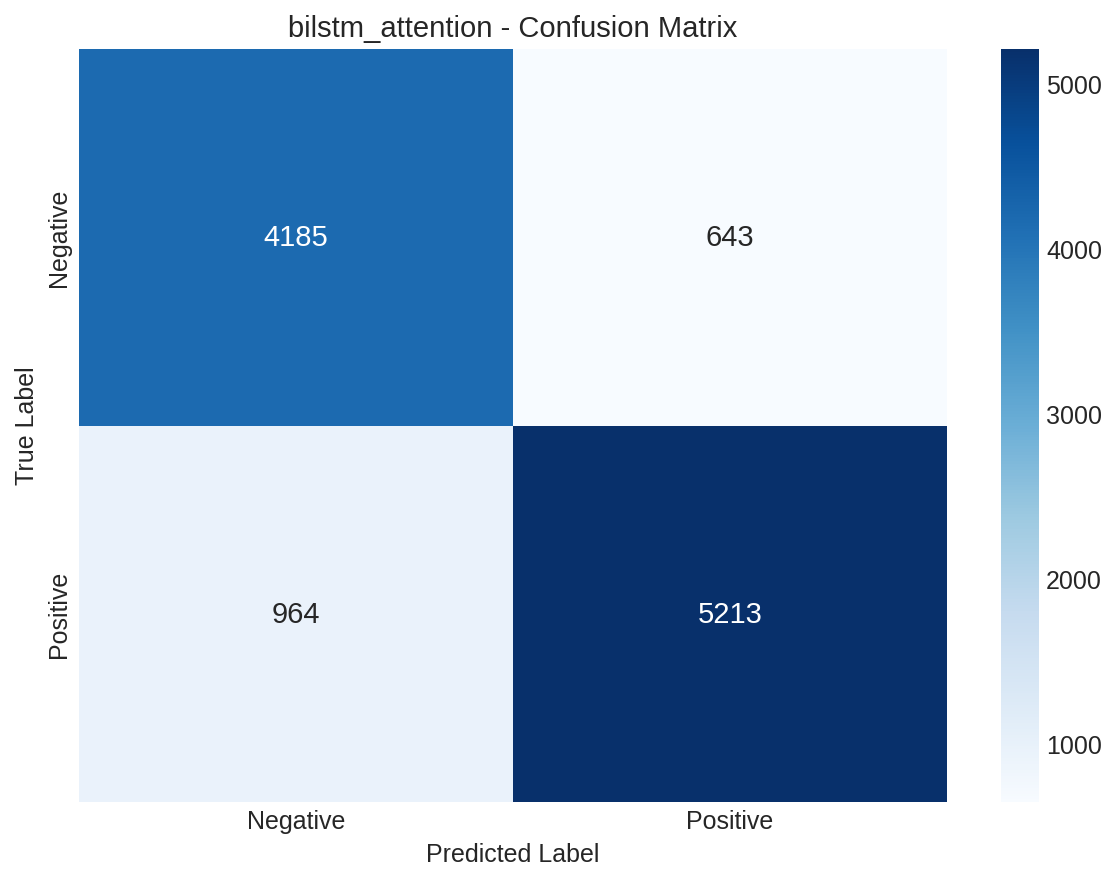


confusion_matrix_normalized.png:


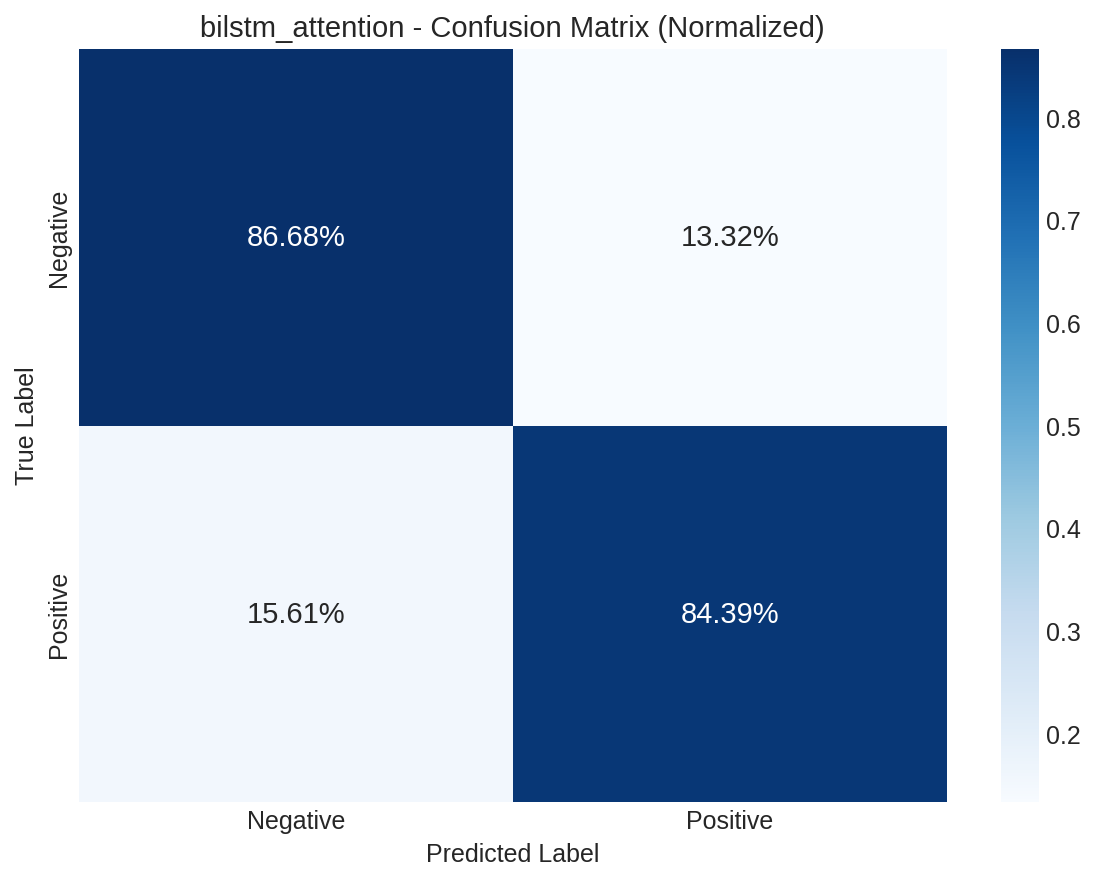


loss_curves.png:


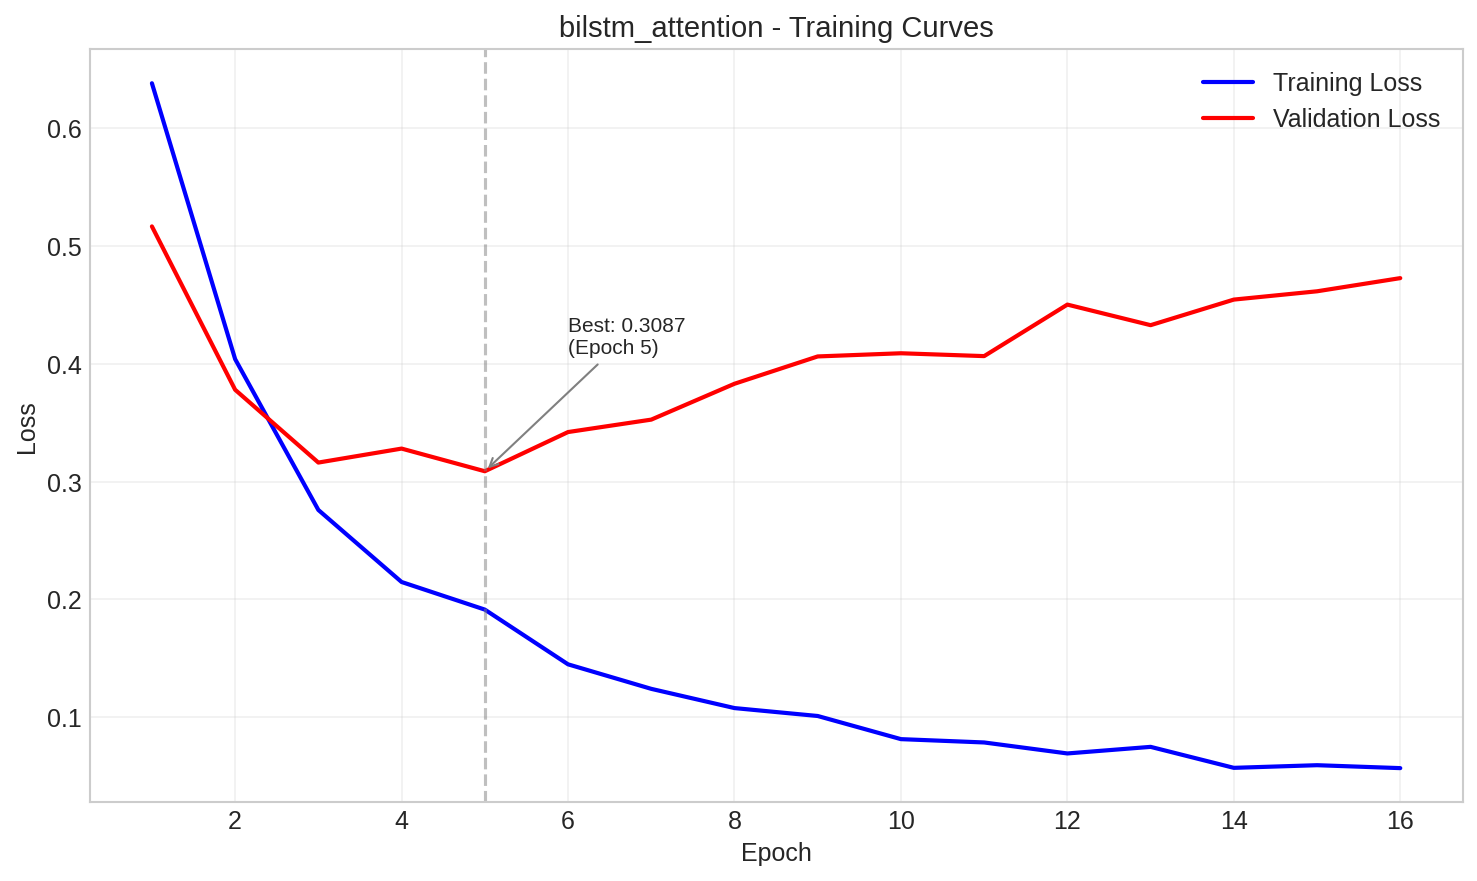


metrics_curves.png:


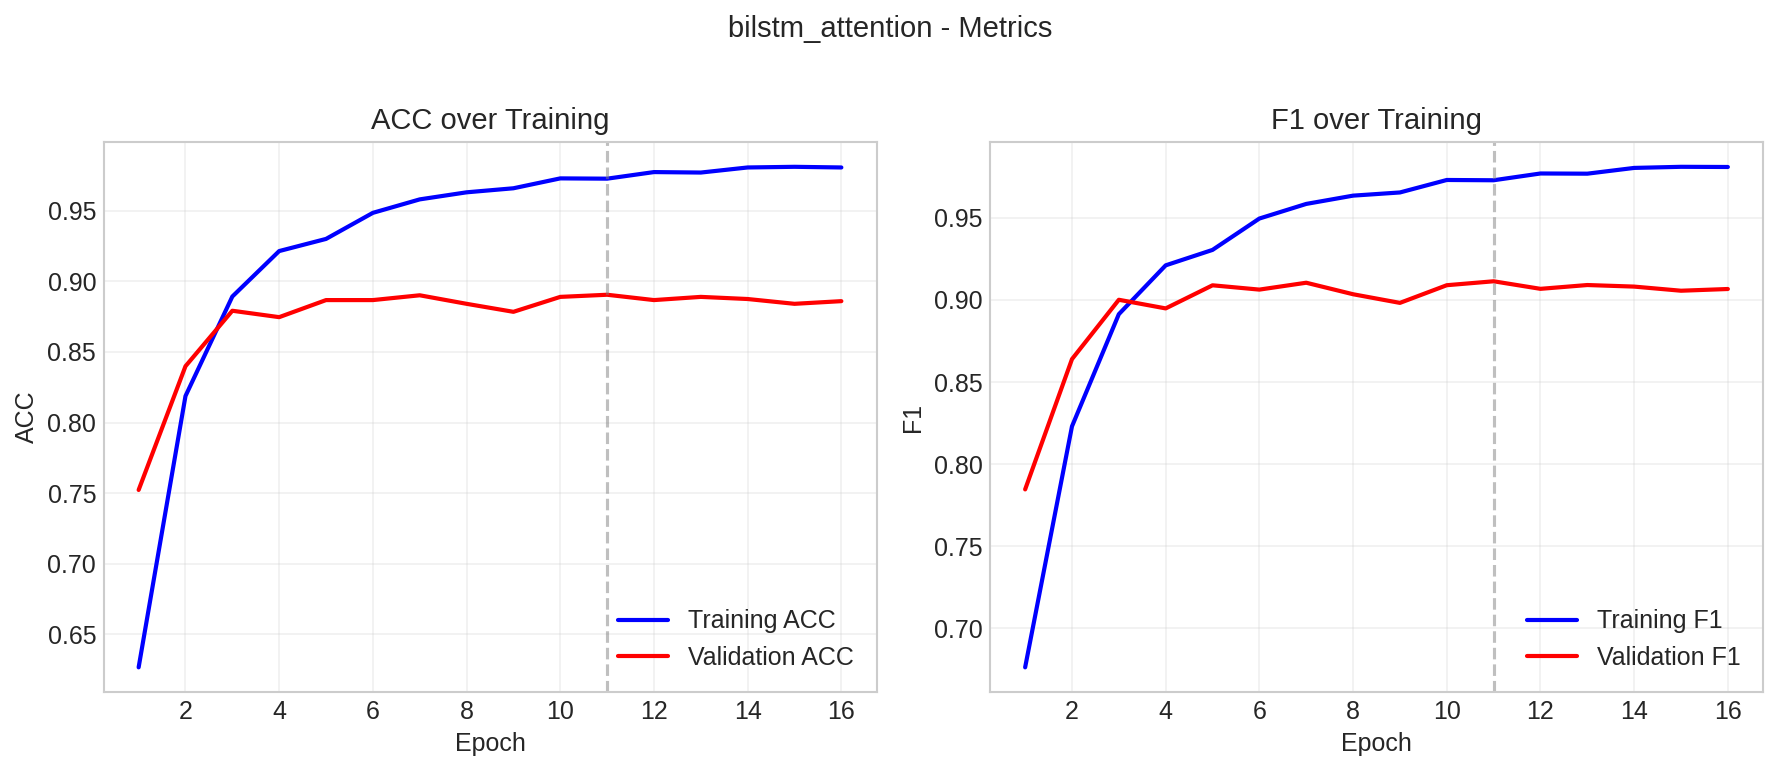


📊 bilstm_attention_eda_plus_p0.3
----------------------------------------

confusion_matrix.png:


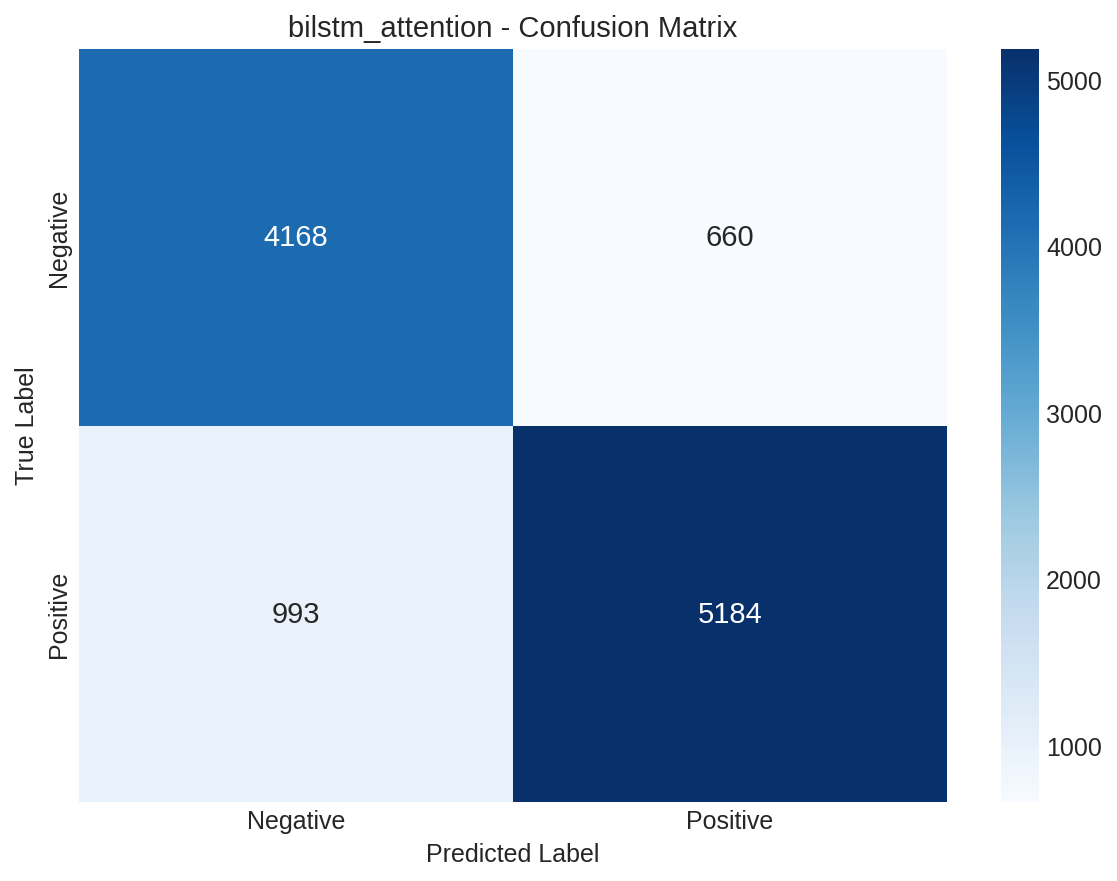


confusion_matrix_normalized.png:


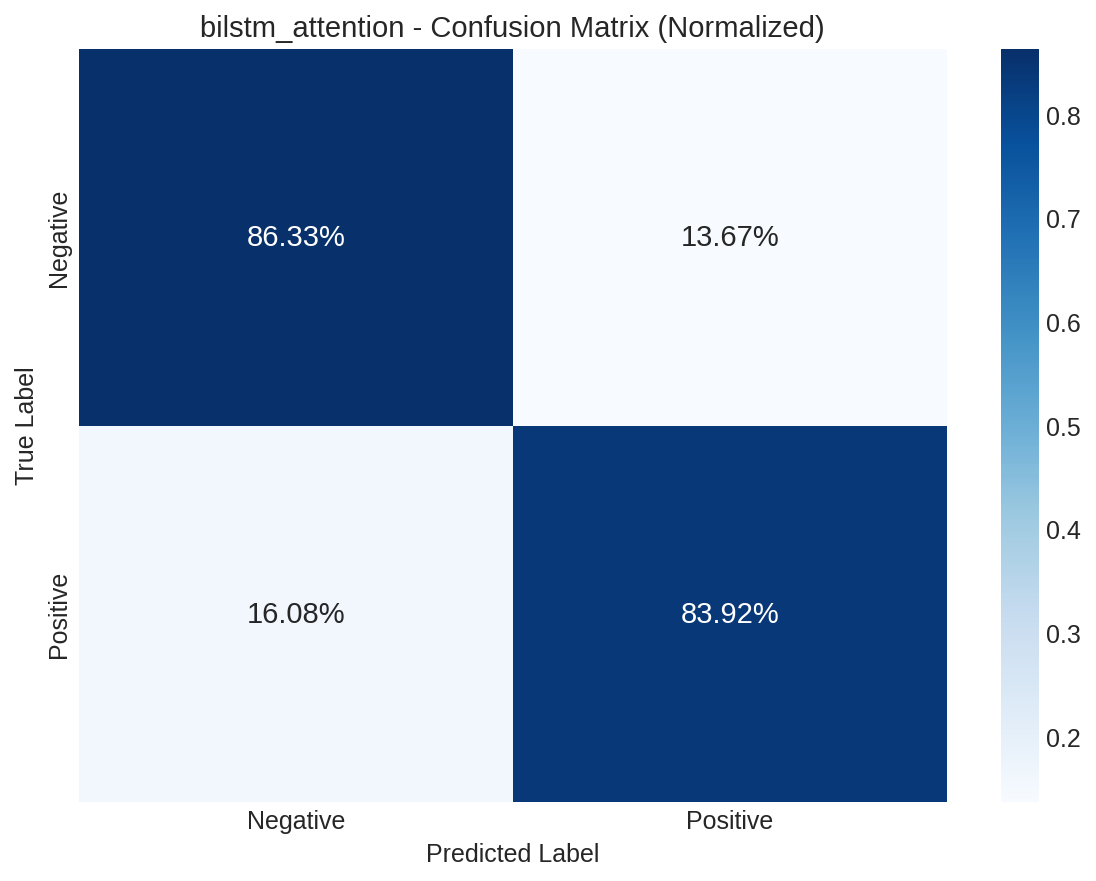


loss_curves.png:


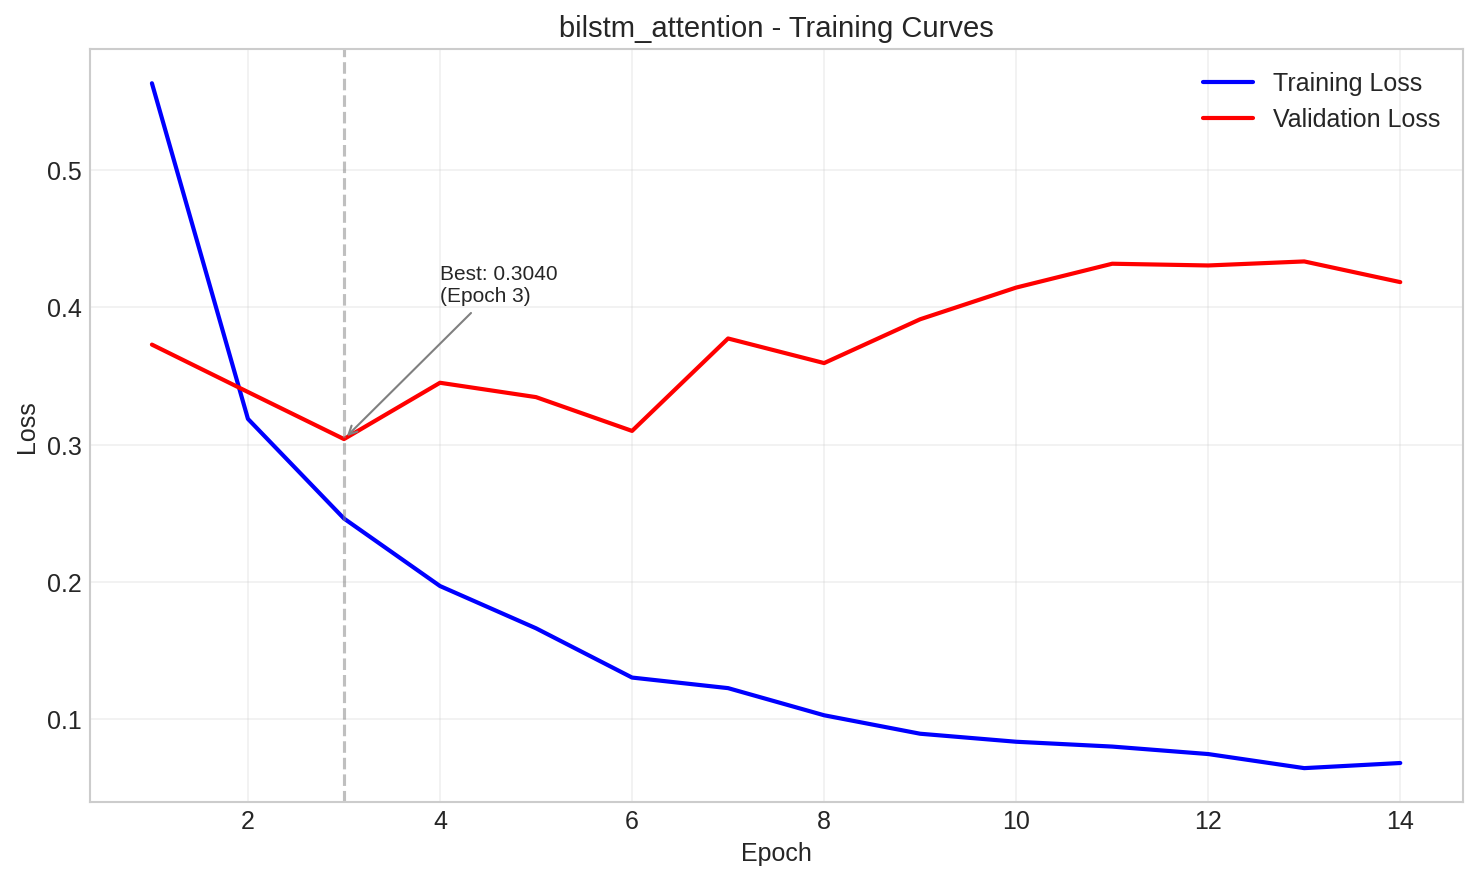


metrics_curves.png:


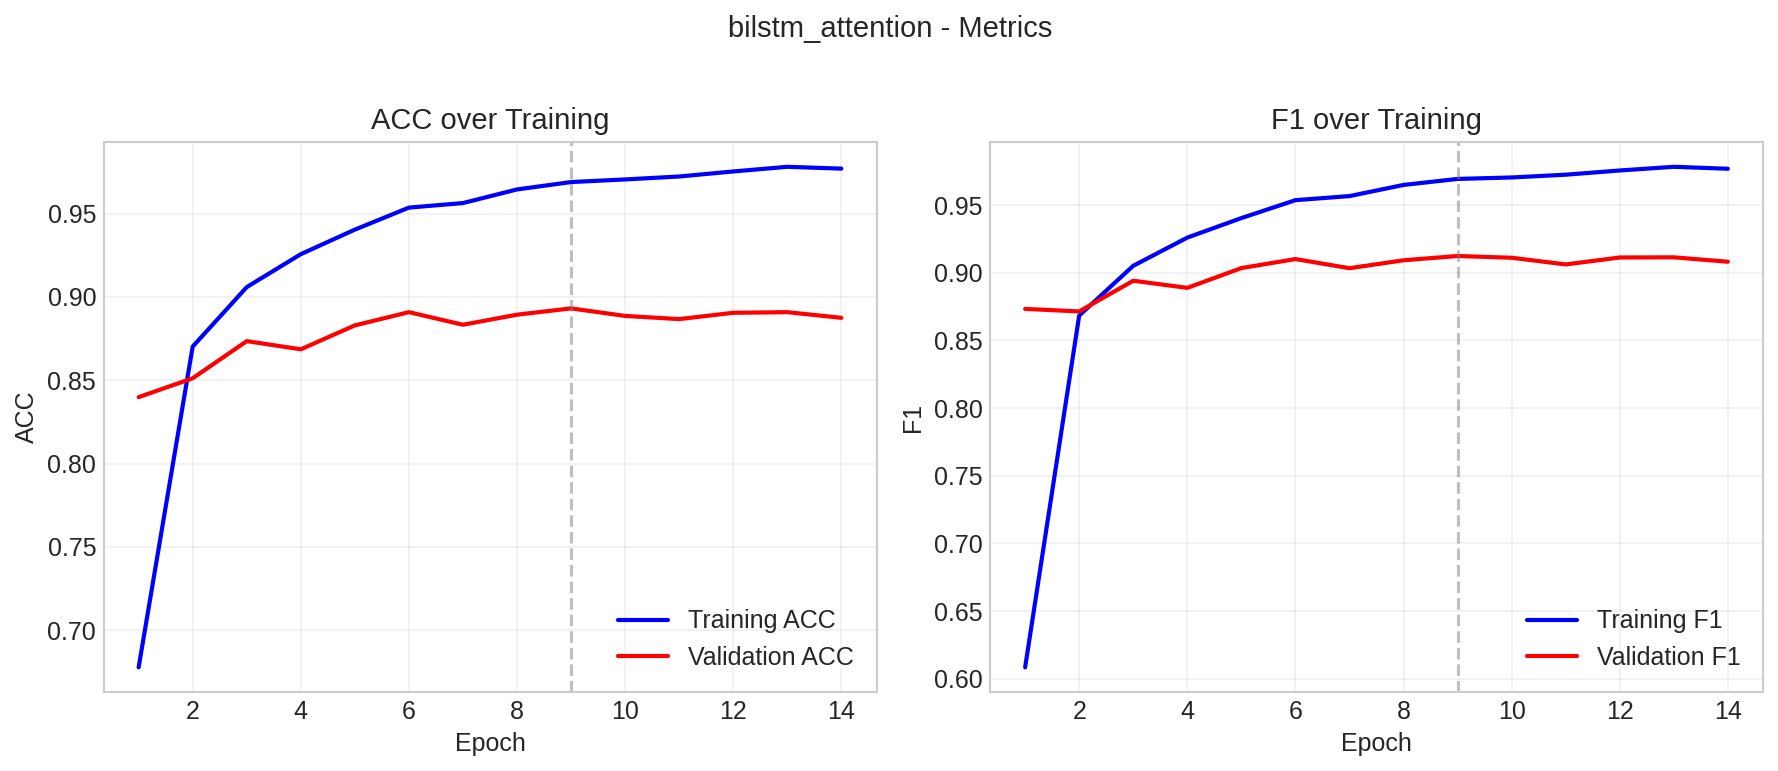


📊 bilstm_attention_hd128_nl1_noaug
----------------------------------------

confusion_matrix.png:


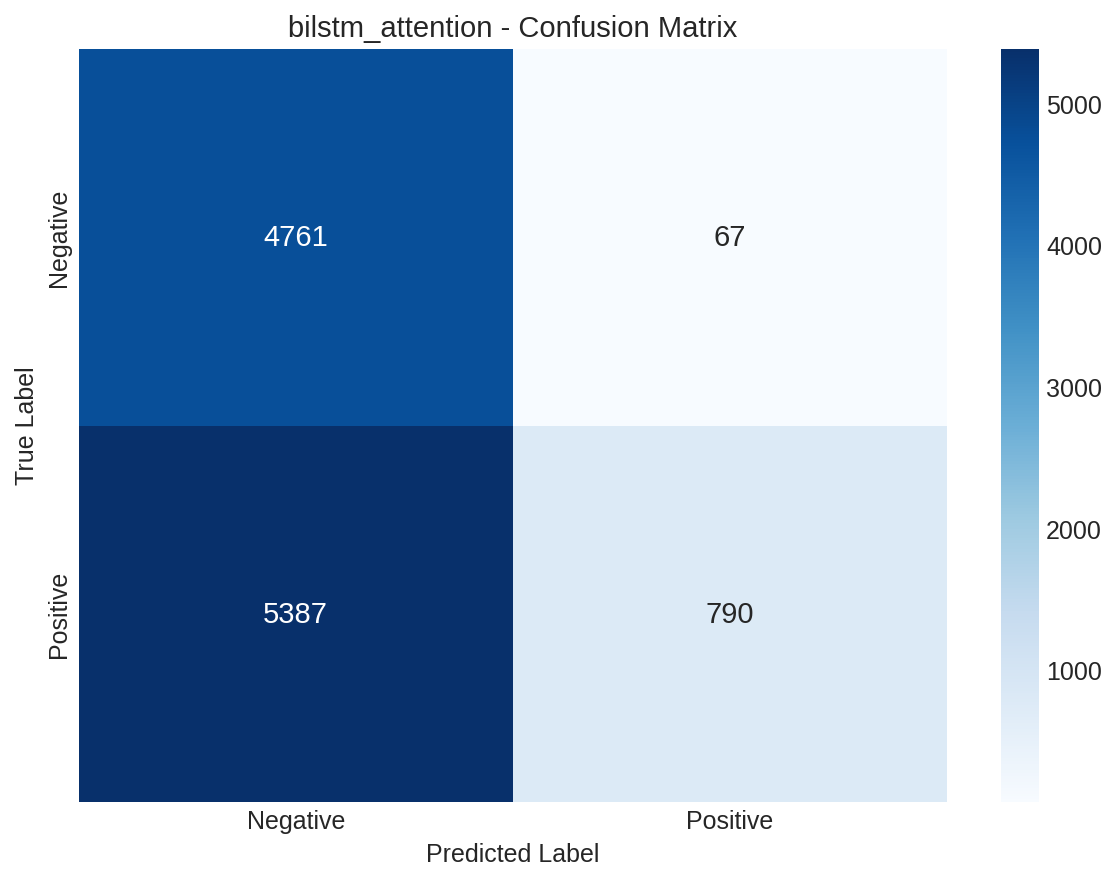


confusion_matrix_normalized.png:


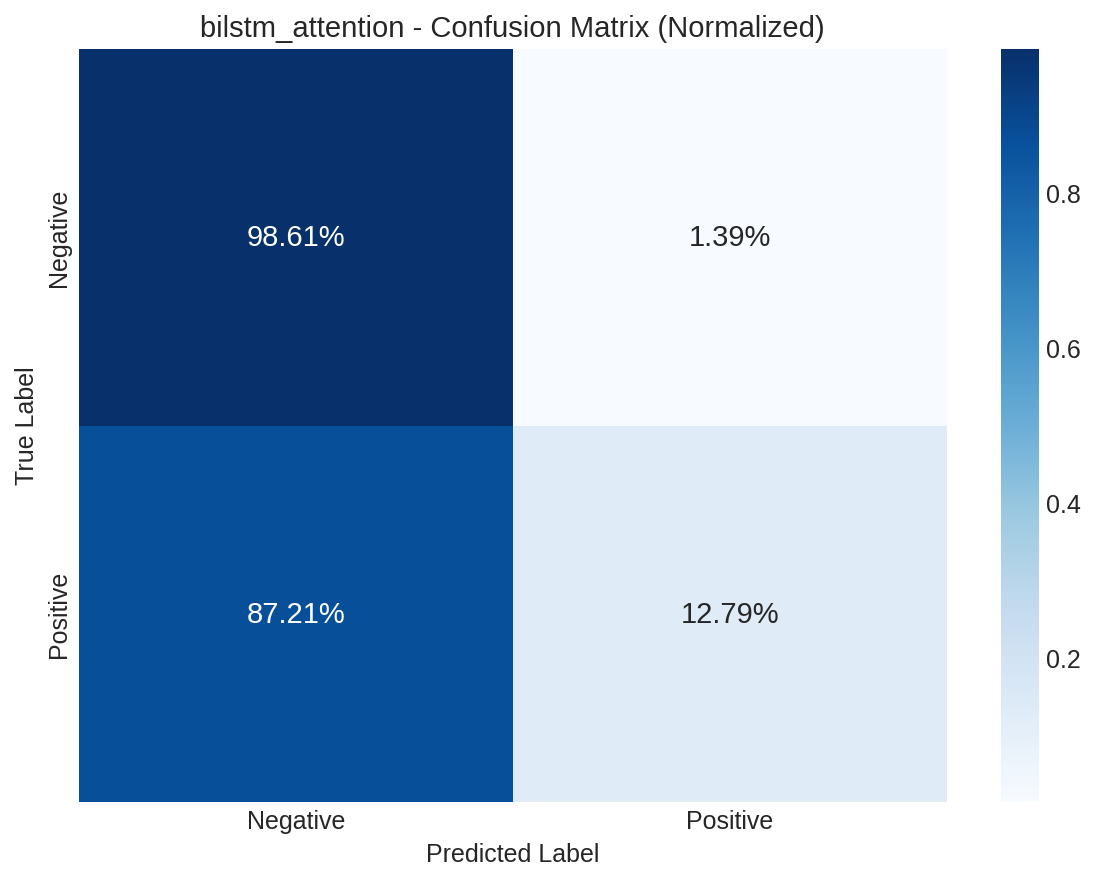


loss_curves.png:


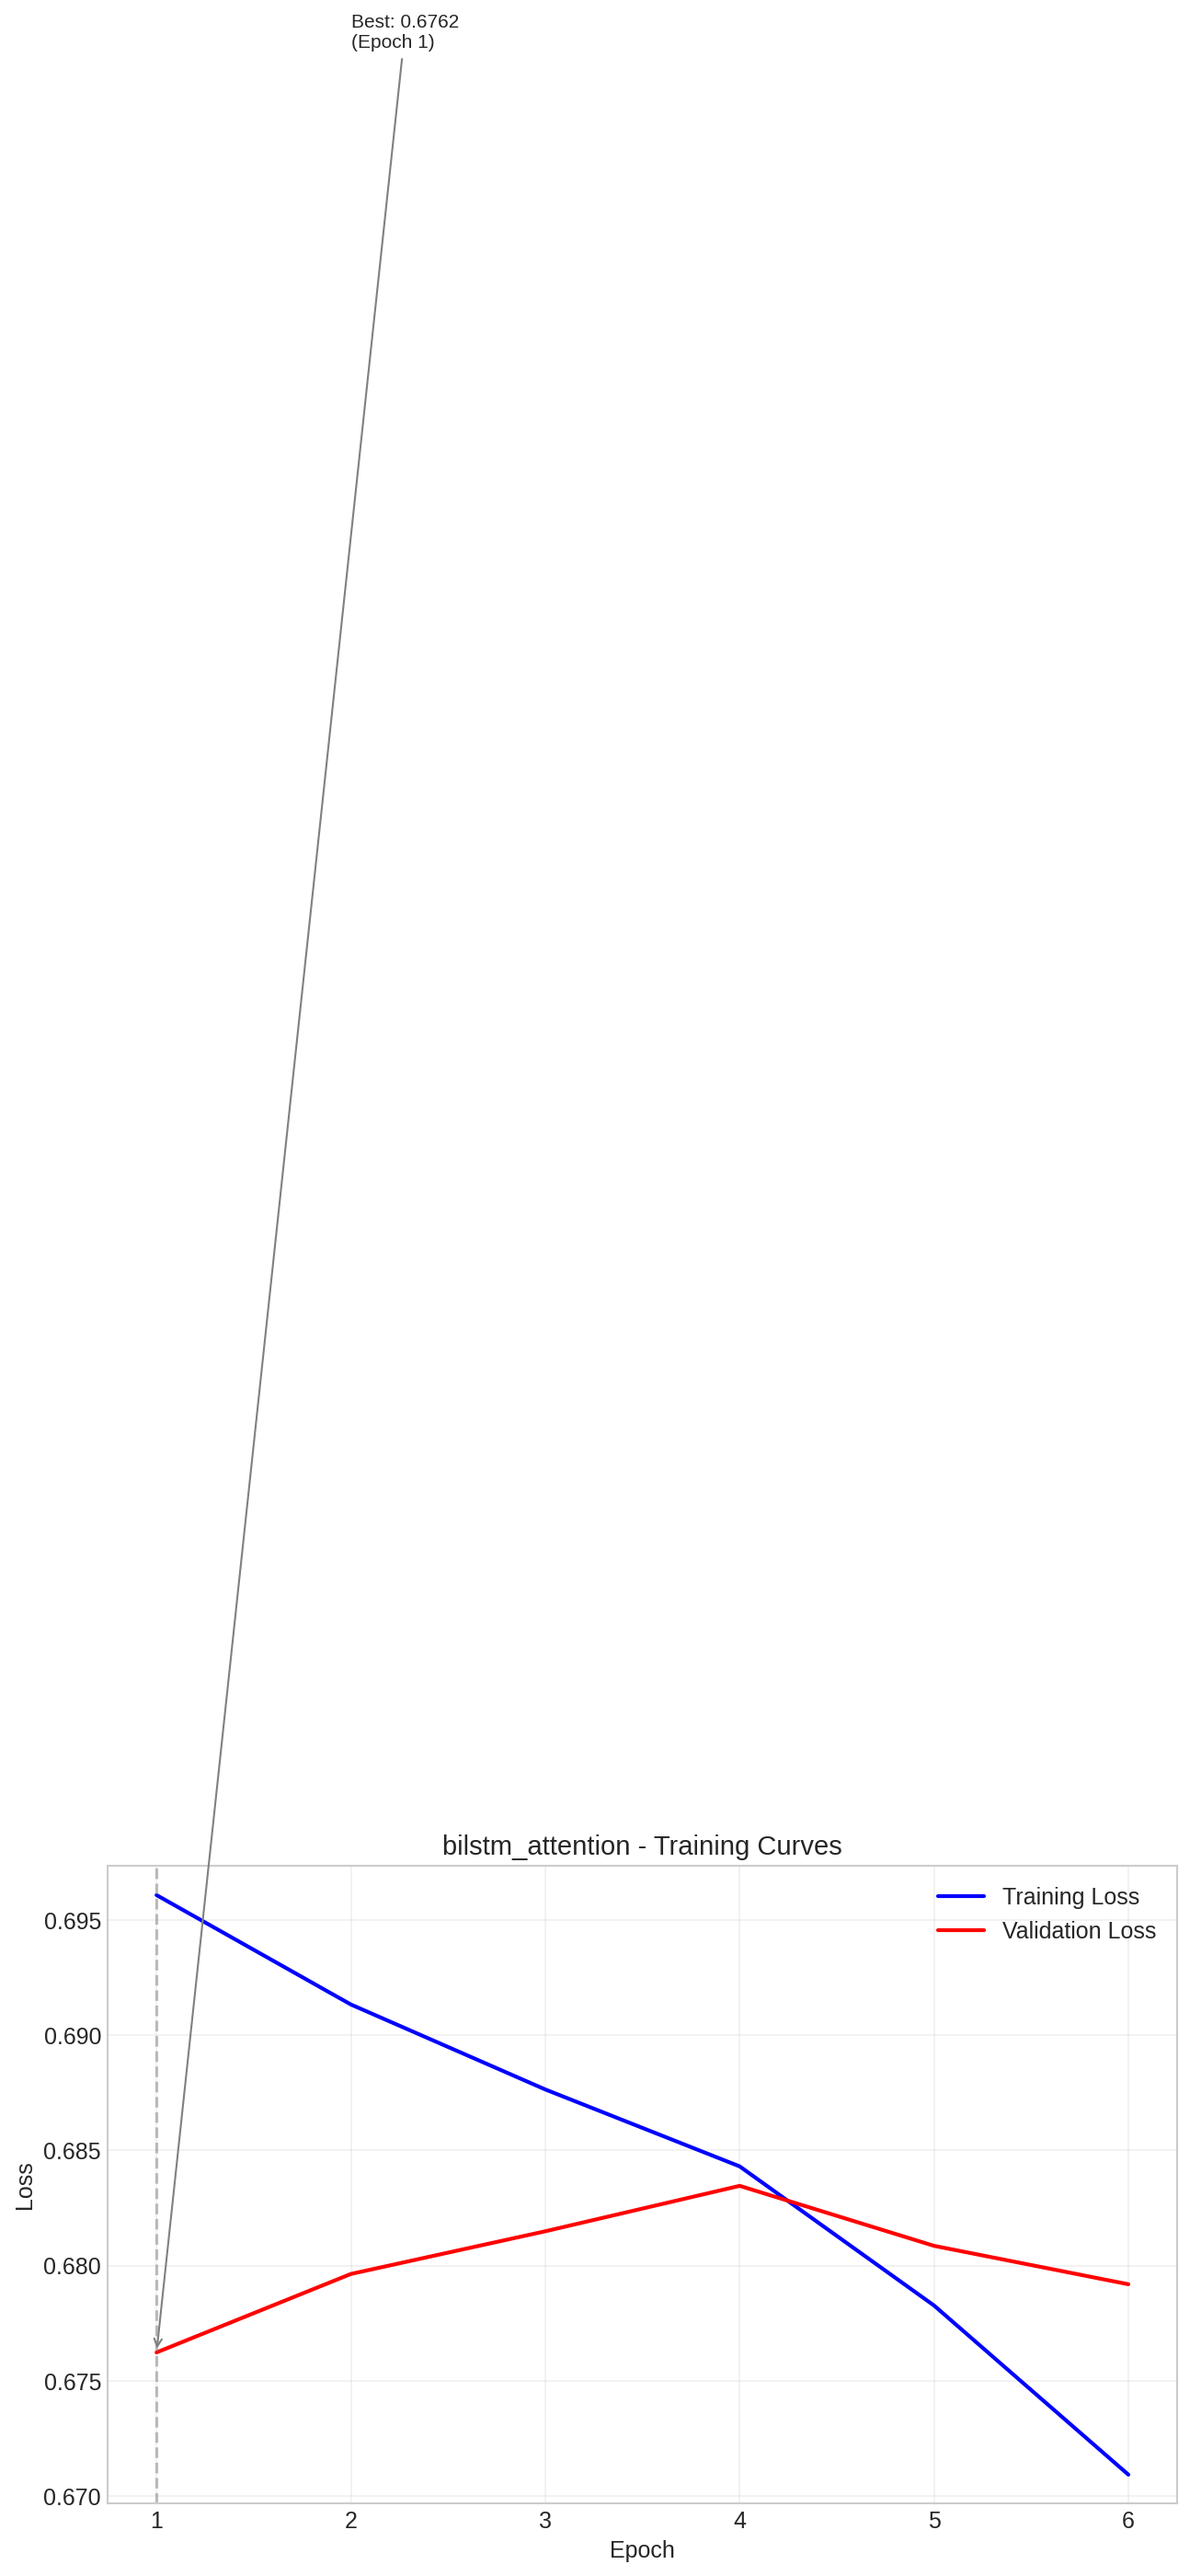


metrics_curves.png:


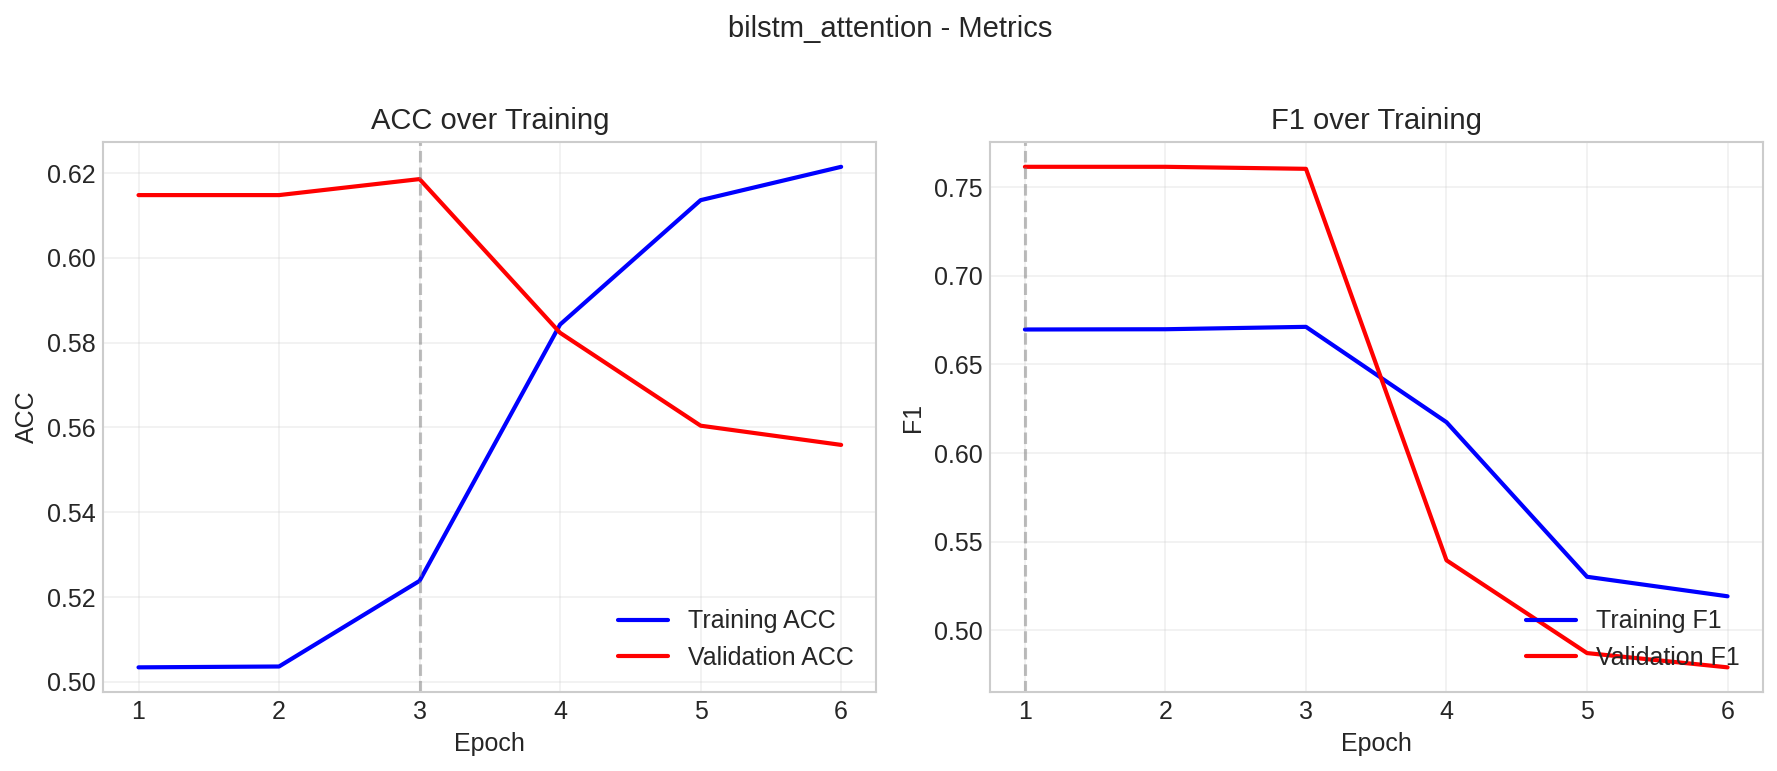


📊 bilstm_attention_hd128_nl2_dr0.5_eda_plus_p0.1
----------------------------------------

confusion_matrix.png:


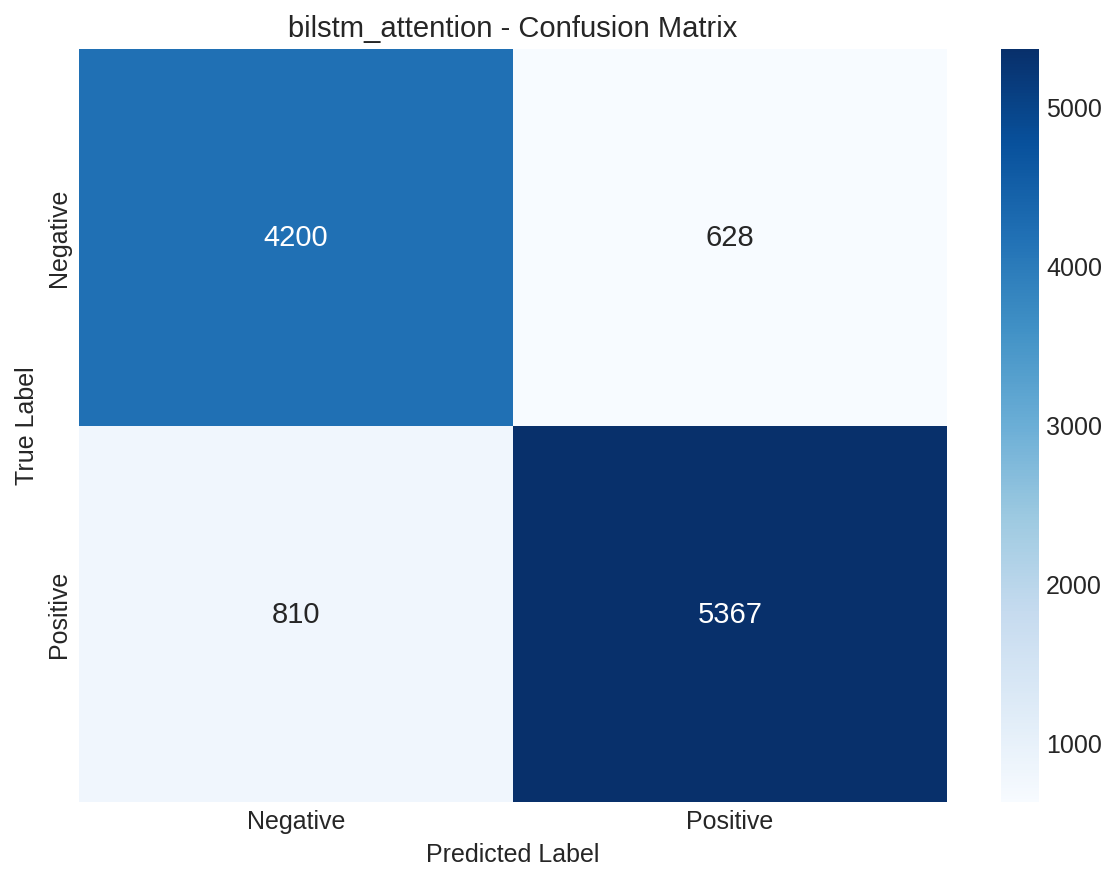


confusion_matrix_normalized.png:


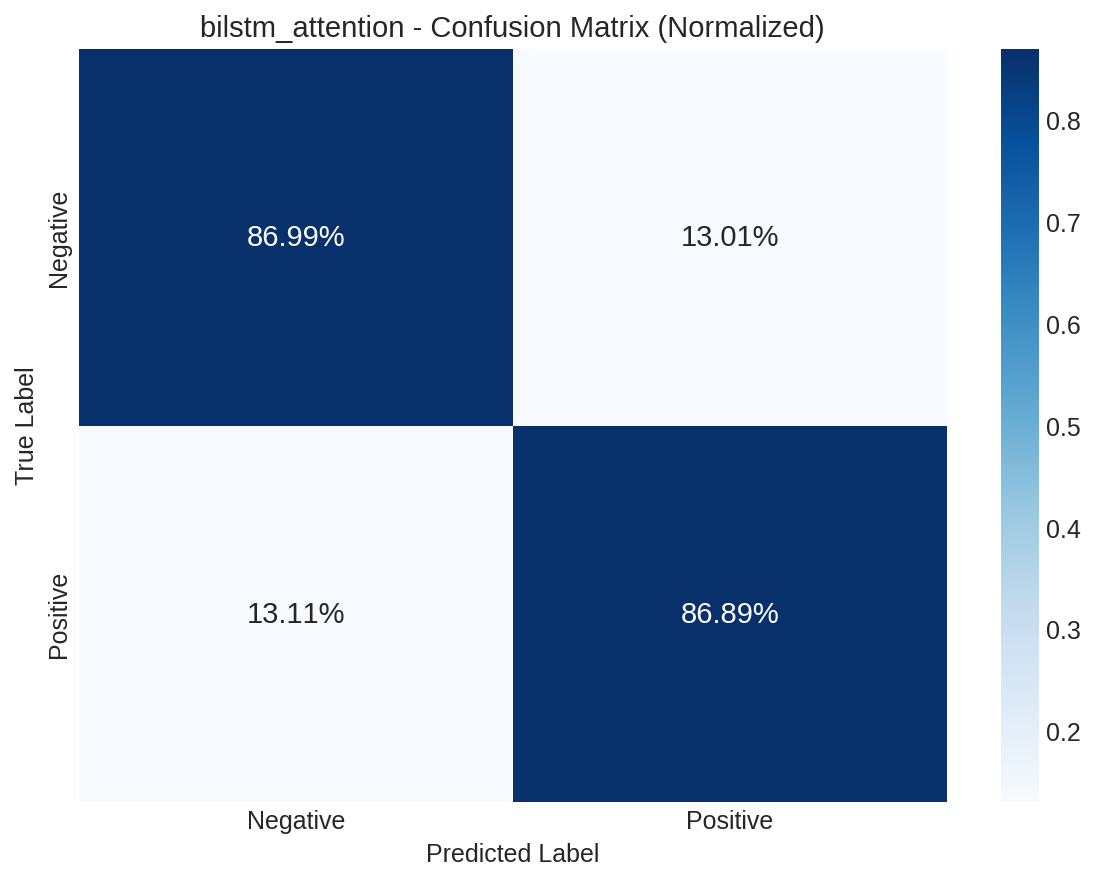


loss_curves.png:


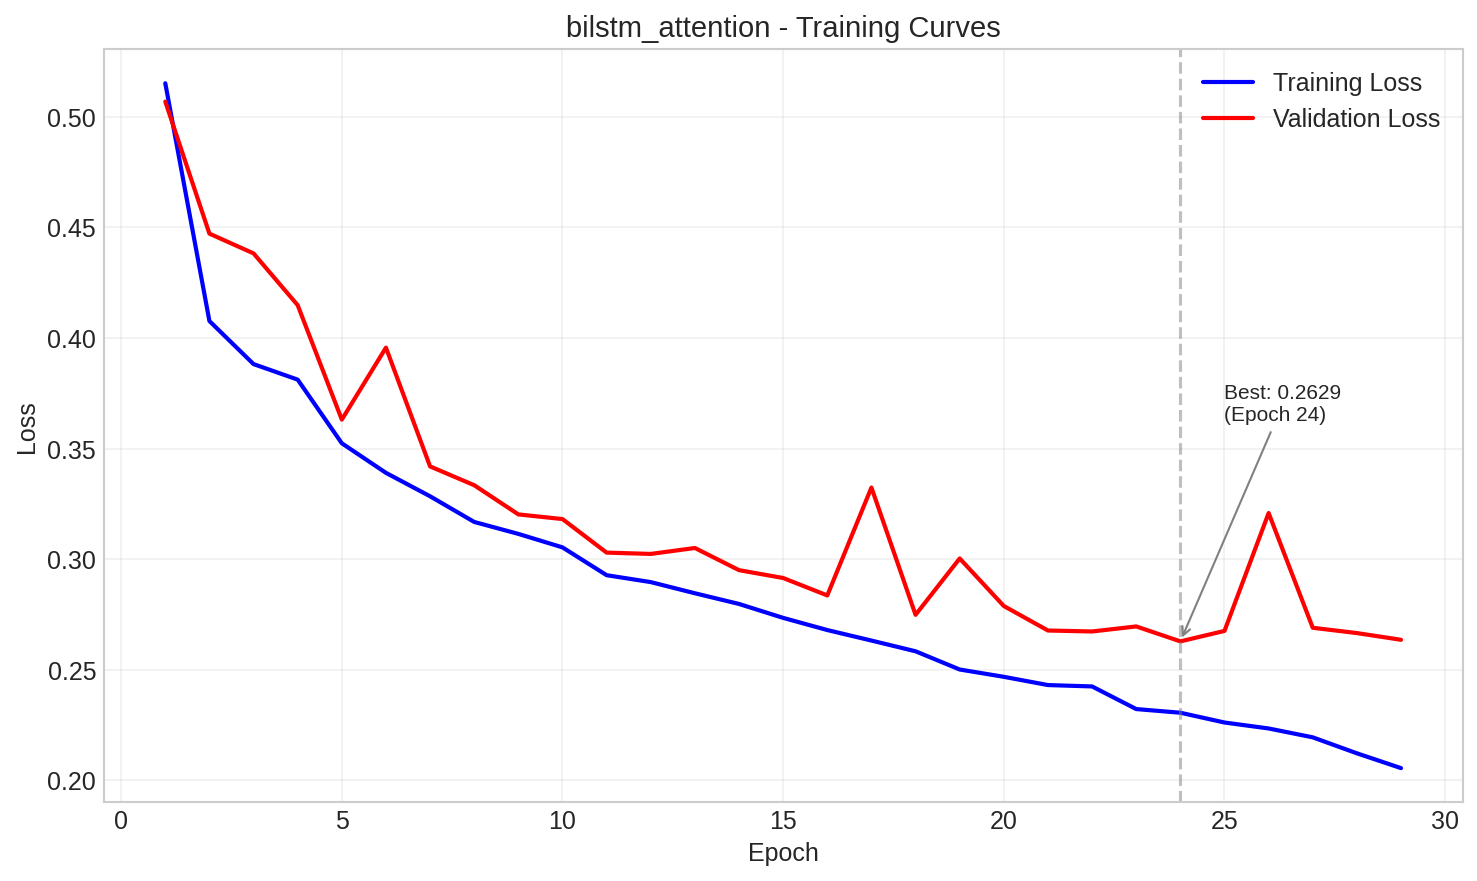


metrics_curves.png:


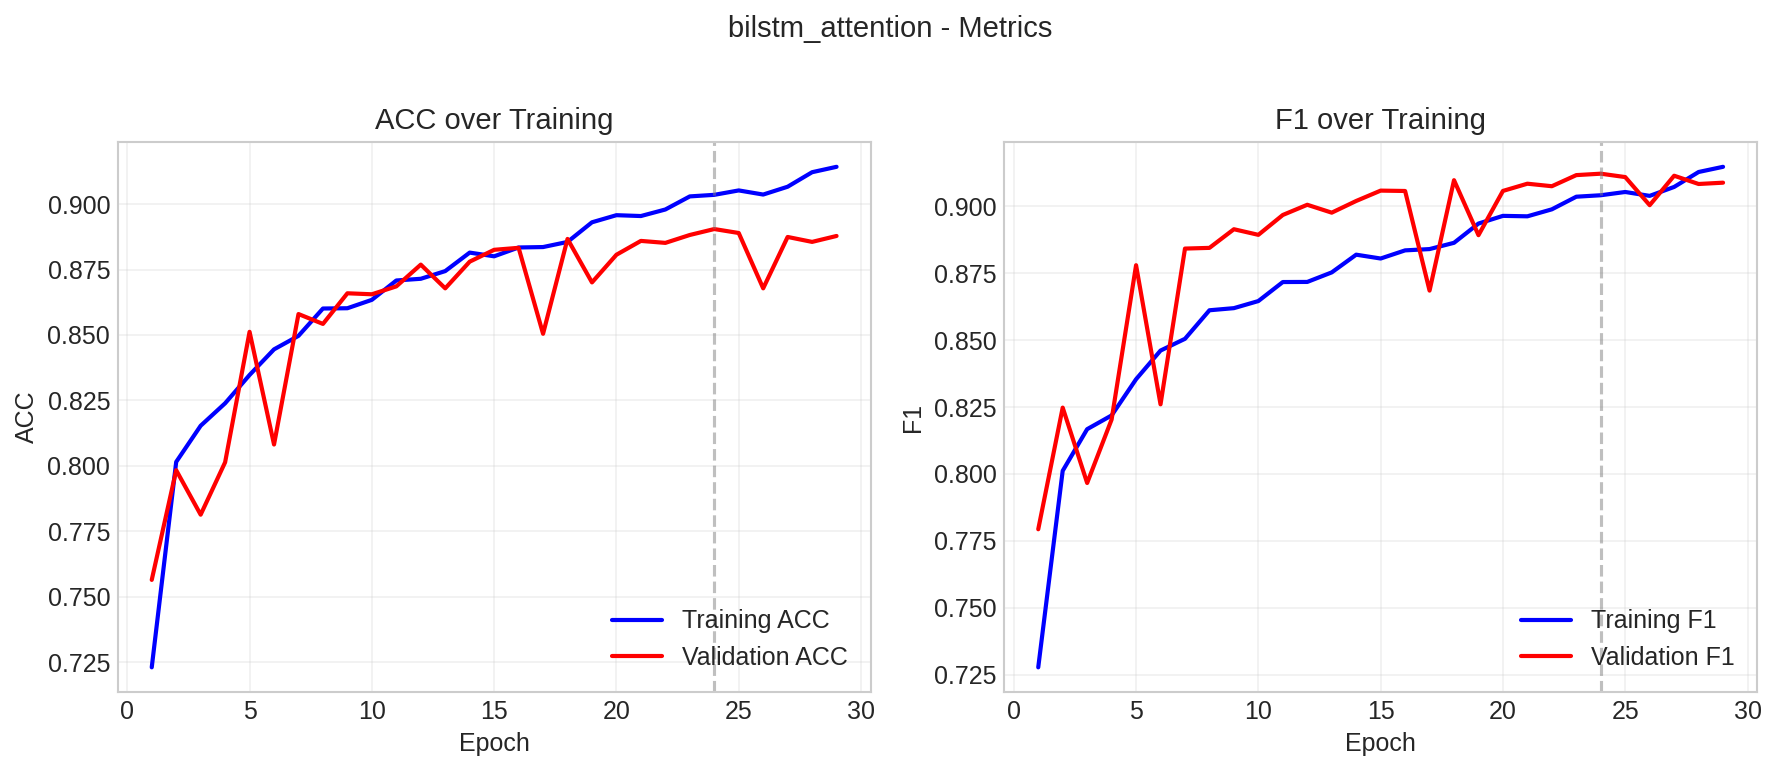


📊 bilstm_attention_hd128_nl2_noaug
----------------------------------------

confusion_matrix.png:


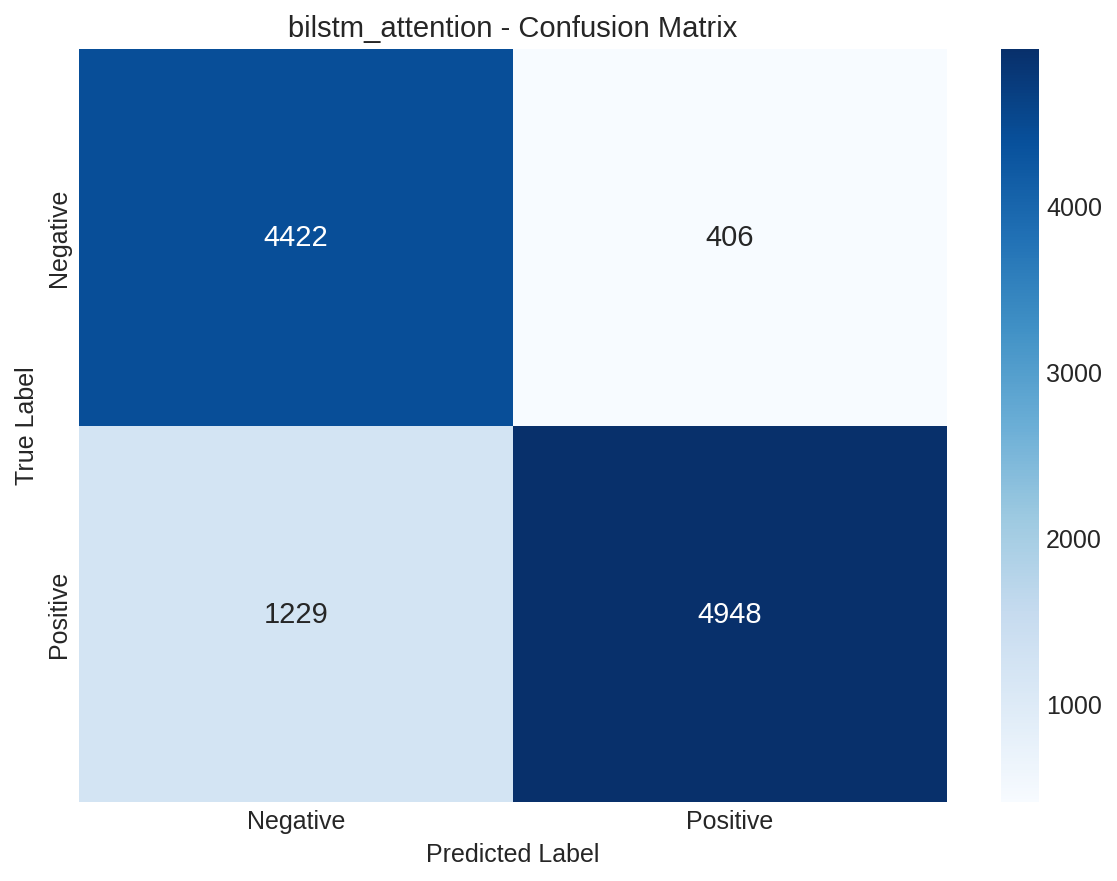


confusion_matrix_normalized.png:


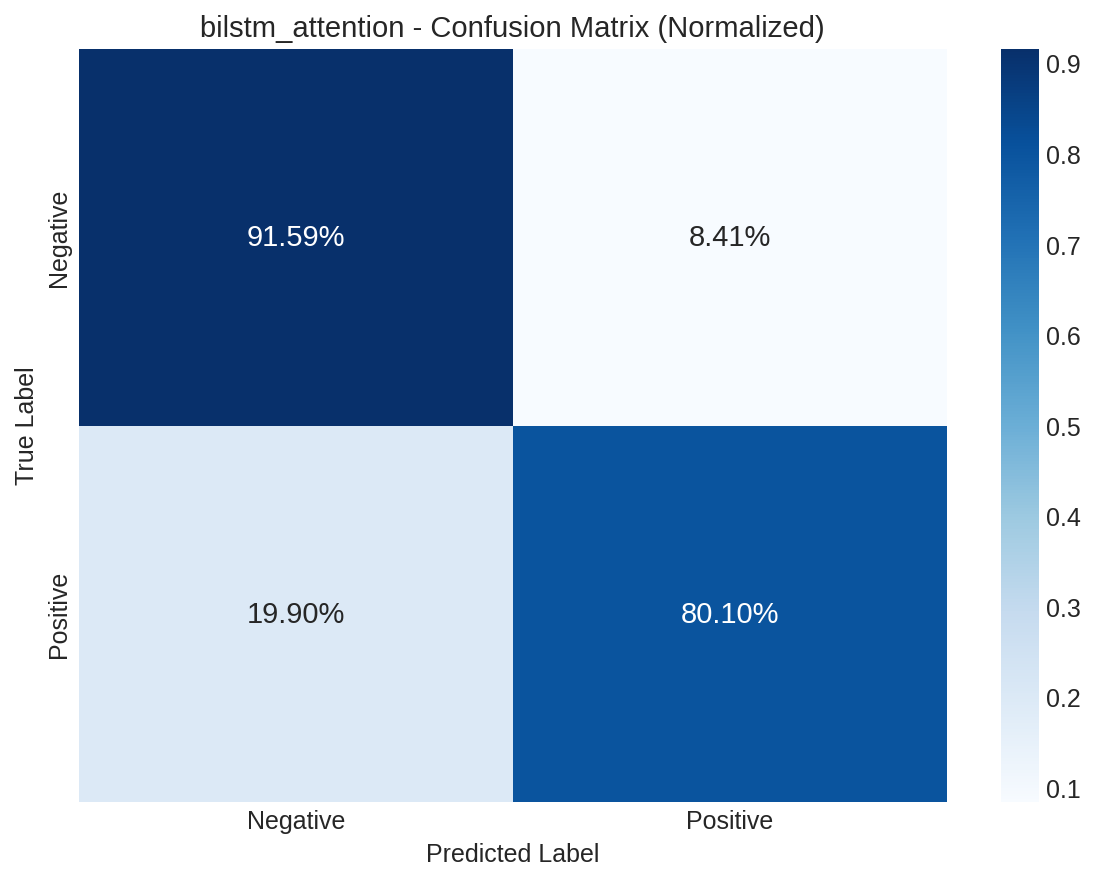


loss_curves.png:


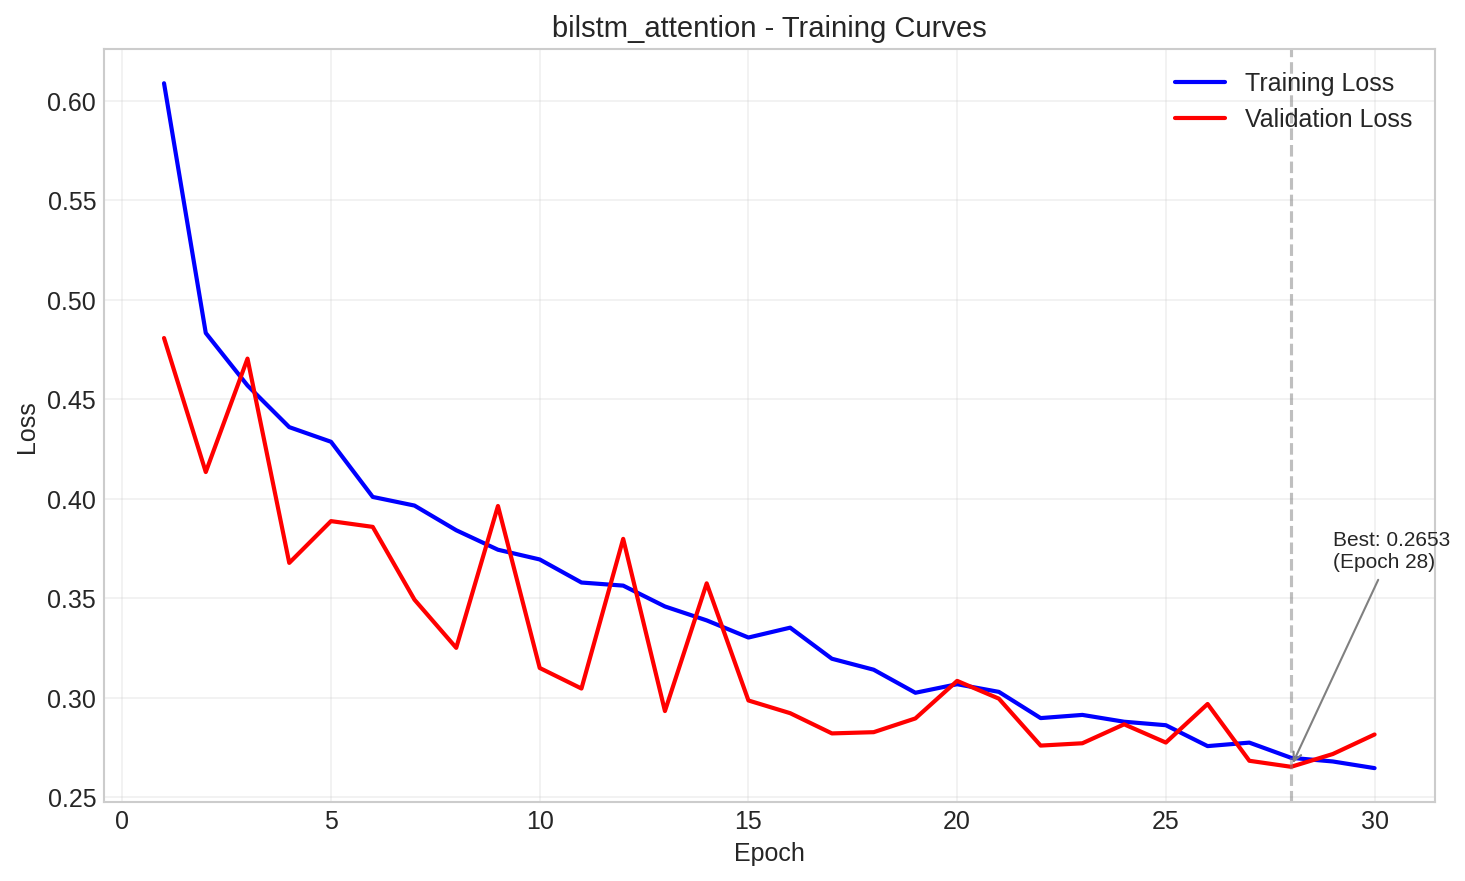


metrics_curves.png:


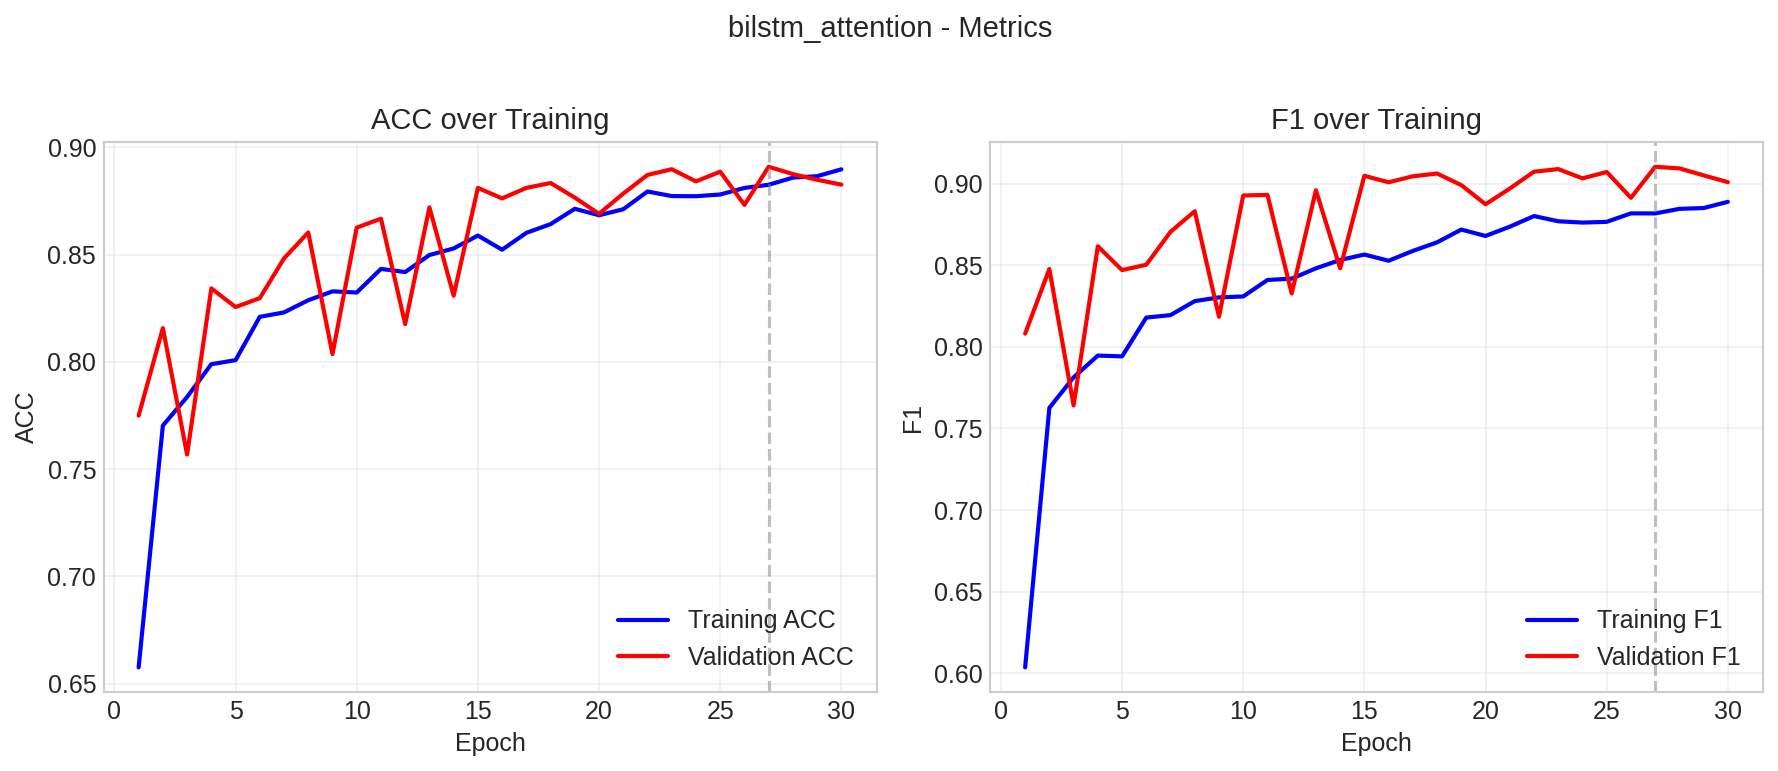


📊 bilstm_attention_noaug
----------------------------------------

confusion_matrix.png:


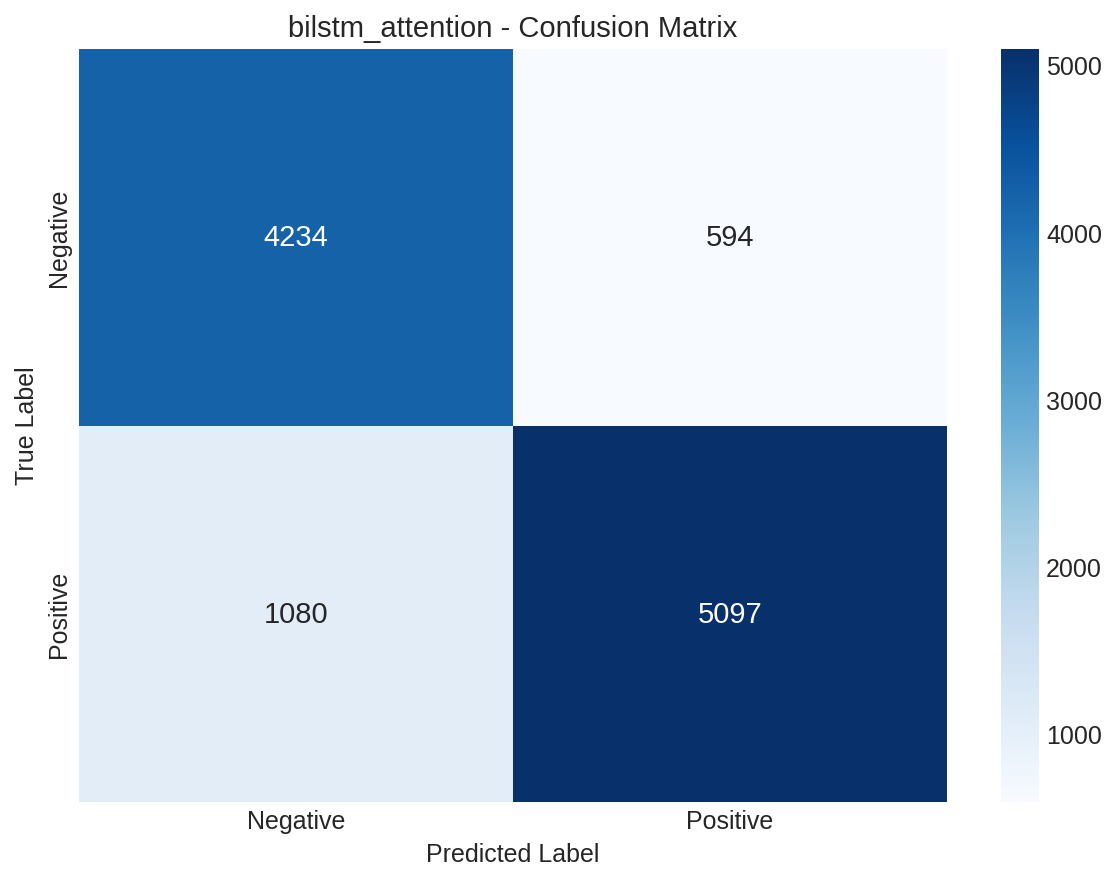


confusion_matrix_normalized.png:


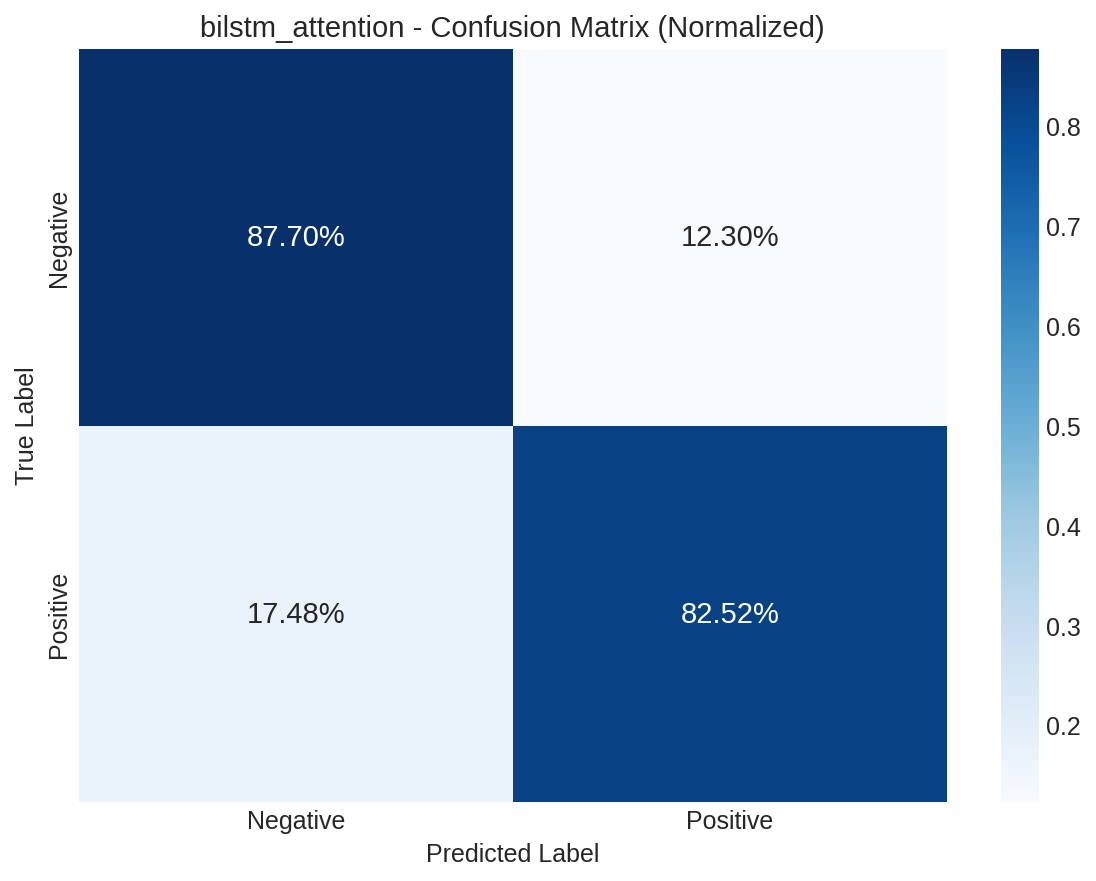


loss_curves.png:


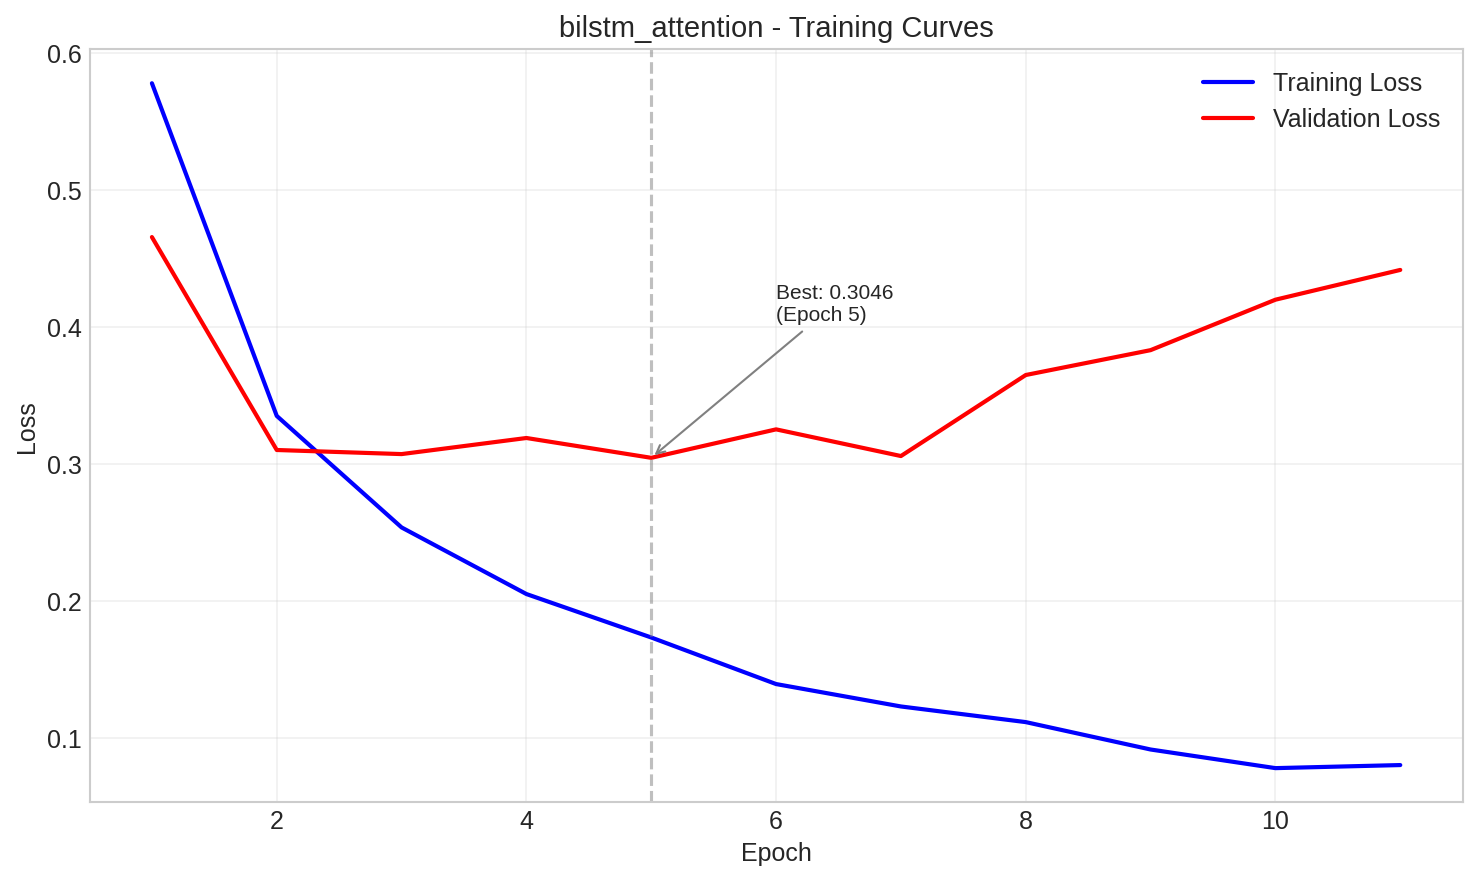


metrics_curves.png:


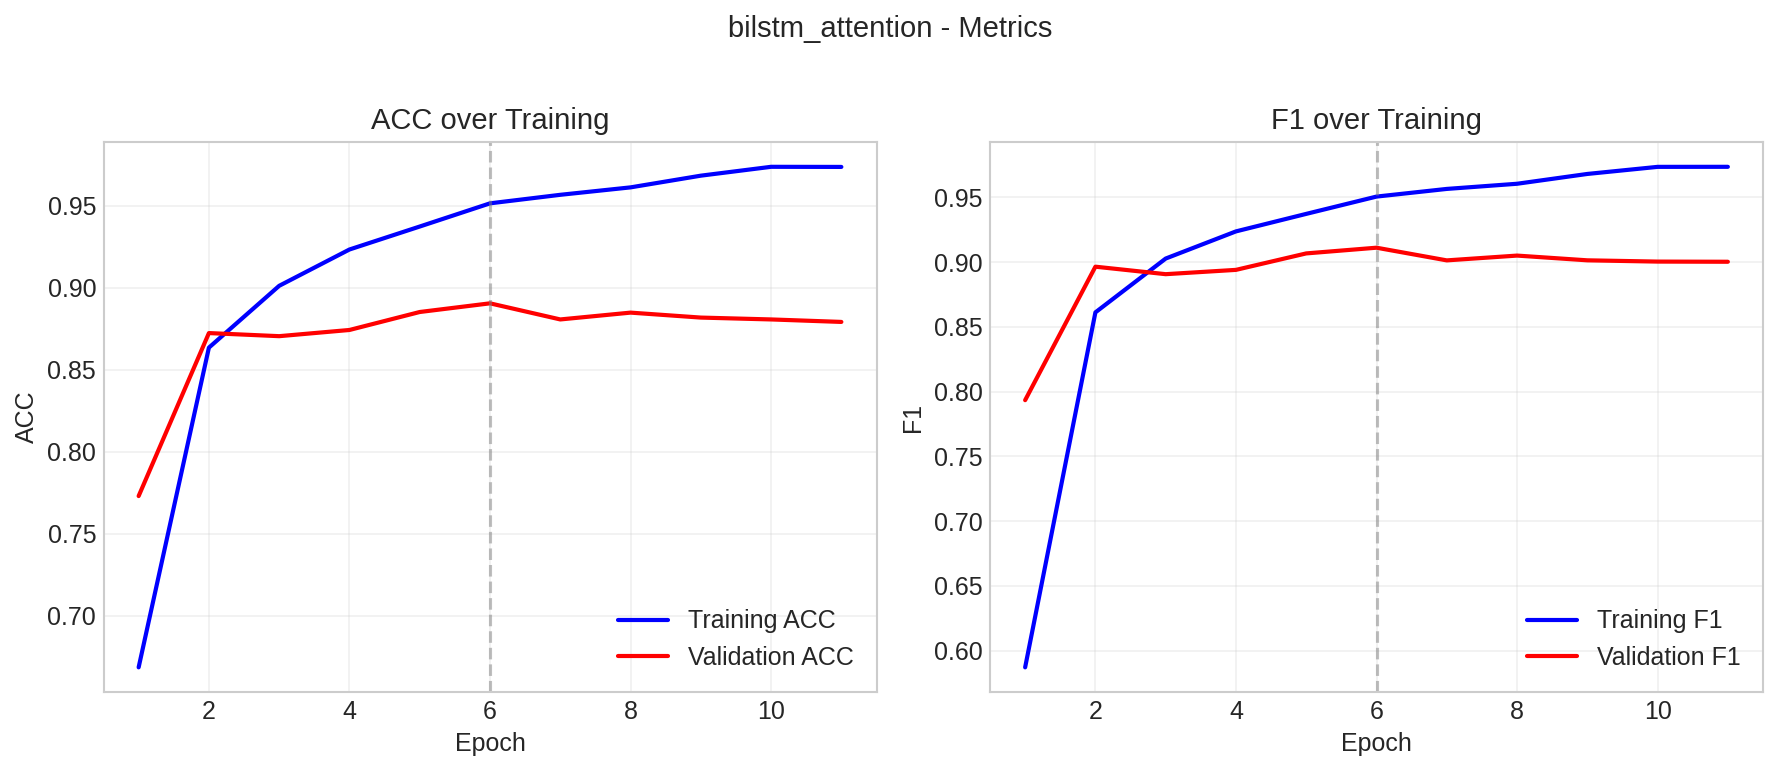


📊 lstm_batchnorm_bi_eda_plus_p0.3
----------------------------------------

confusion_matrix.png:


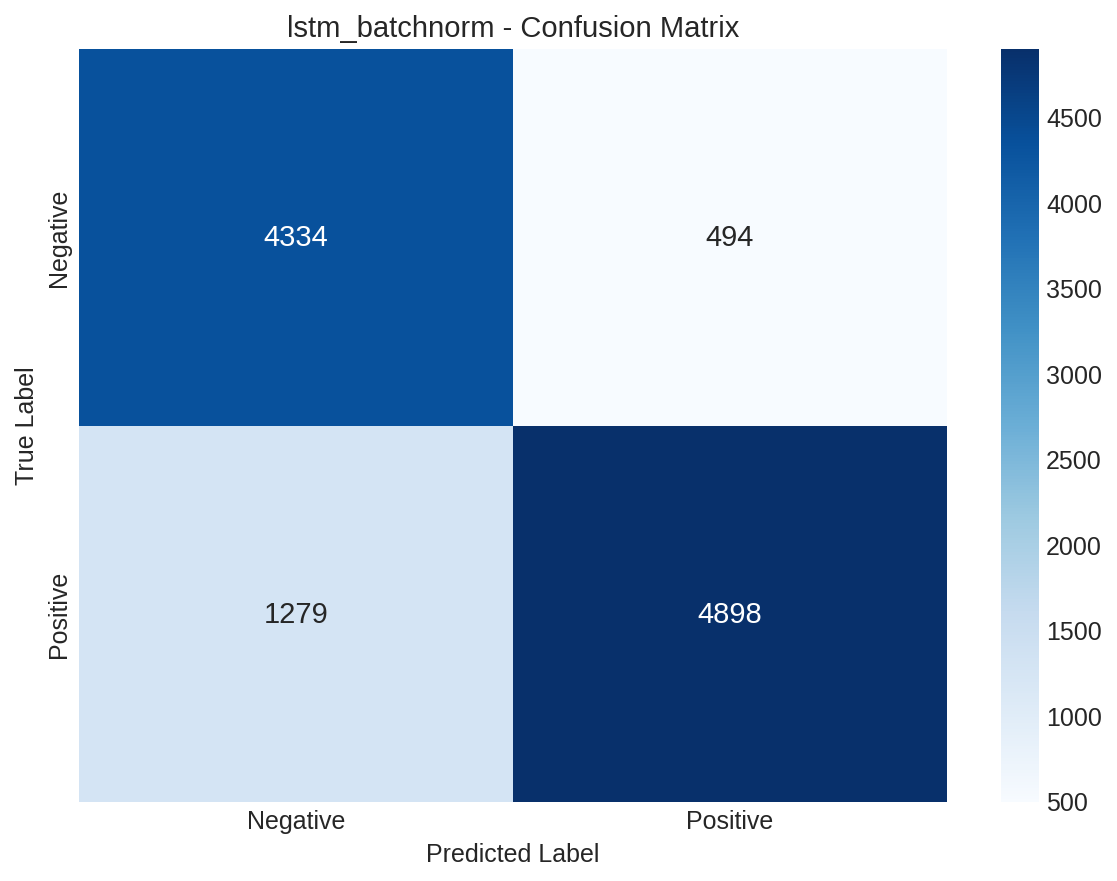


confusion_matrix_normalized.png:


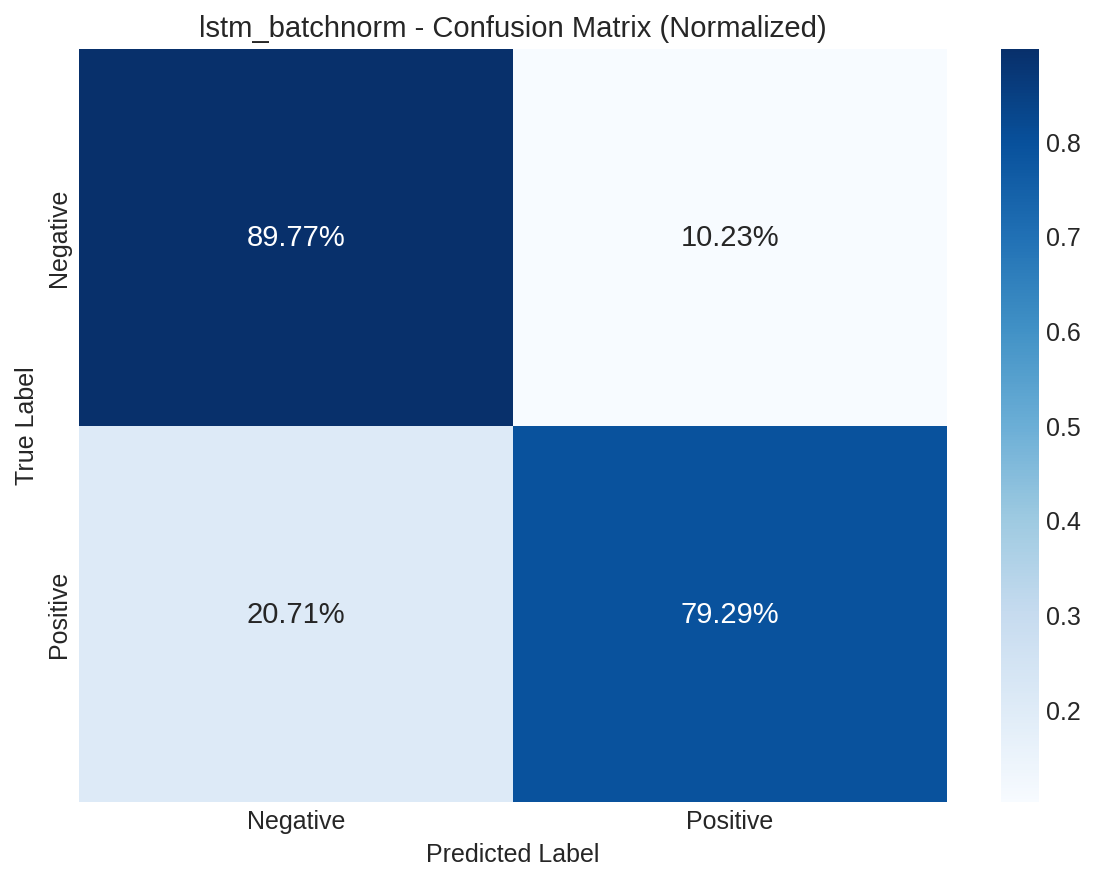


loss_curves.png:


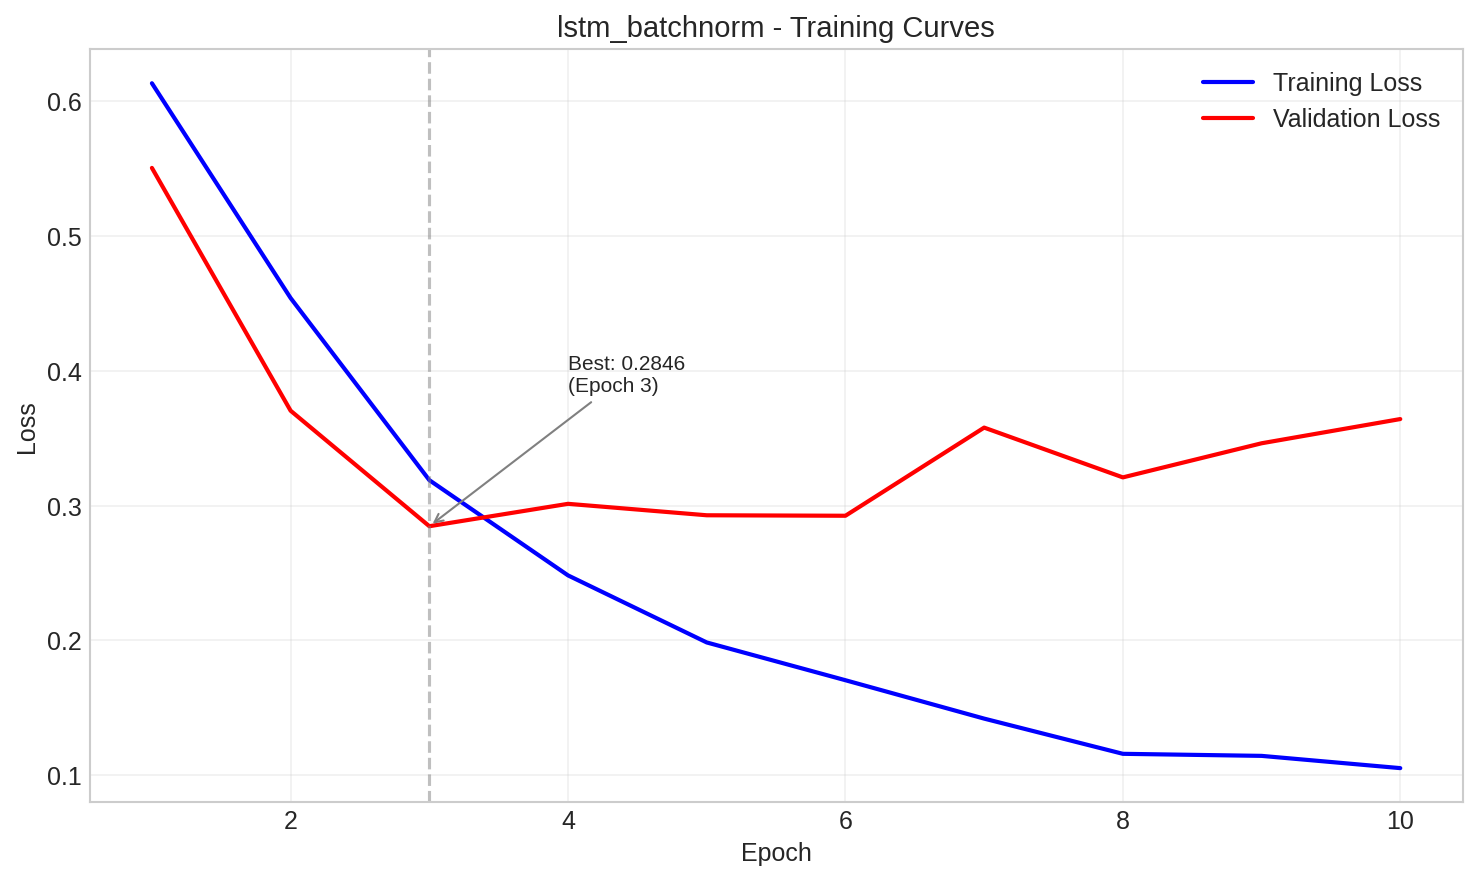


metrics_curves.png:


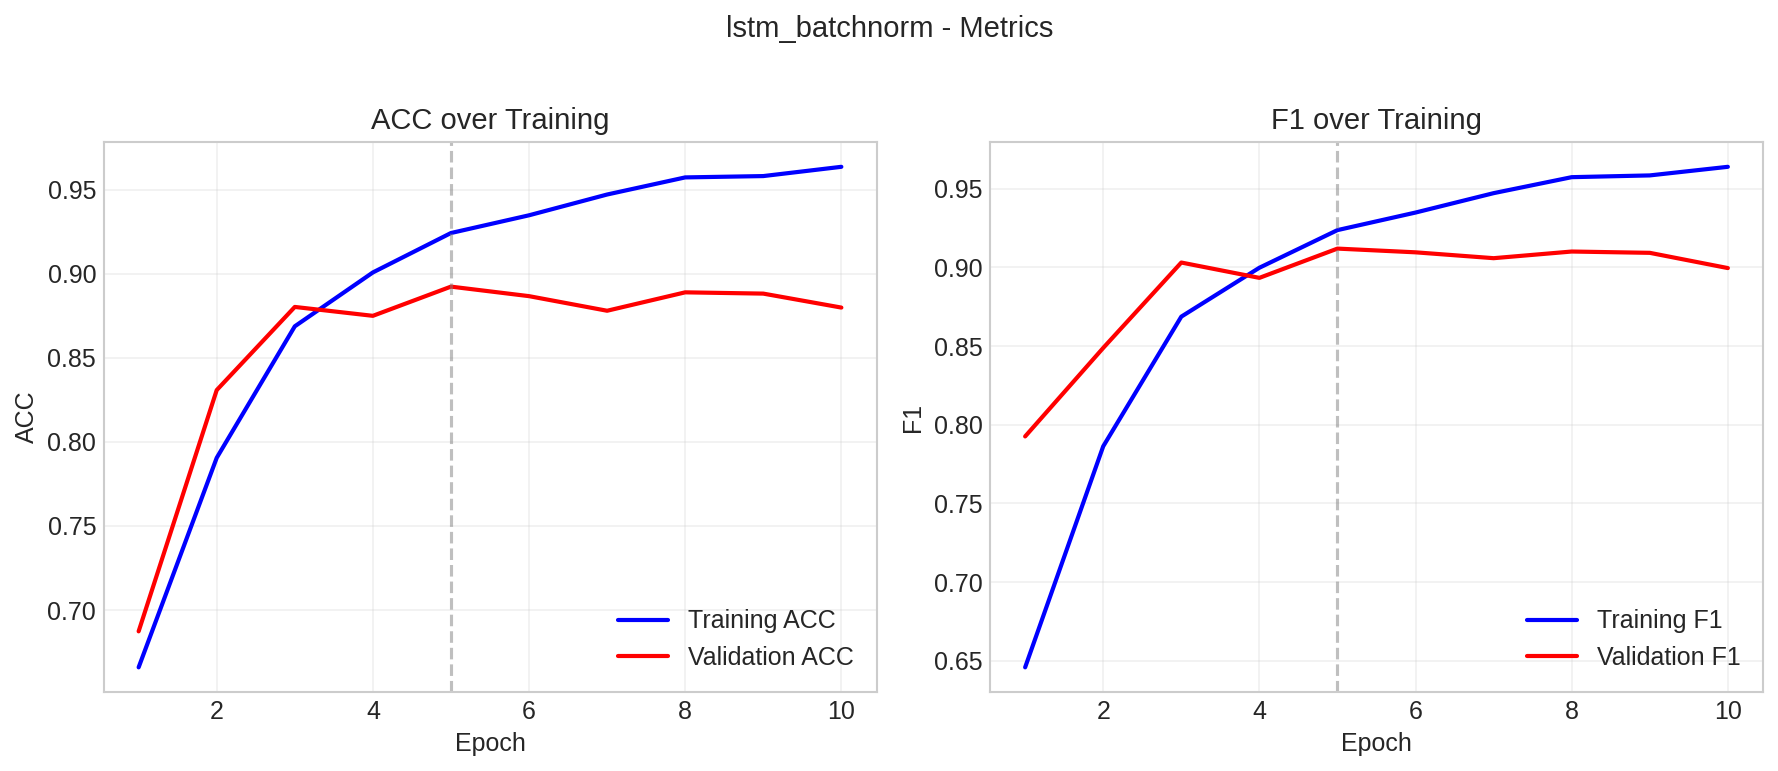


📊 lstm_batchnorm_bi_noaug
----------------------------------------

confusion_matrix.png:


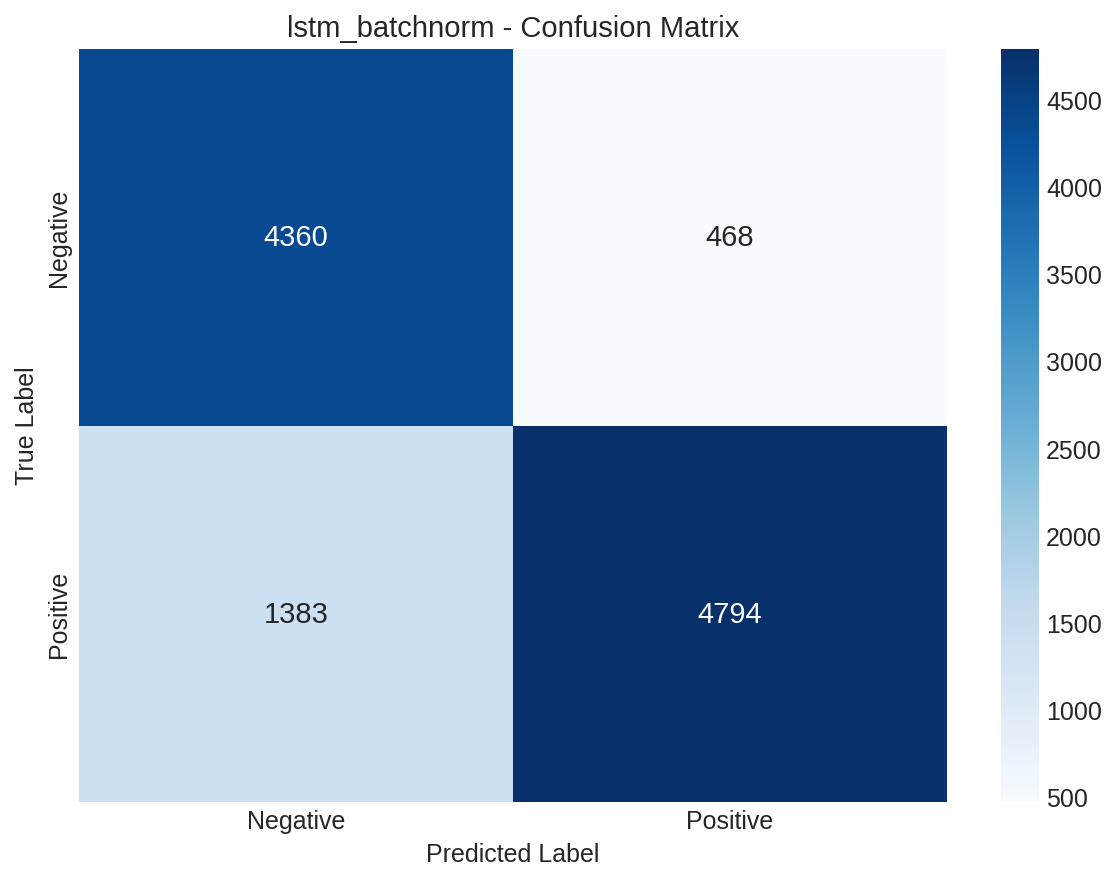


confusion_matrix_normalized.png:


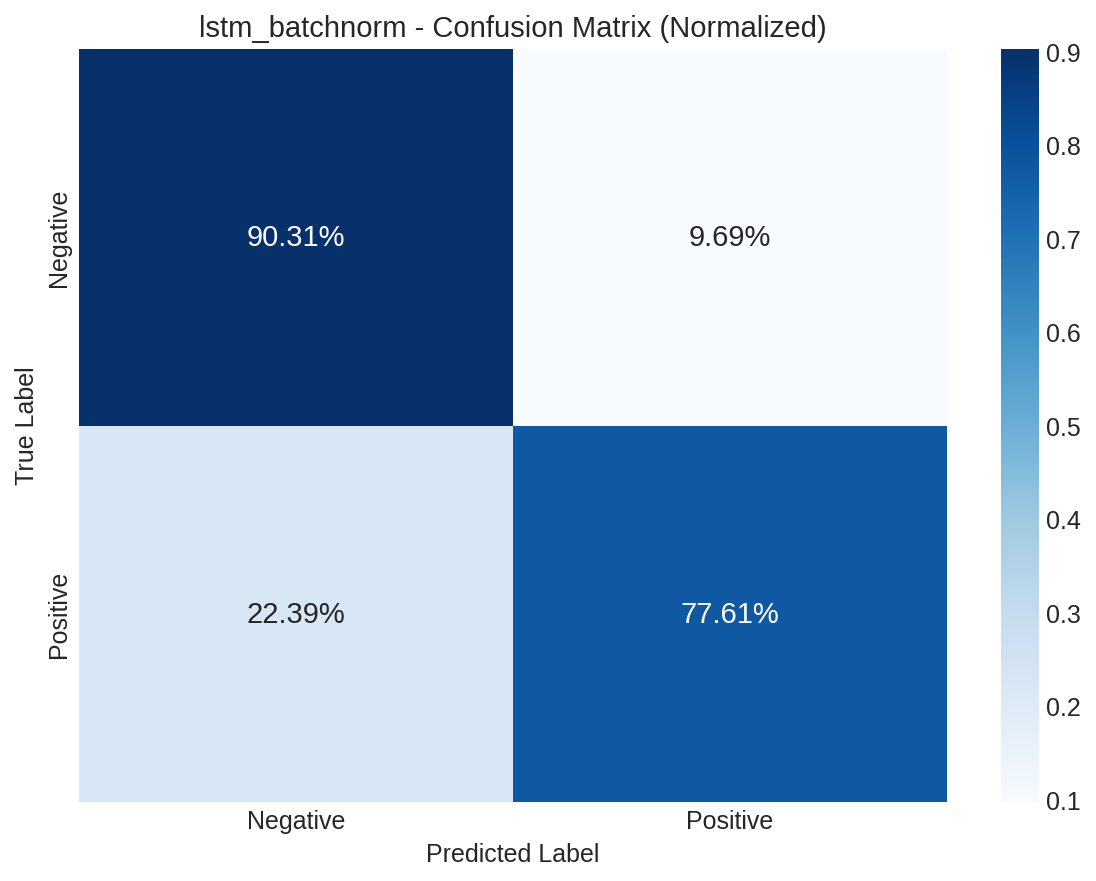


loss_curves.png:


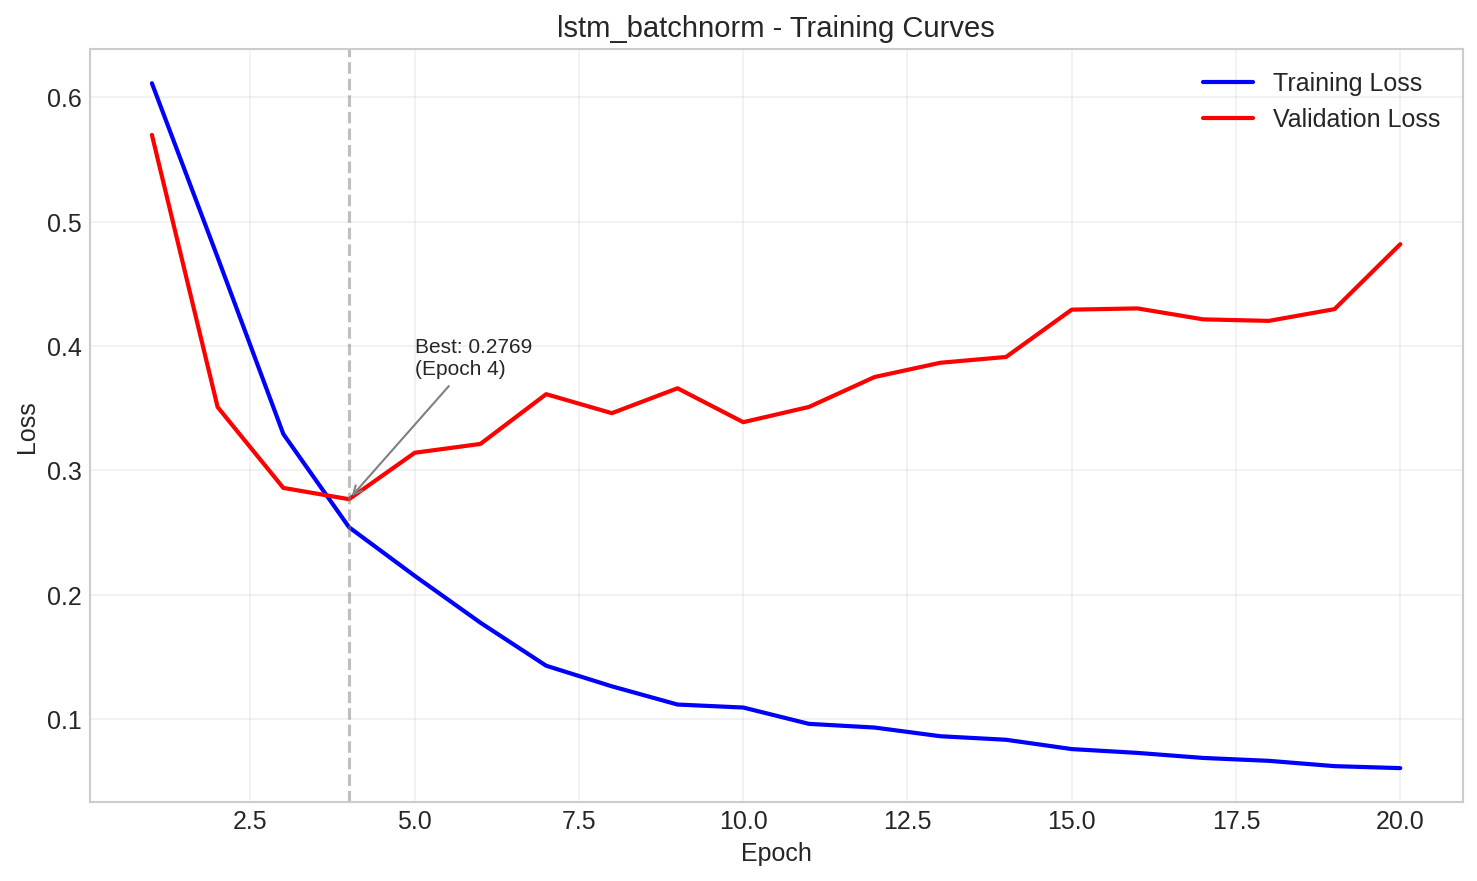


metrics_curves.png:


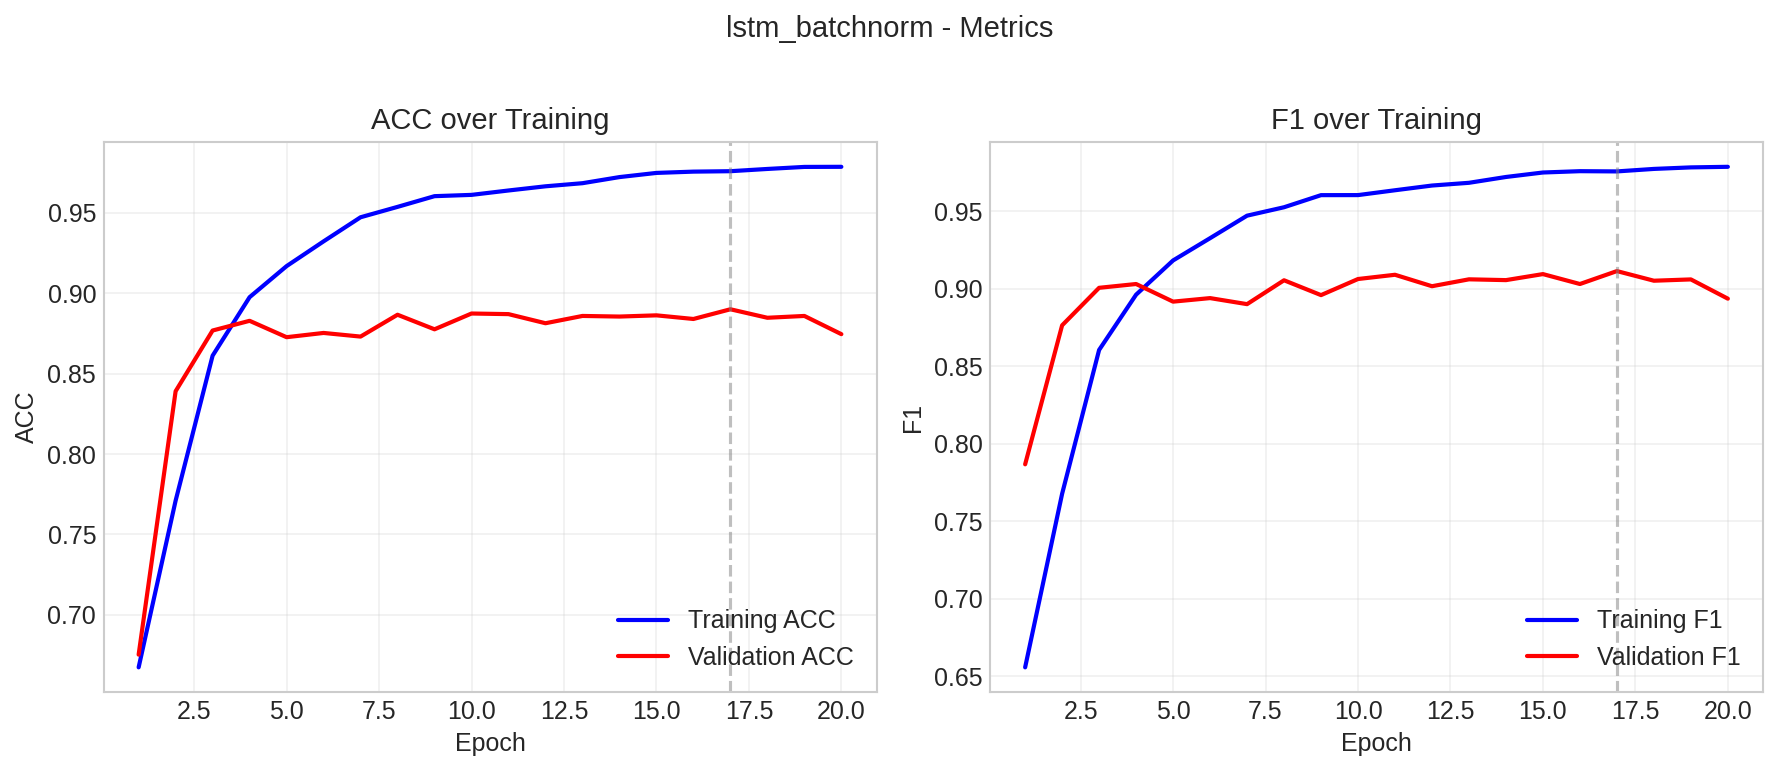


📊 lstm_bi_eda_plus_p0.3
----------------------------------------

confusion_matrix.png:


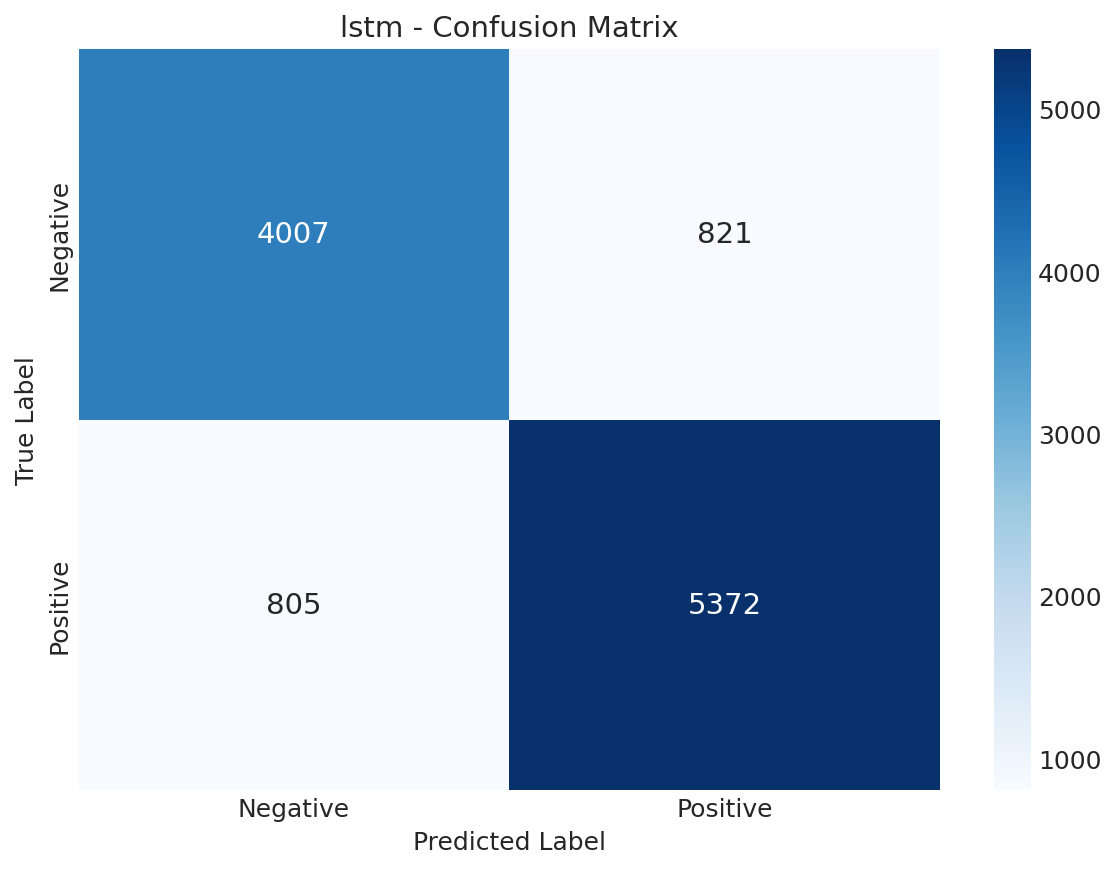


confusion_matrix_normalized.png:


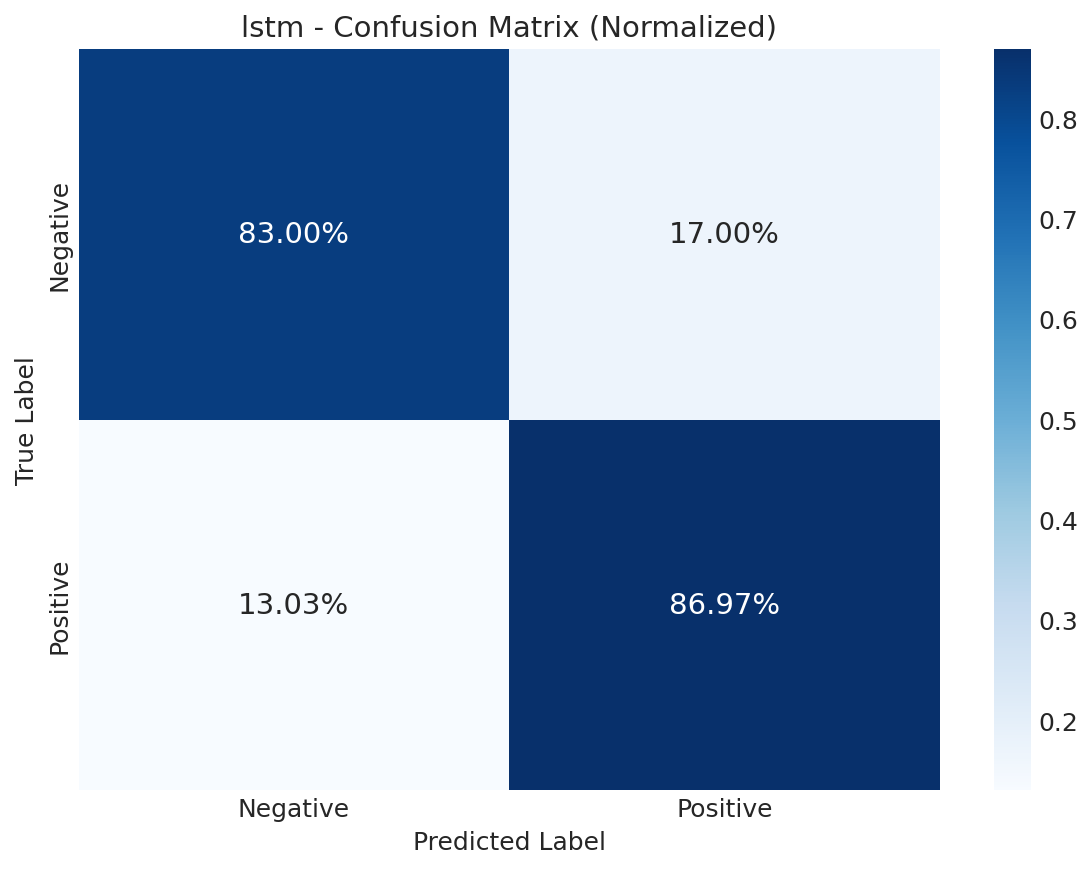


loss_curves.png:


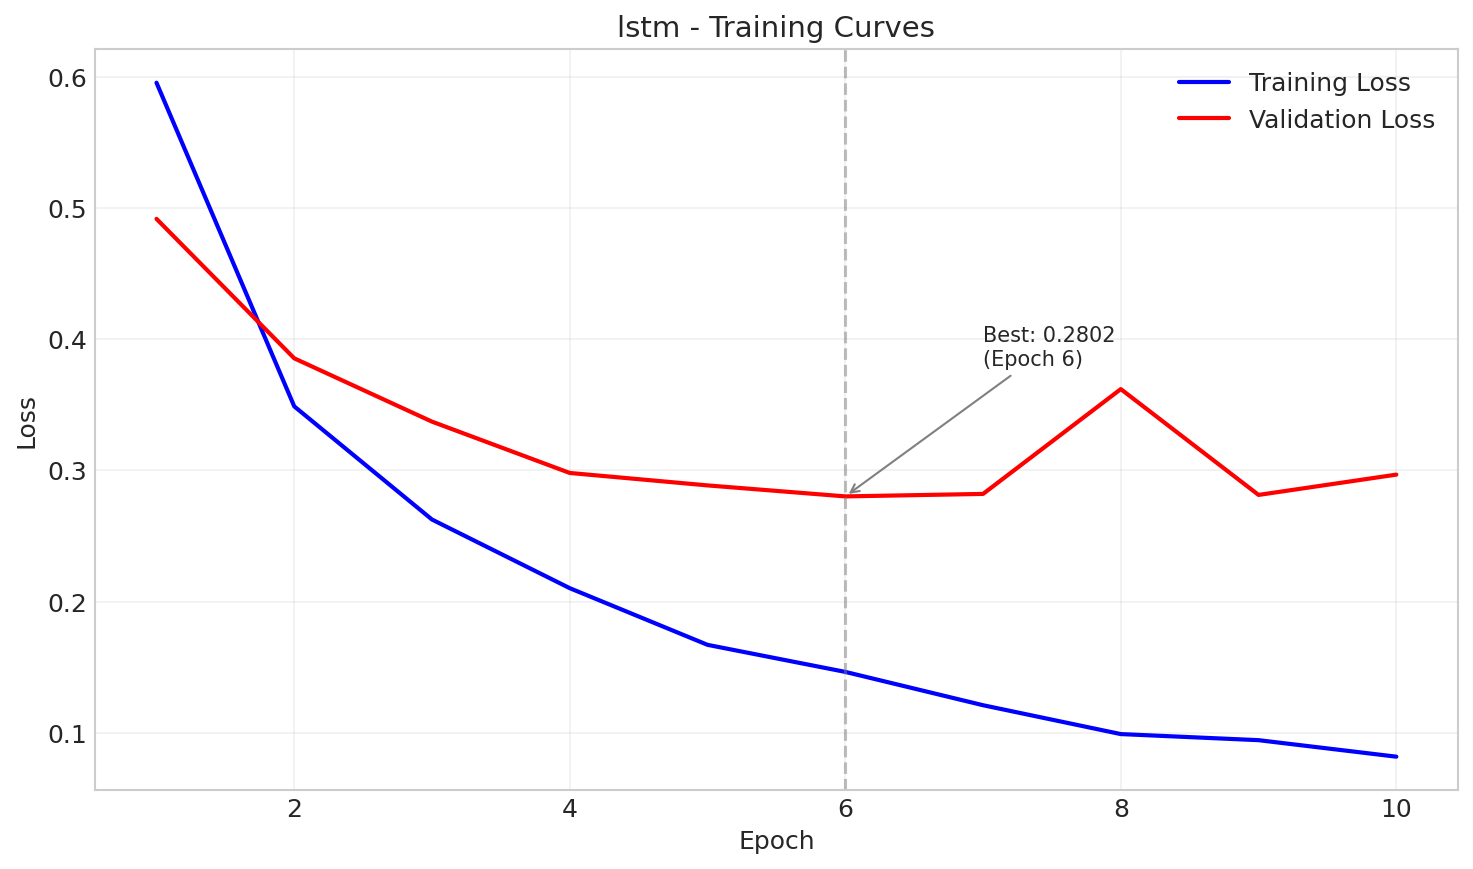


metrics_curves.png:


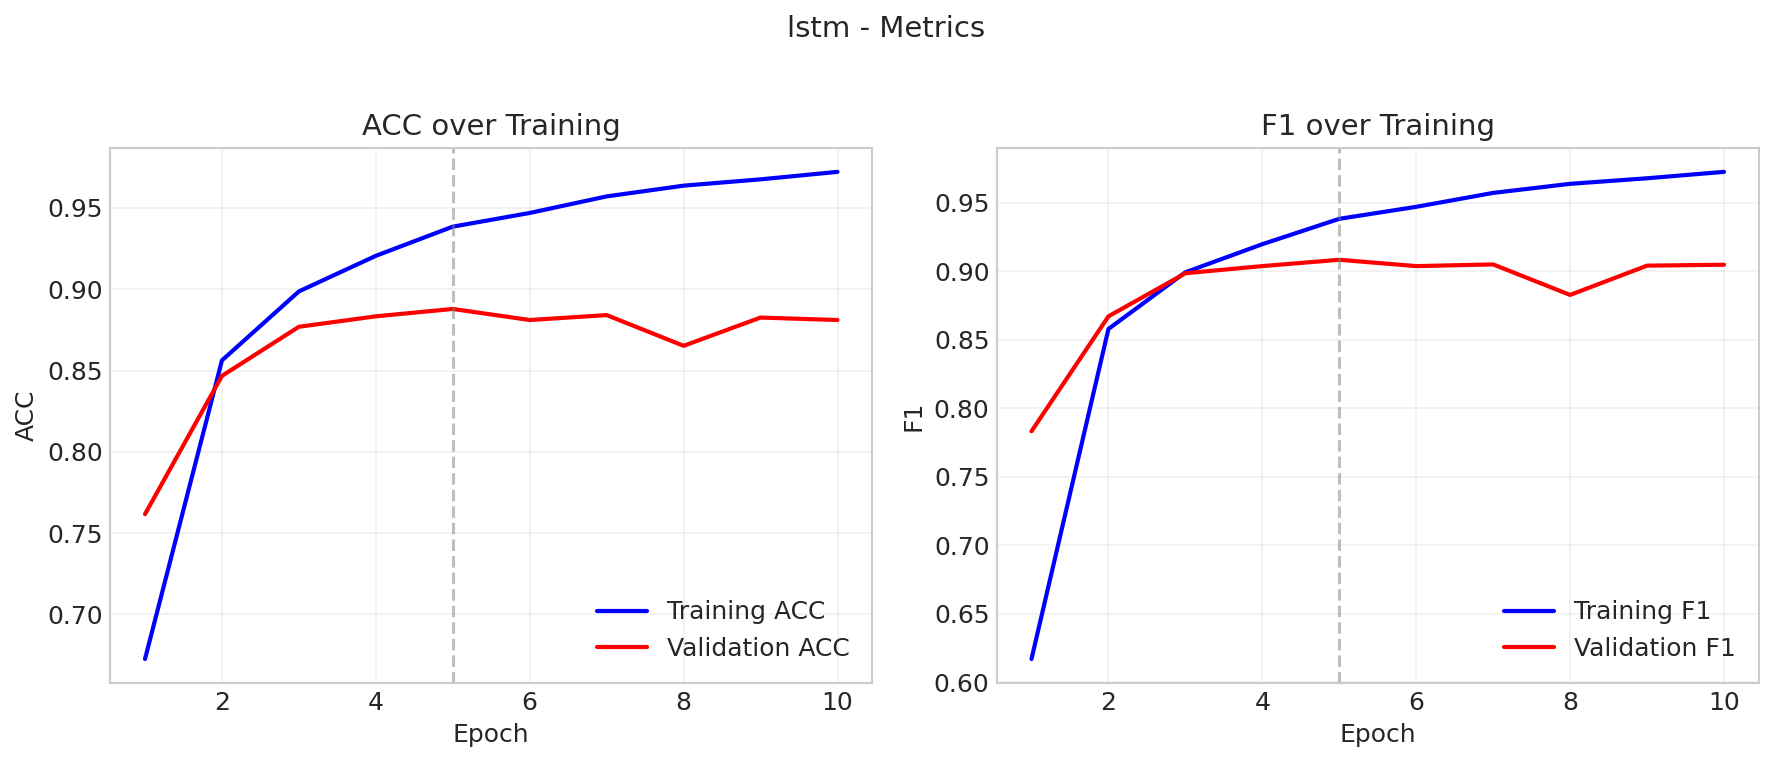


📊 lstm_bi_hd128_nl1_noaug
----------------------------------------

confusion_matrix.png:


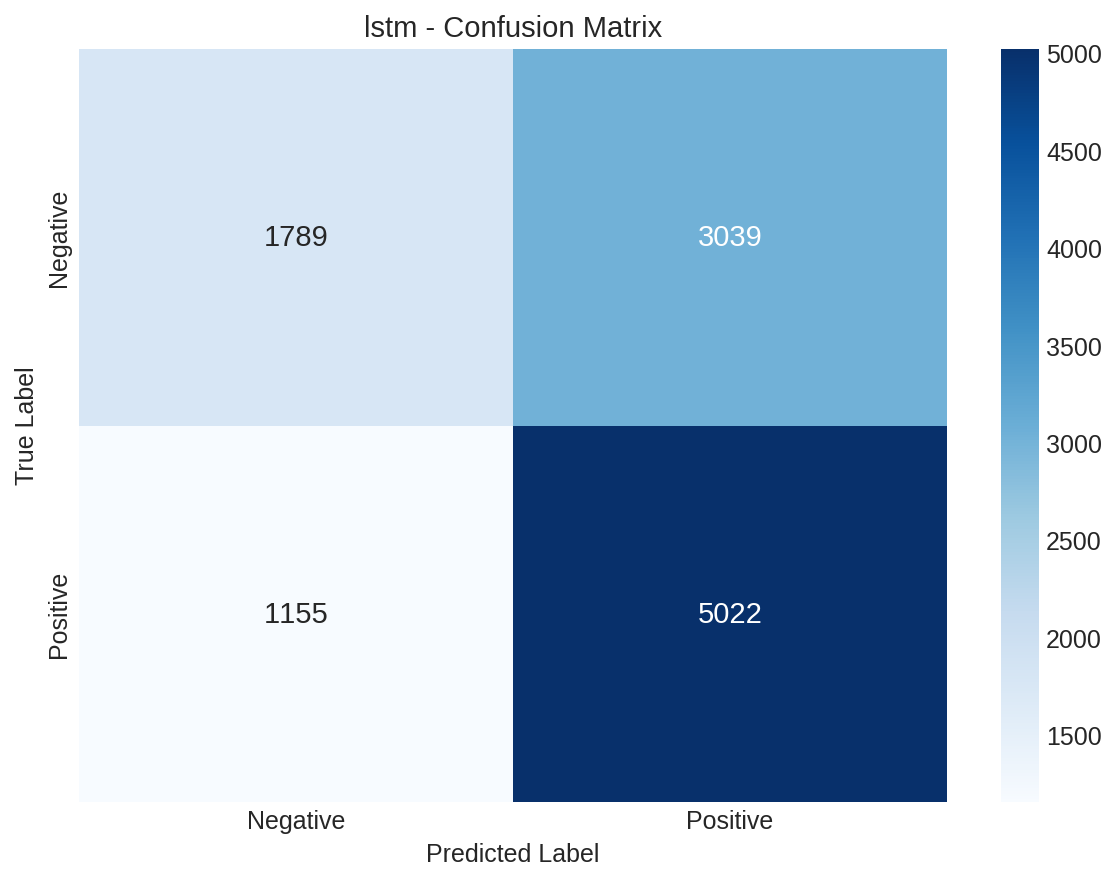


confusion_matrix_normalized.png:


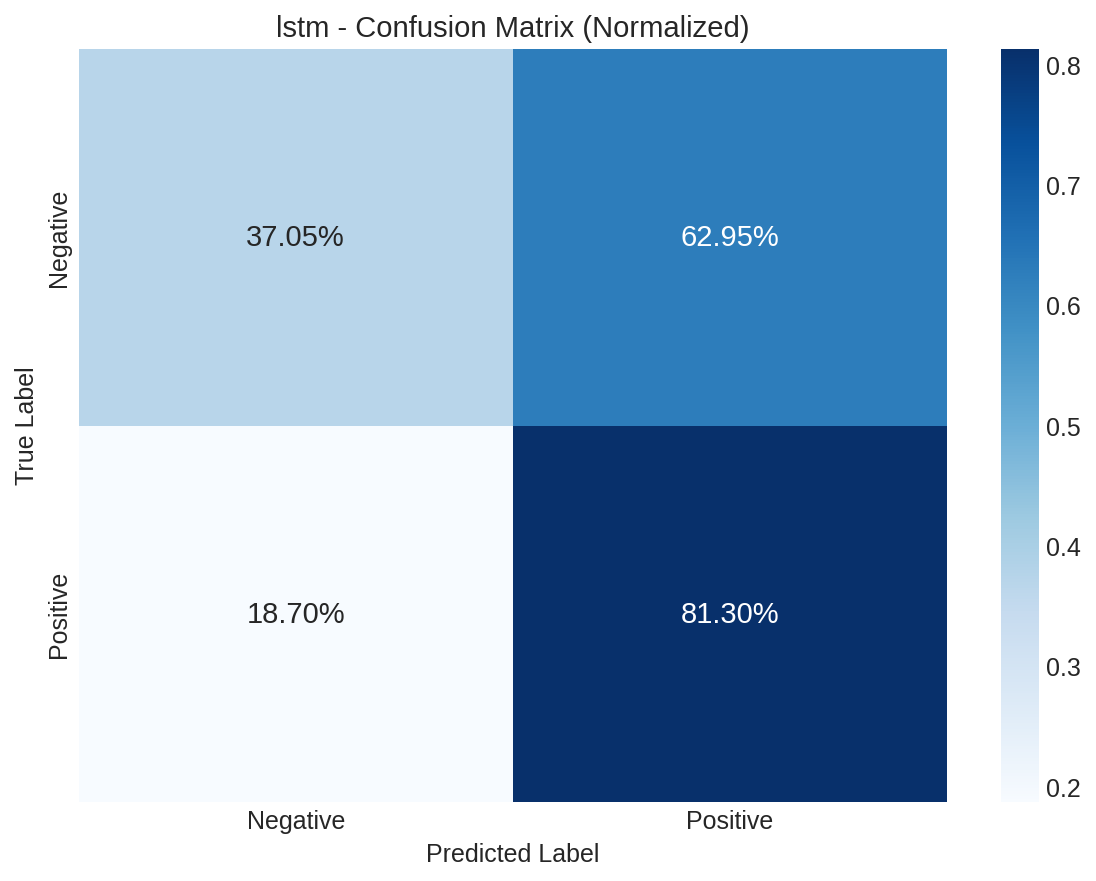


loss_curves.png:


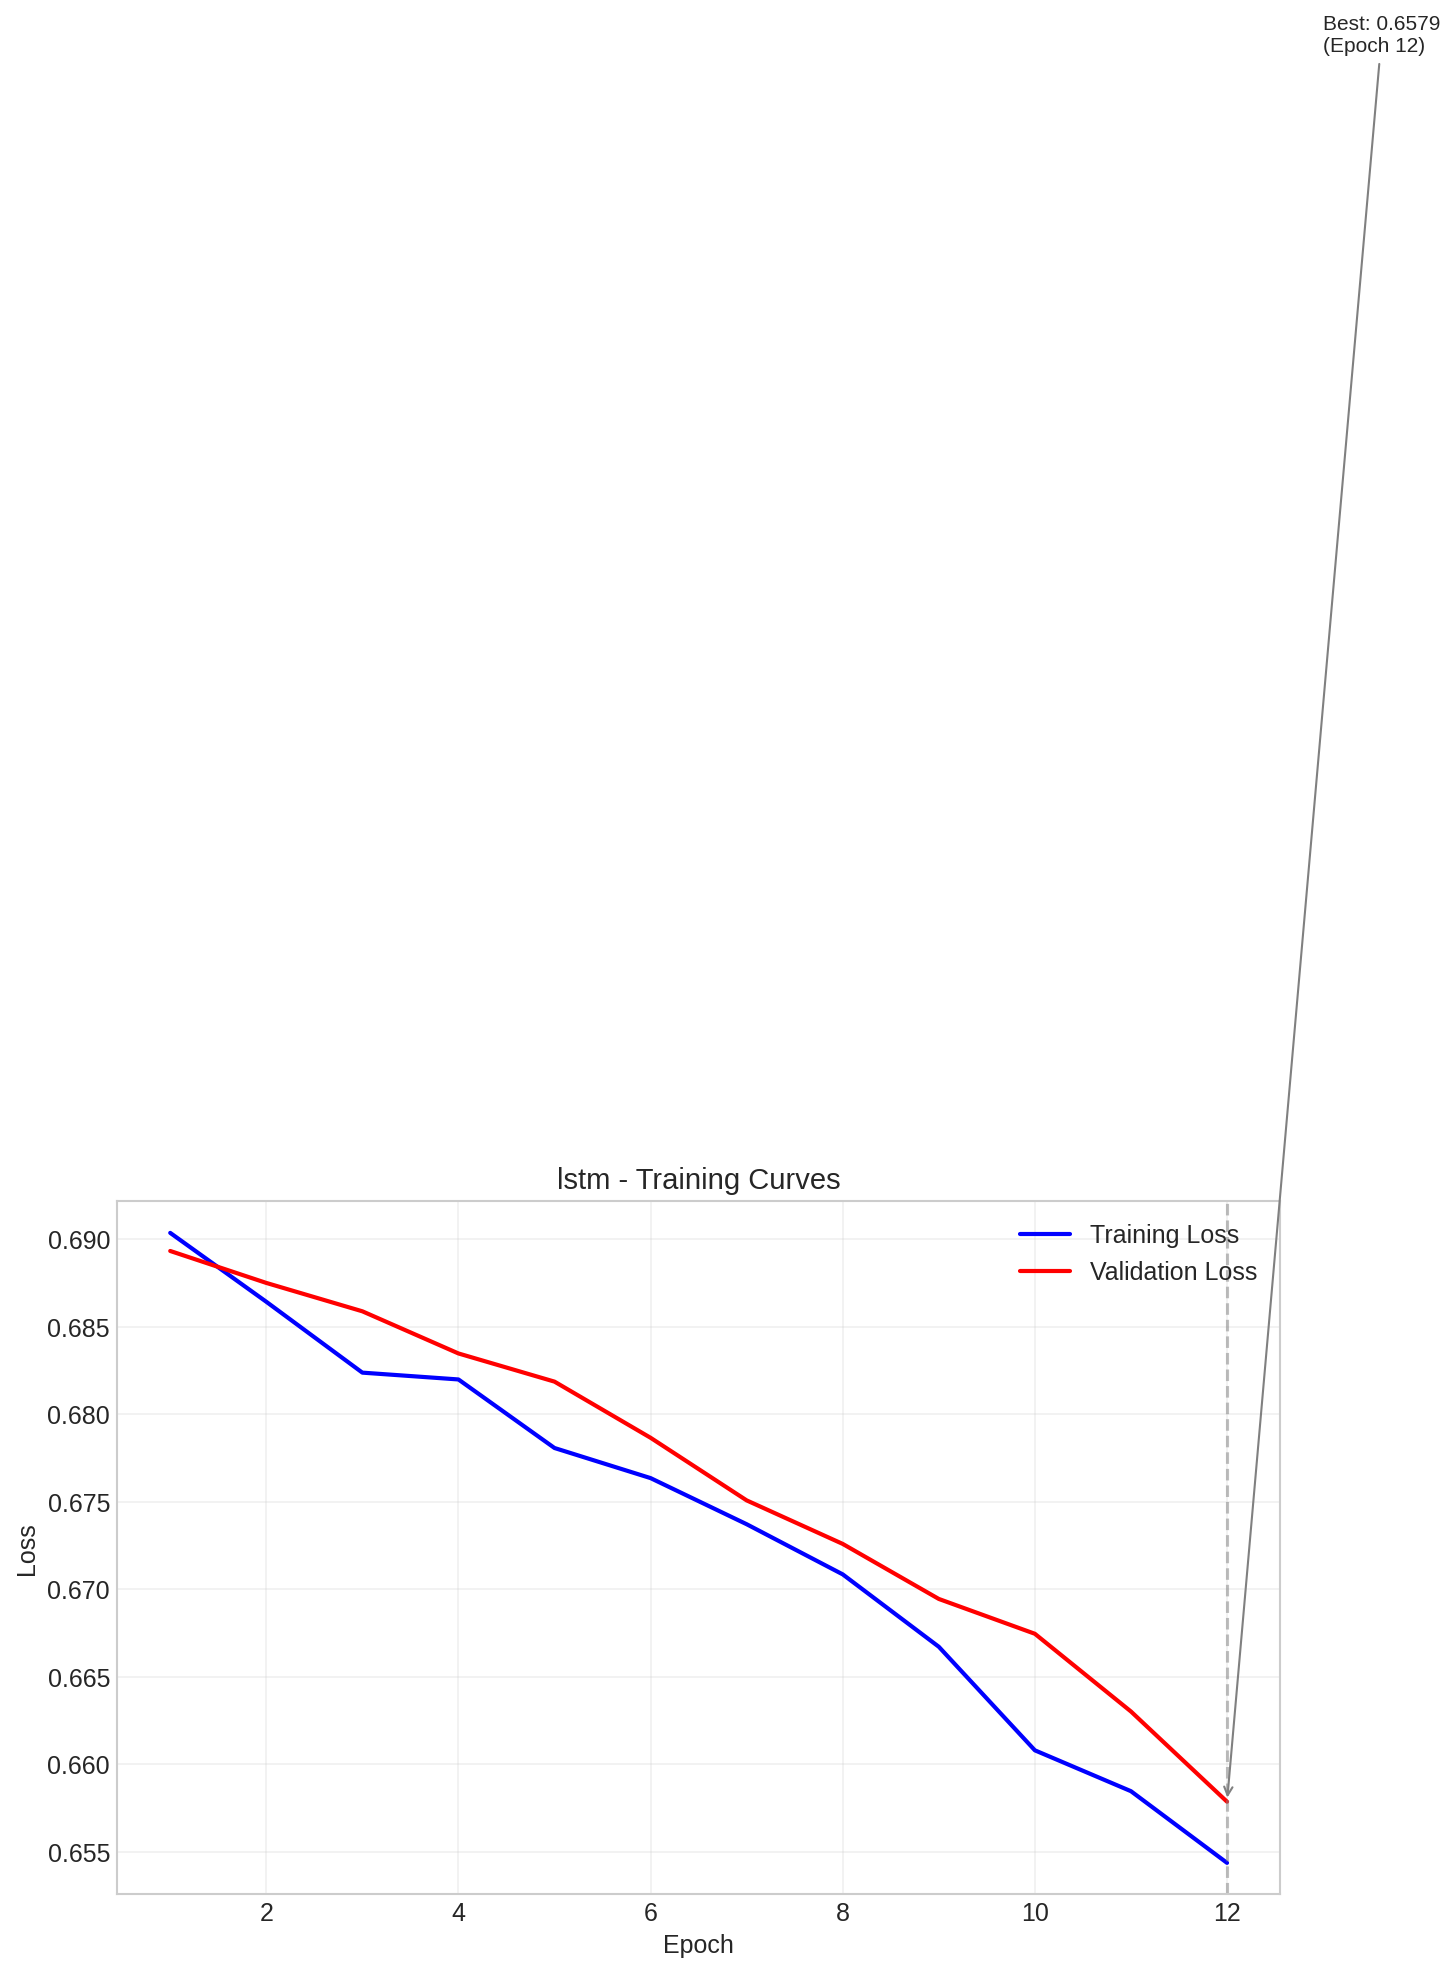


metrics_curves.png:


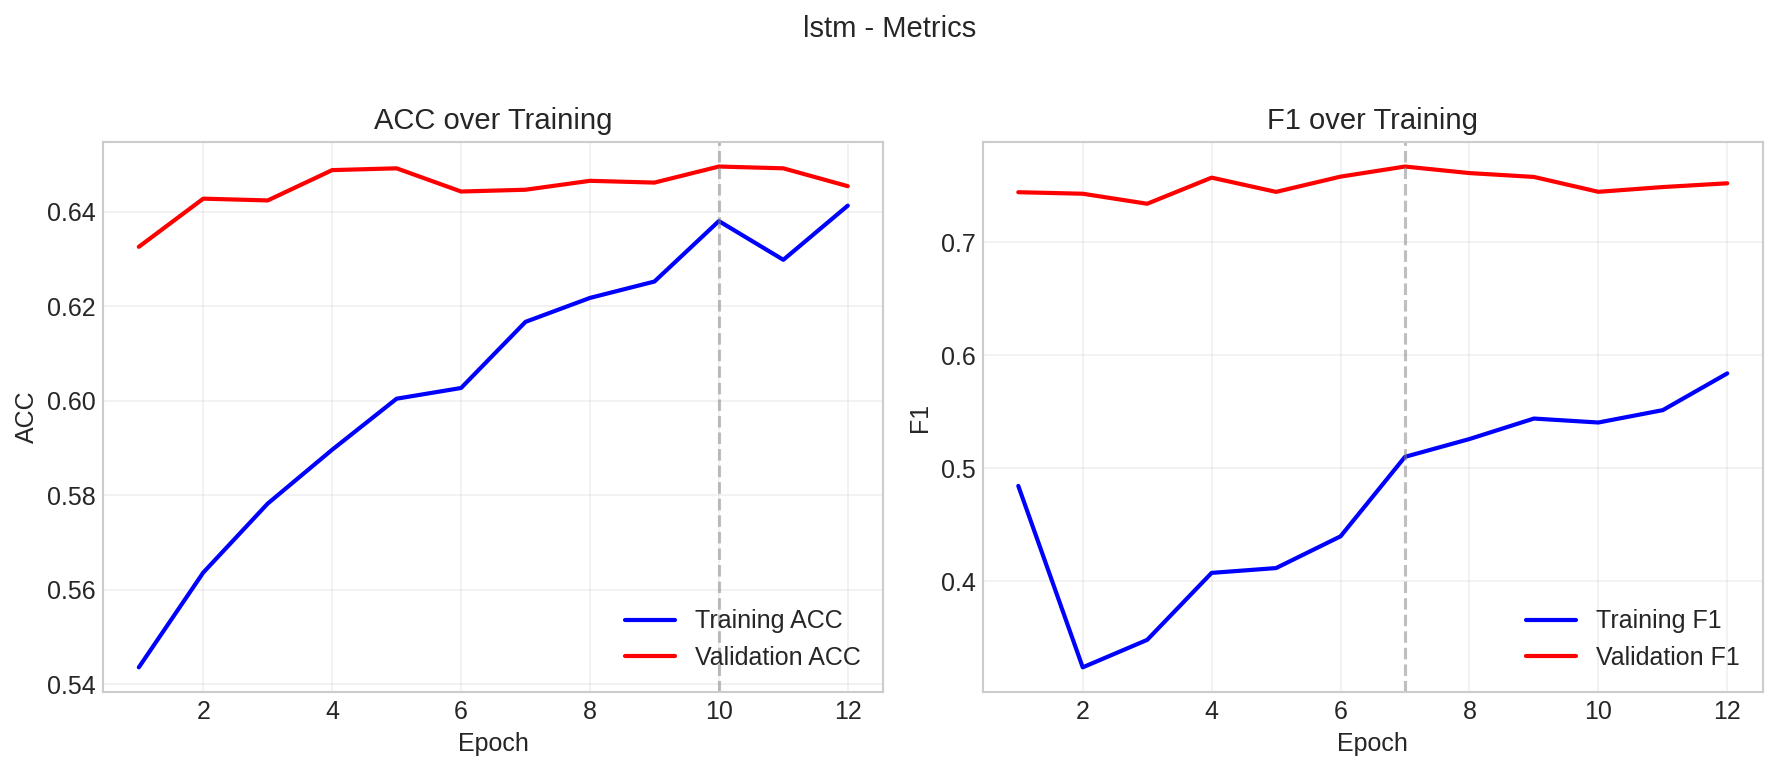


📊 lstm_bi_hd128_nl2_noaug
----------------------------------------

confusion_matrix.png:


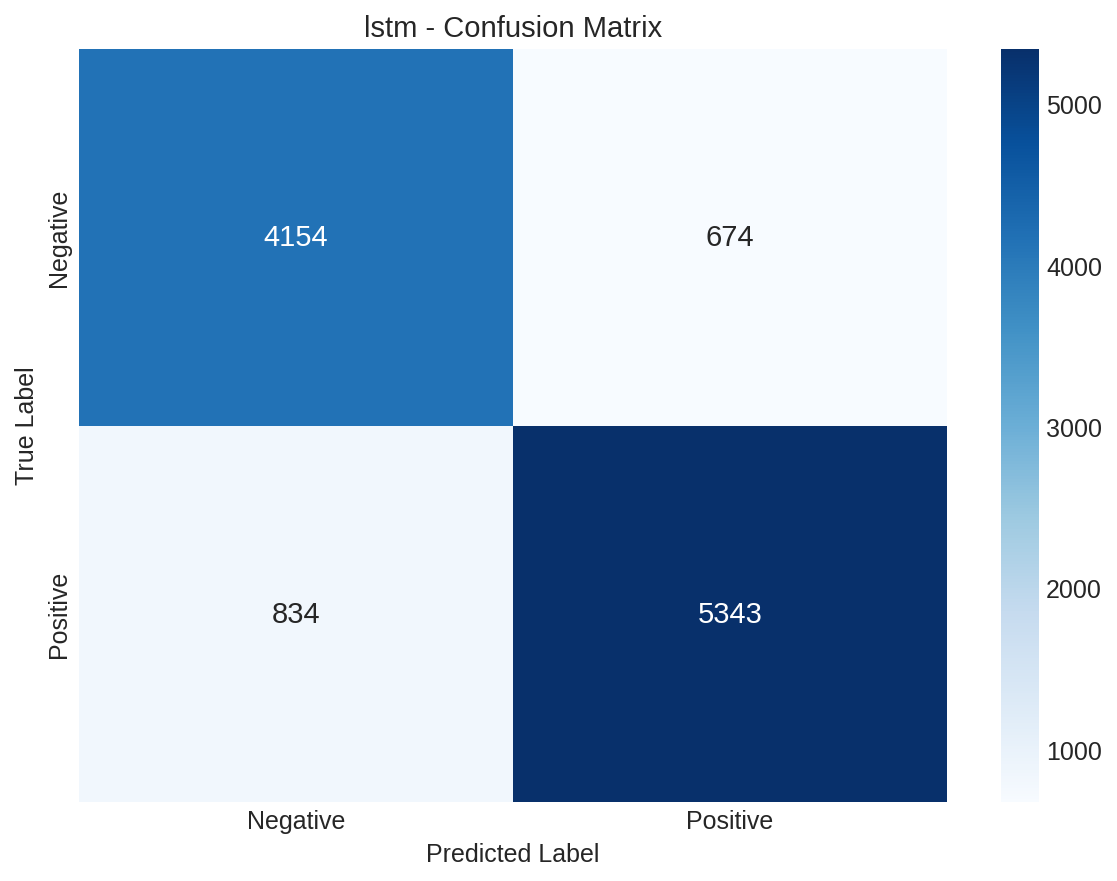


confusion_matrix_normalized.png:


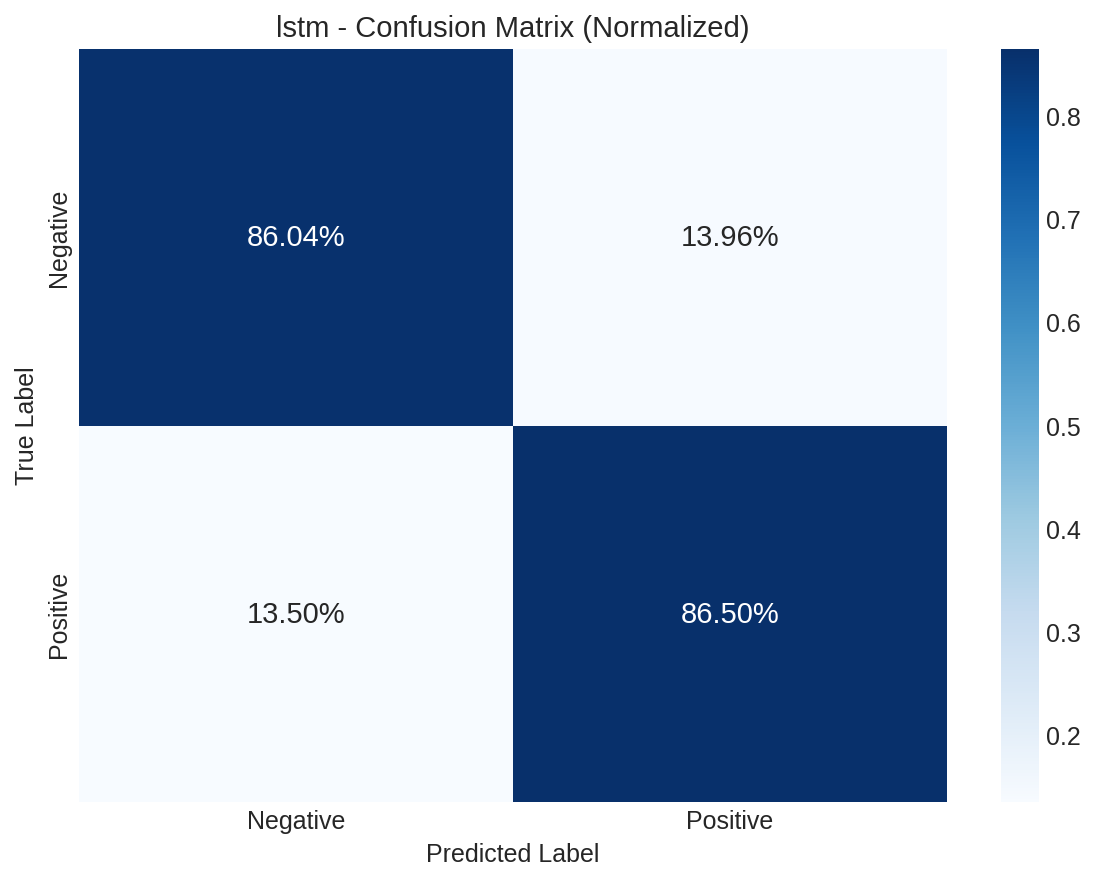


loss_curves.png:


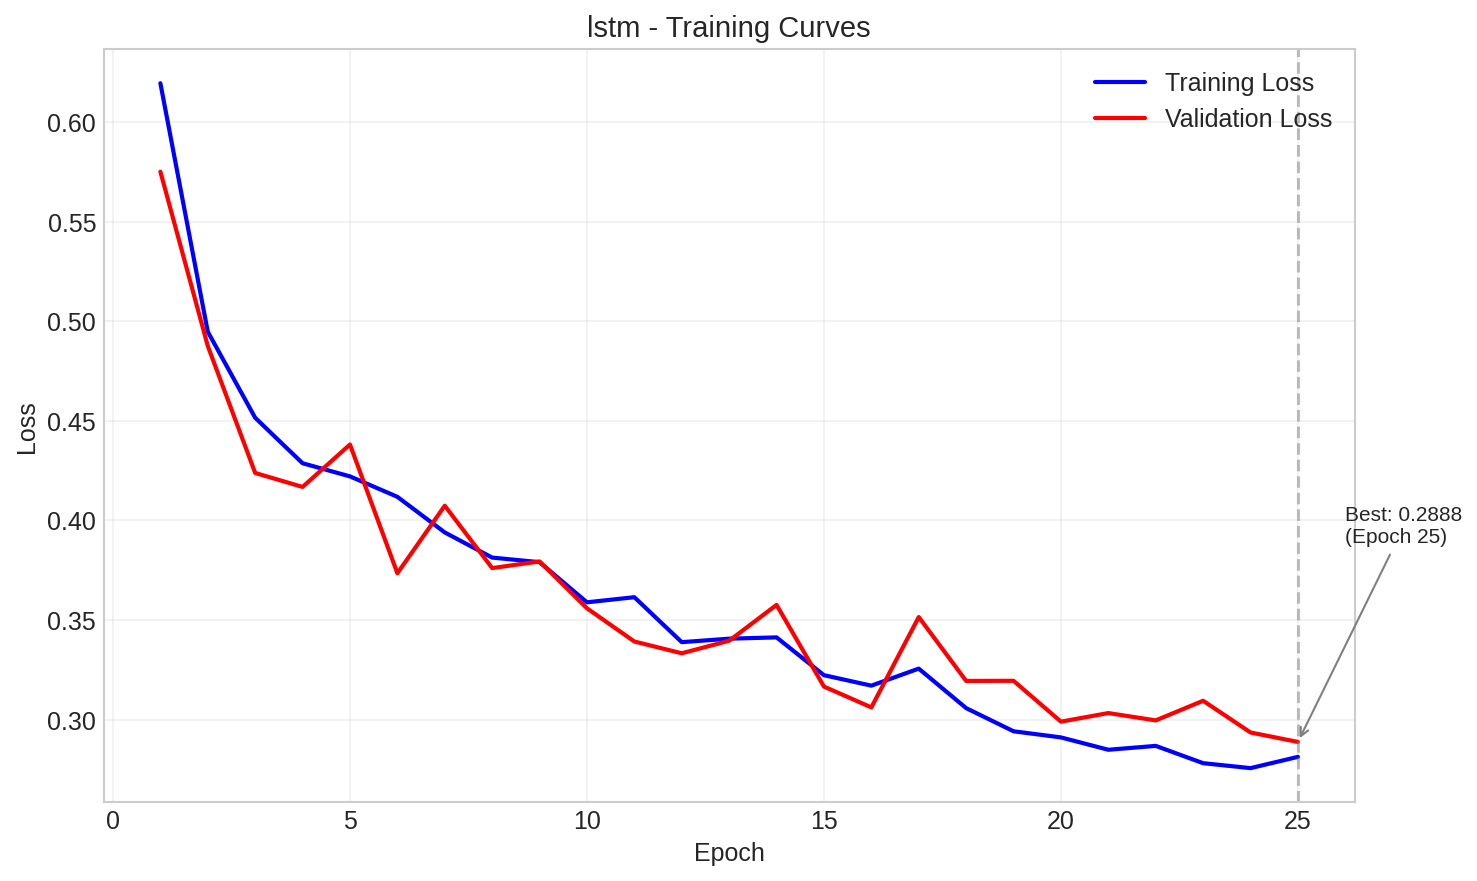


metrics_curves.png:


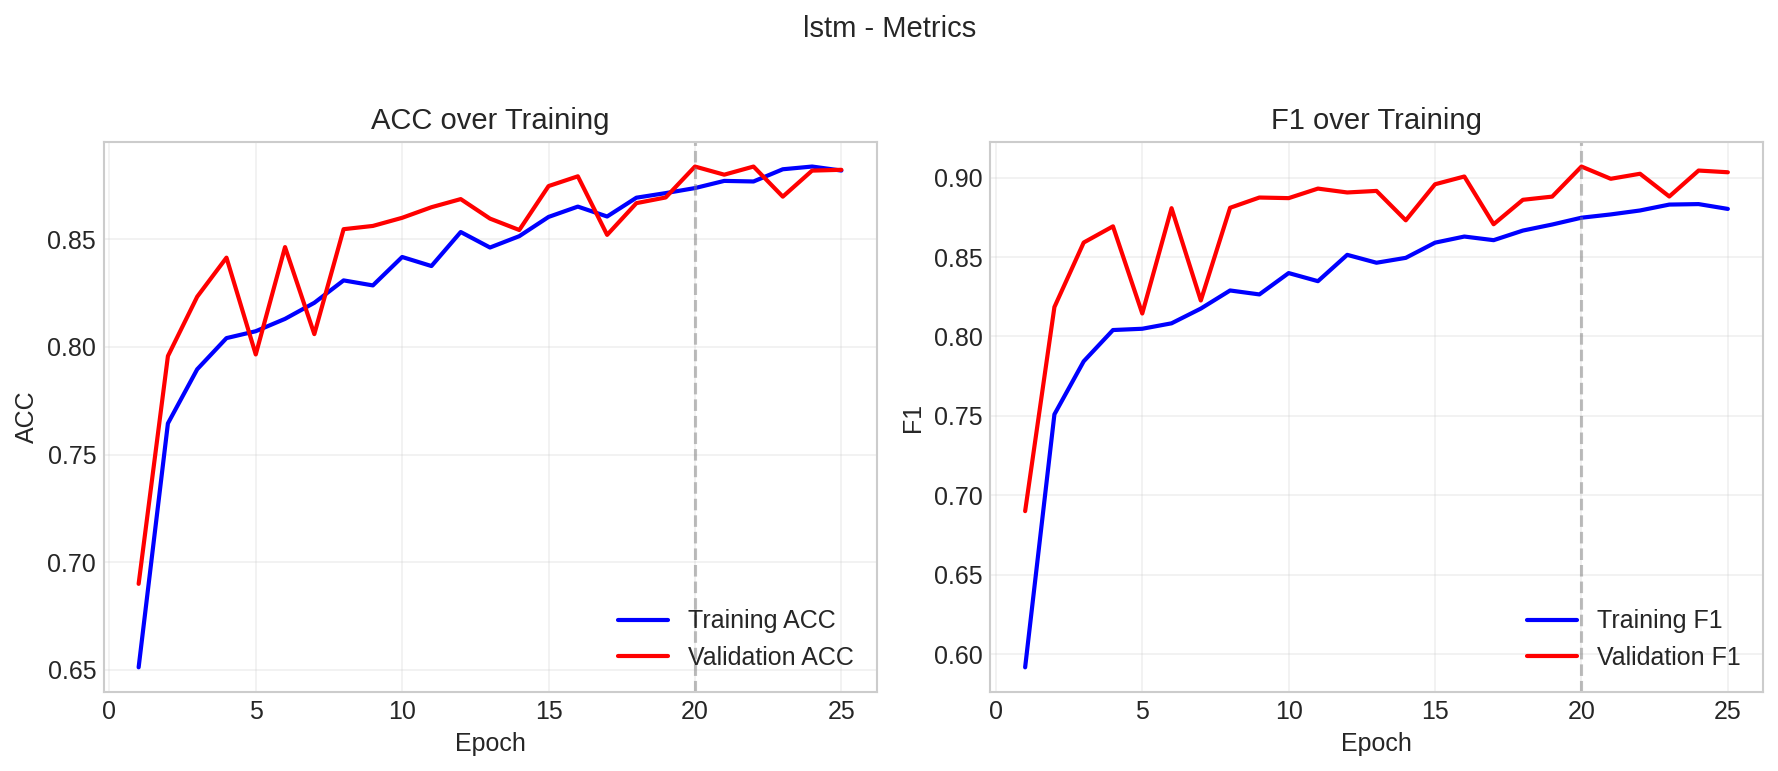


📊 lstm_bi_noaug
----------------------------------------

confusion_matrix.png:


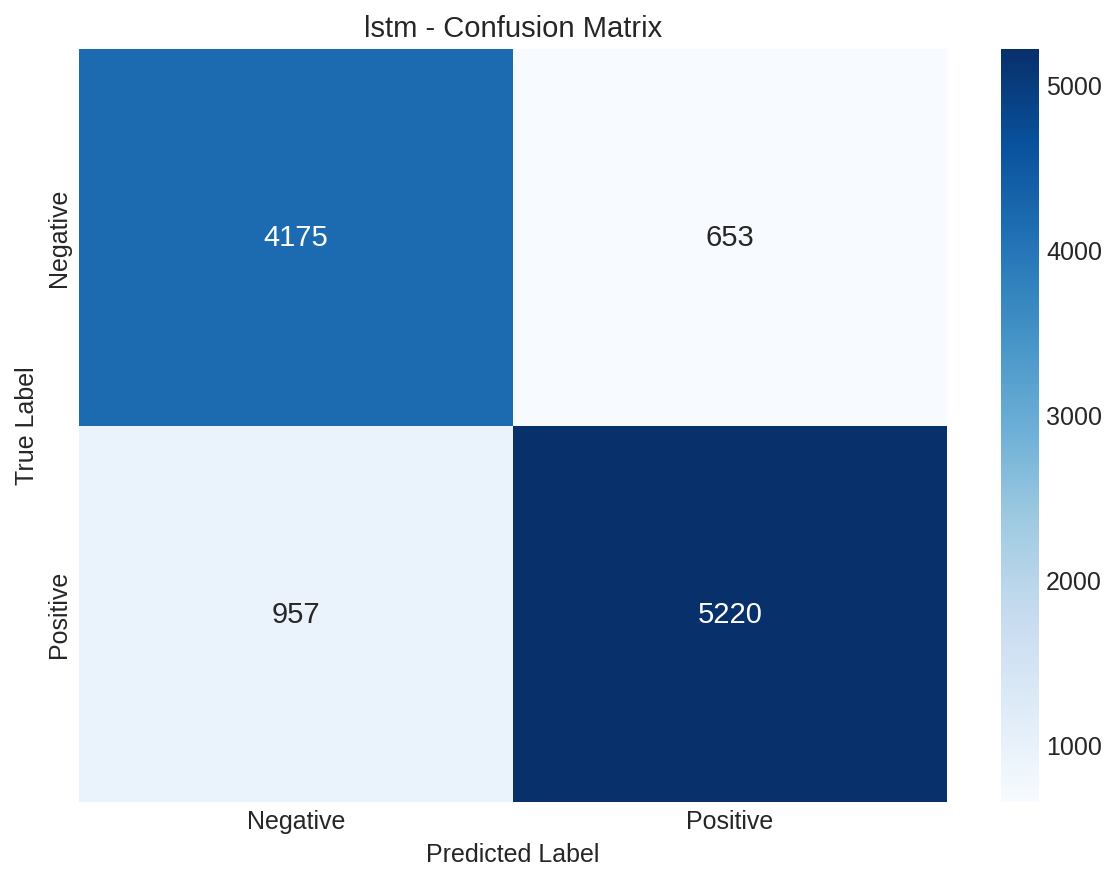


confusion_matrix_normalized.png:


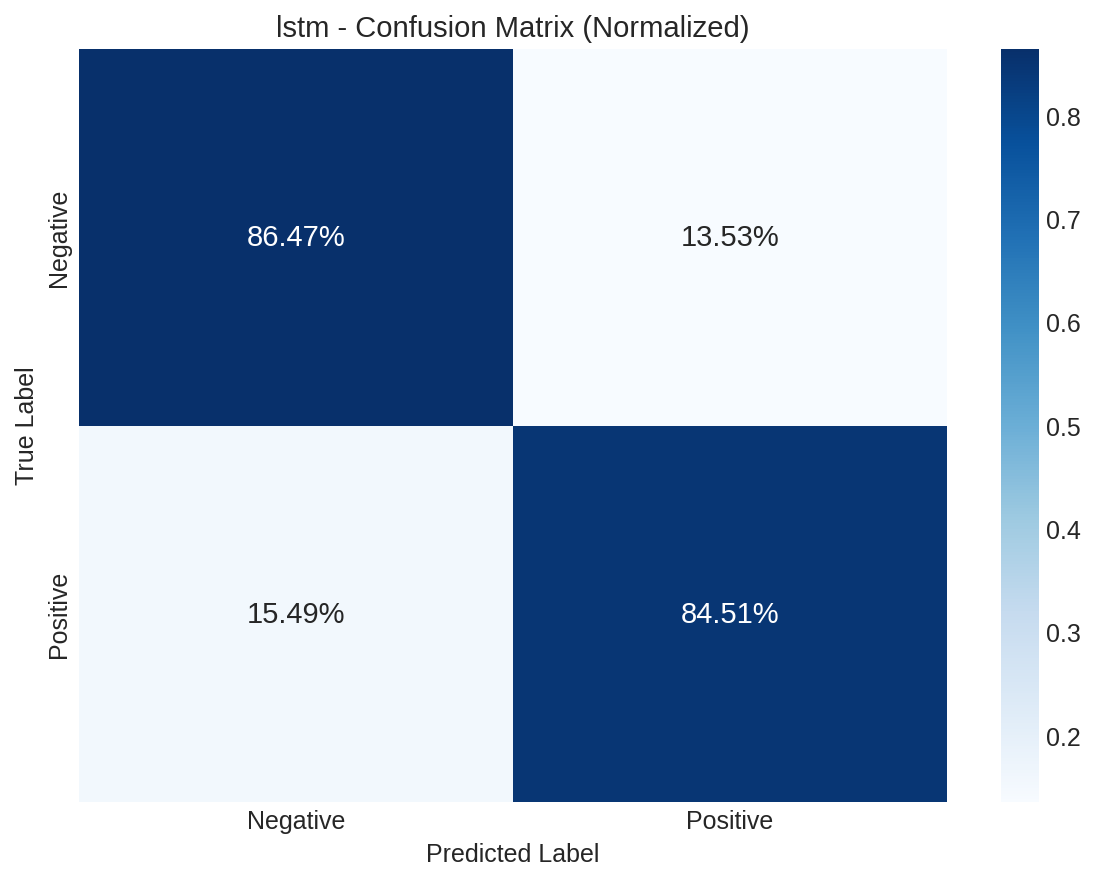


loss_curves.png:


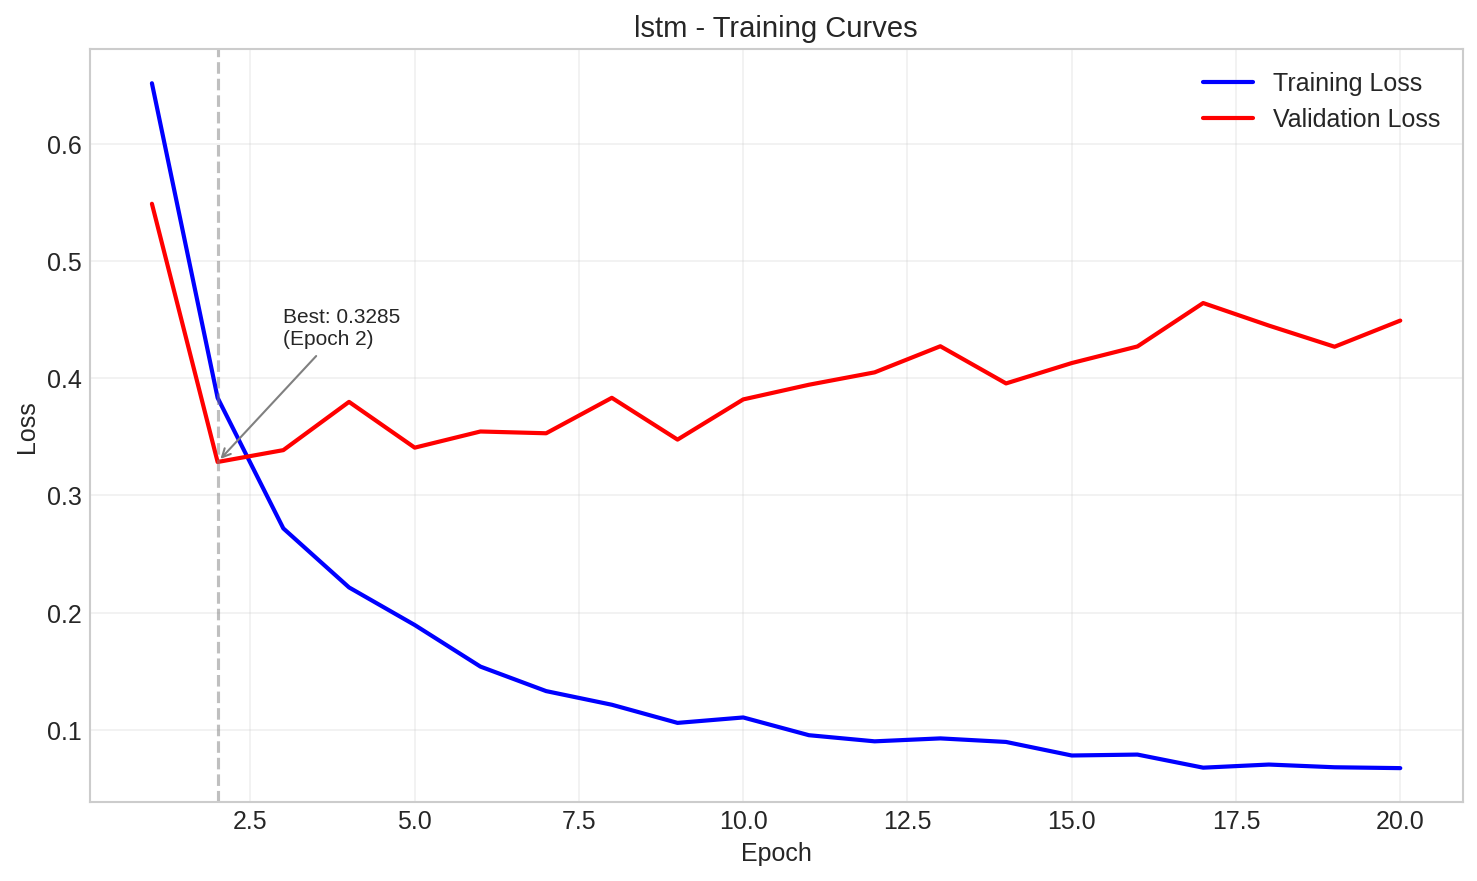


metrics_curves.png:


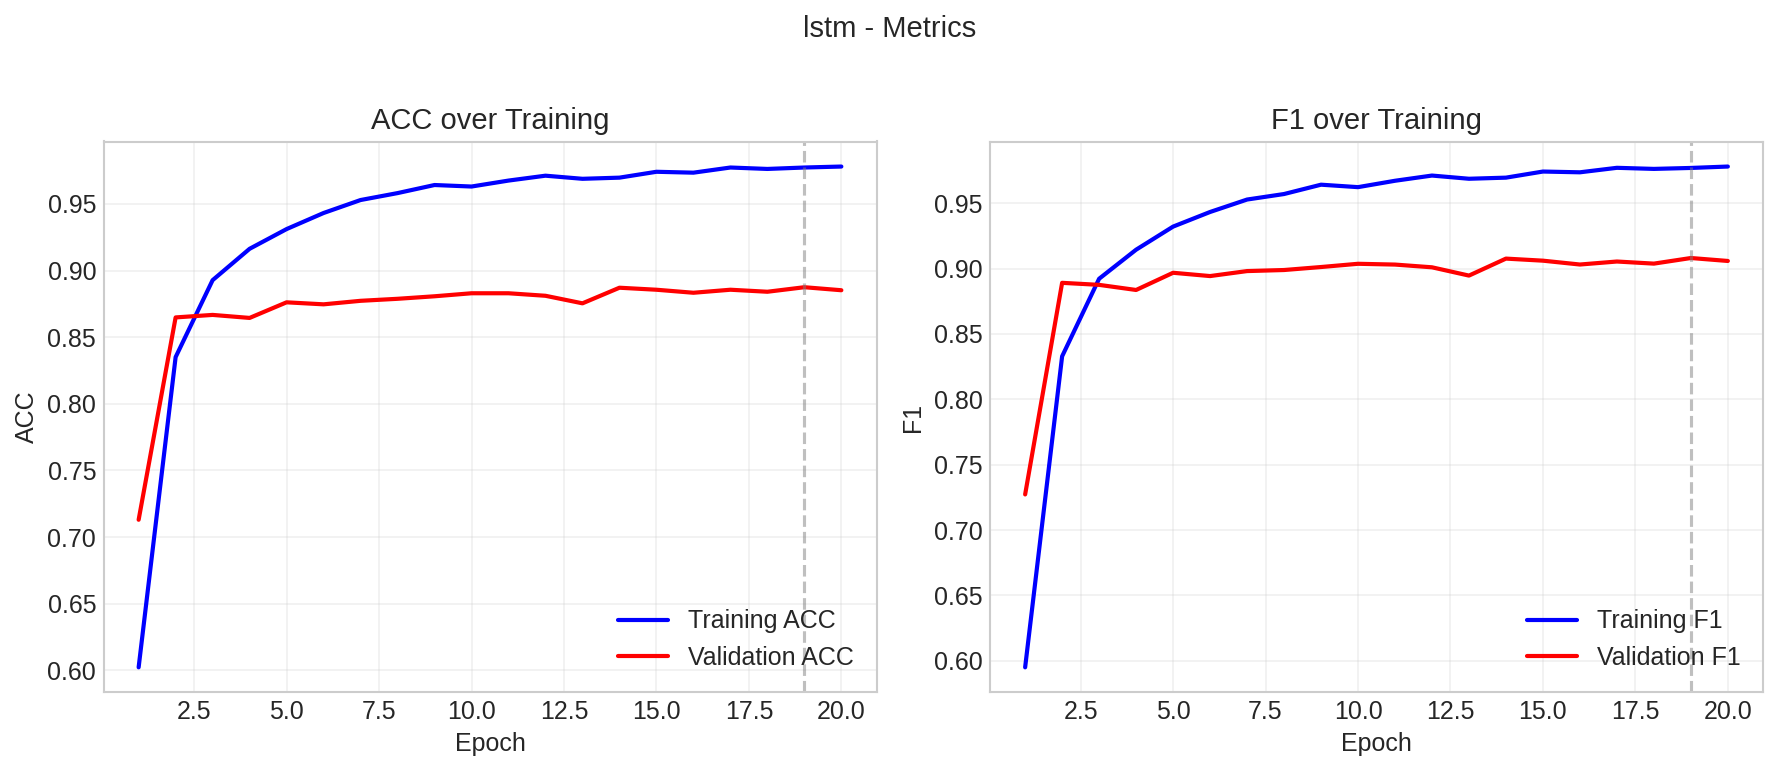


📊 simple_rnn_bi_eda
----------------------------------------

confusion_matrix.png:


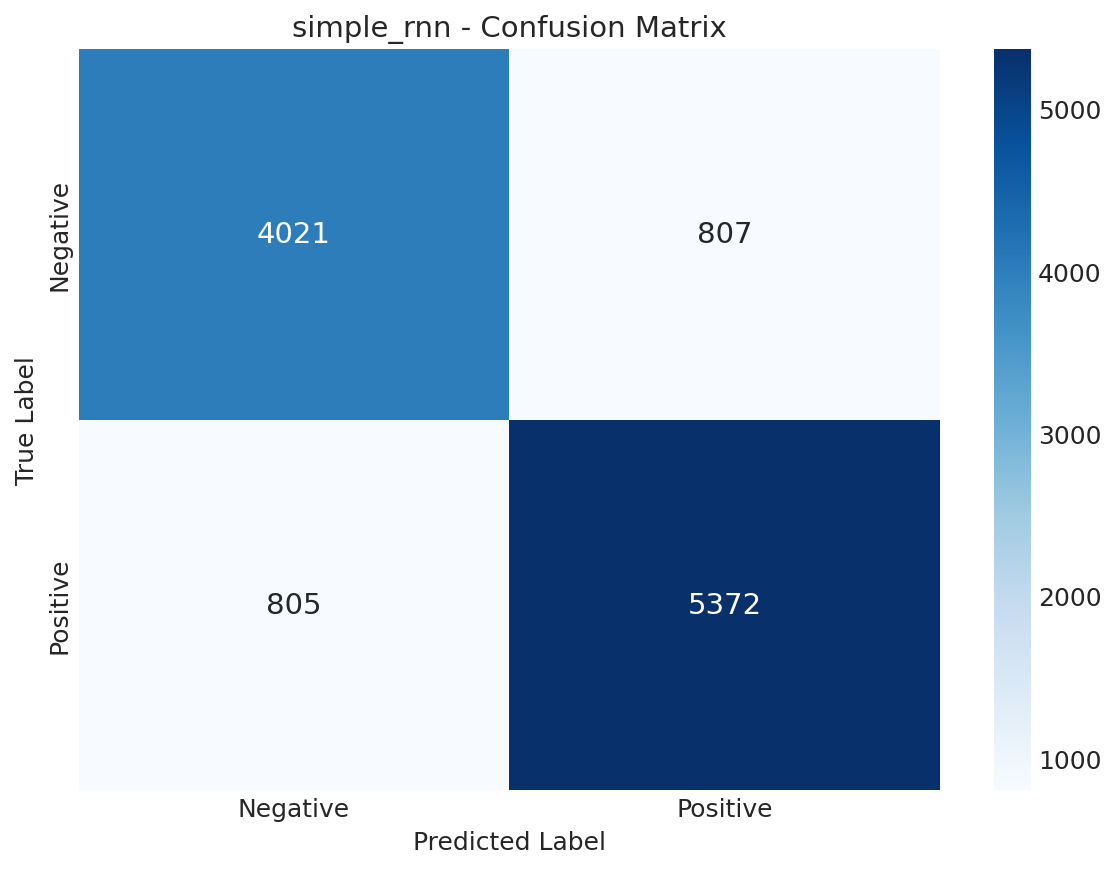


confusion_matrix_normalized.png:


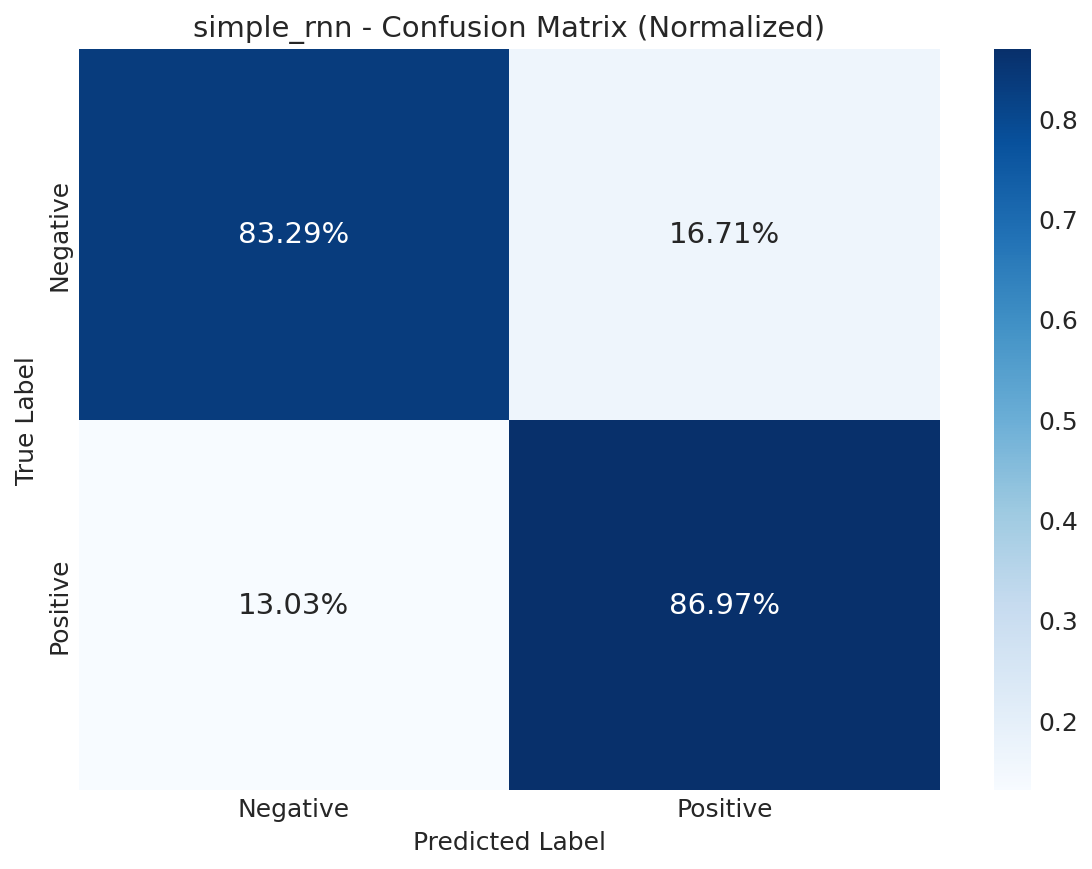


loss_curves.png:


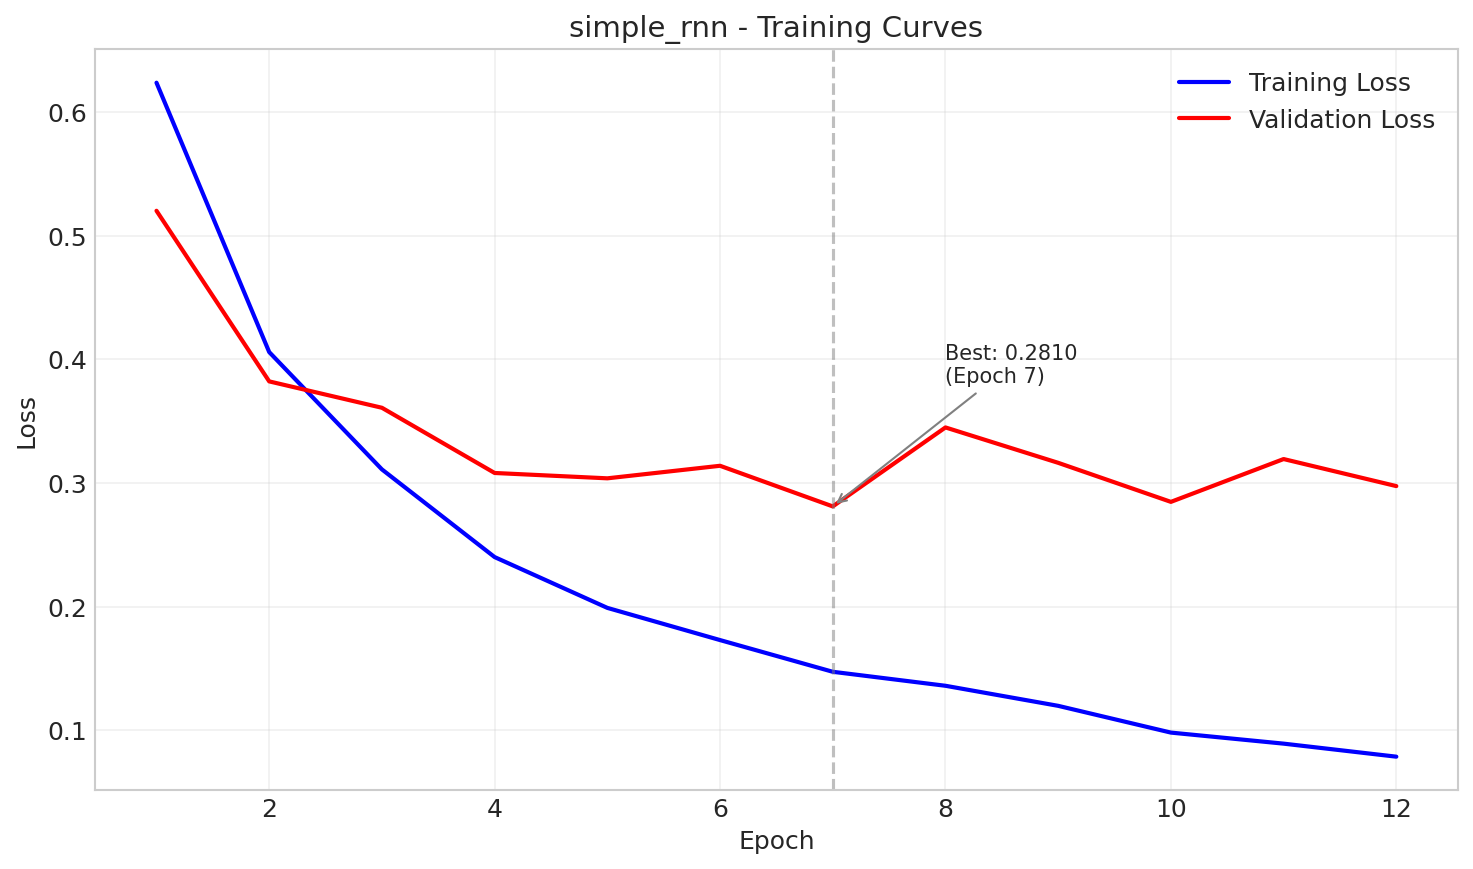


metrics_curves.png:


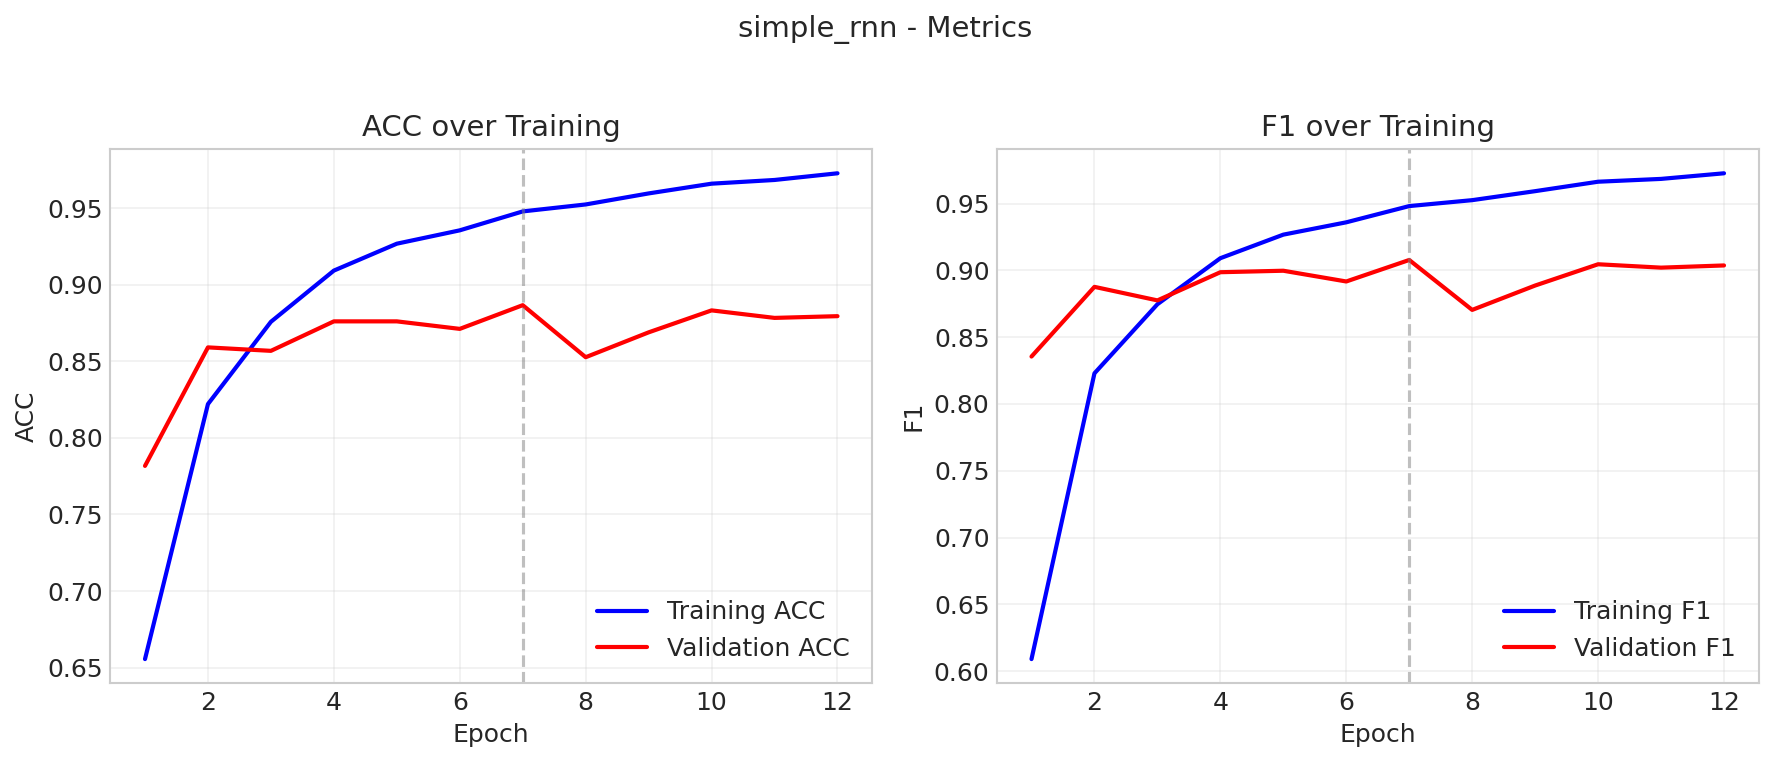


📊 simple_rnn_bi_eda_plus_p0.3
----------------------------------------

confusion_matrix.png:


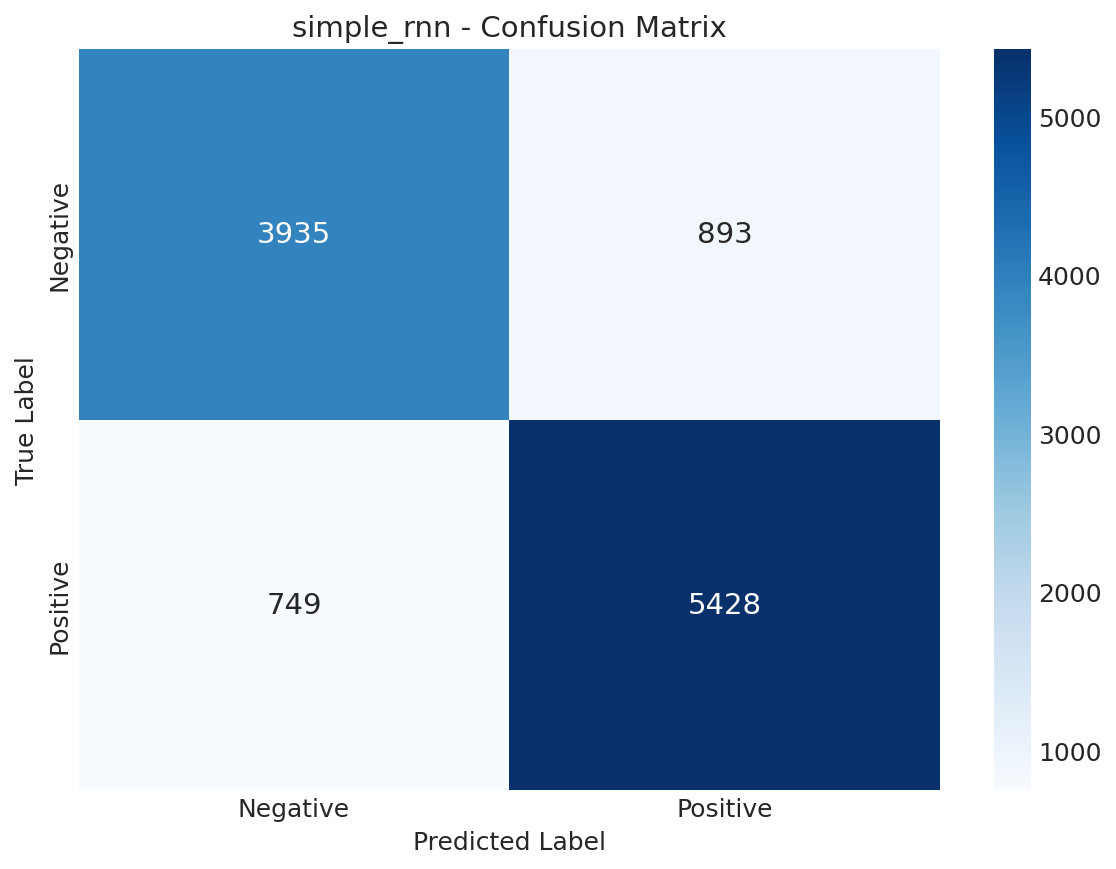


confusion_matrix_normalized.png:


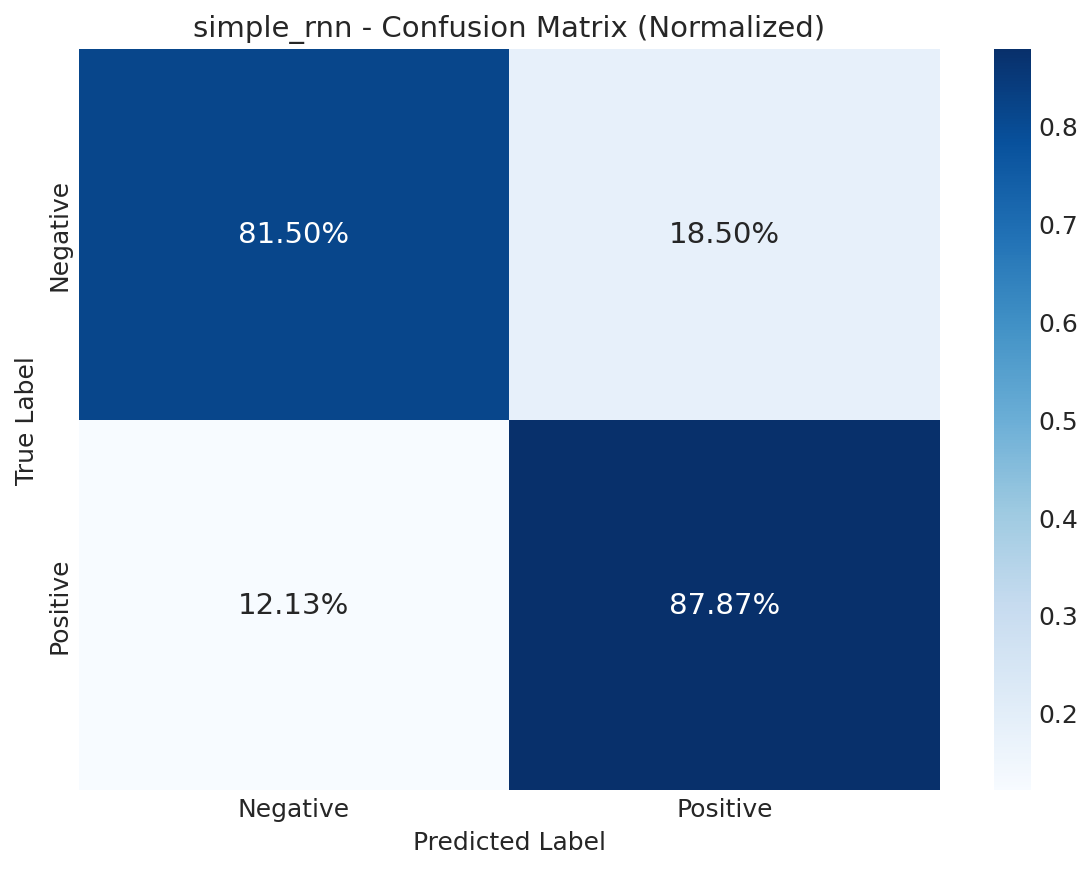


loss_curves.png:


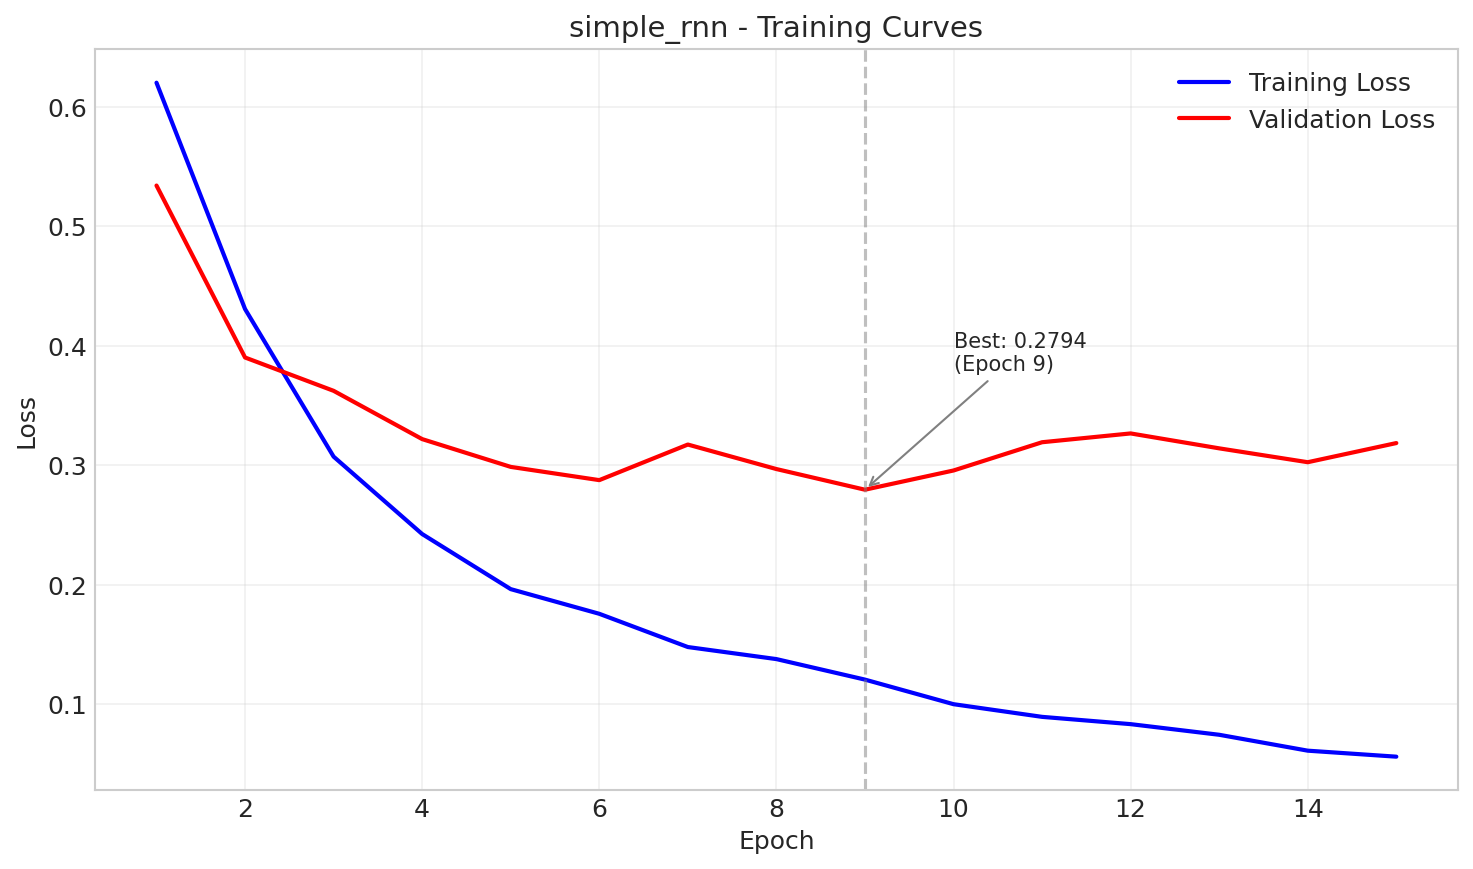


metrics_curves.png:


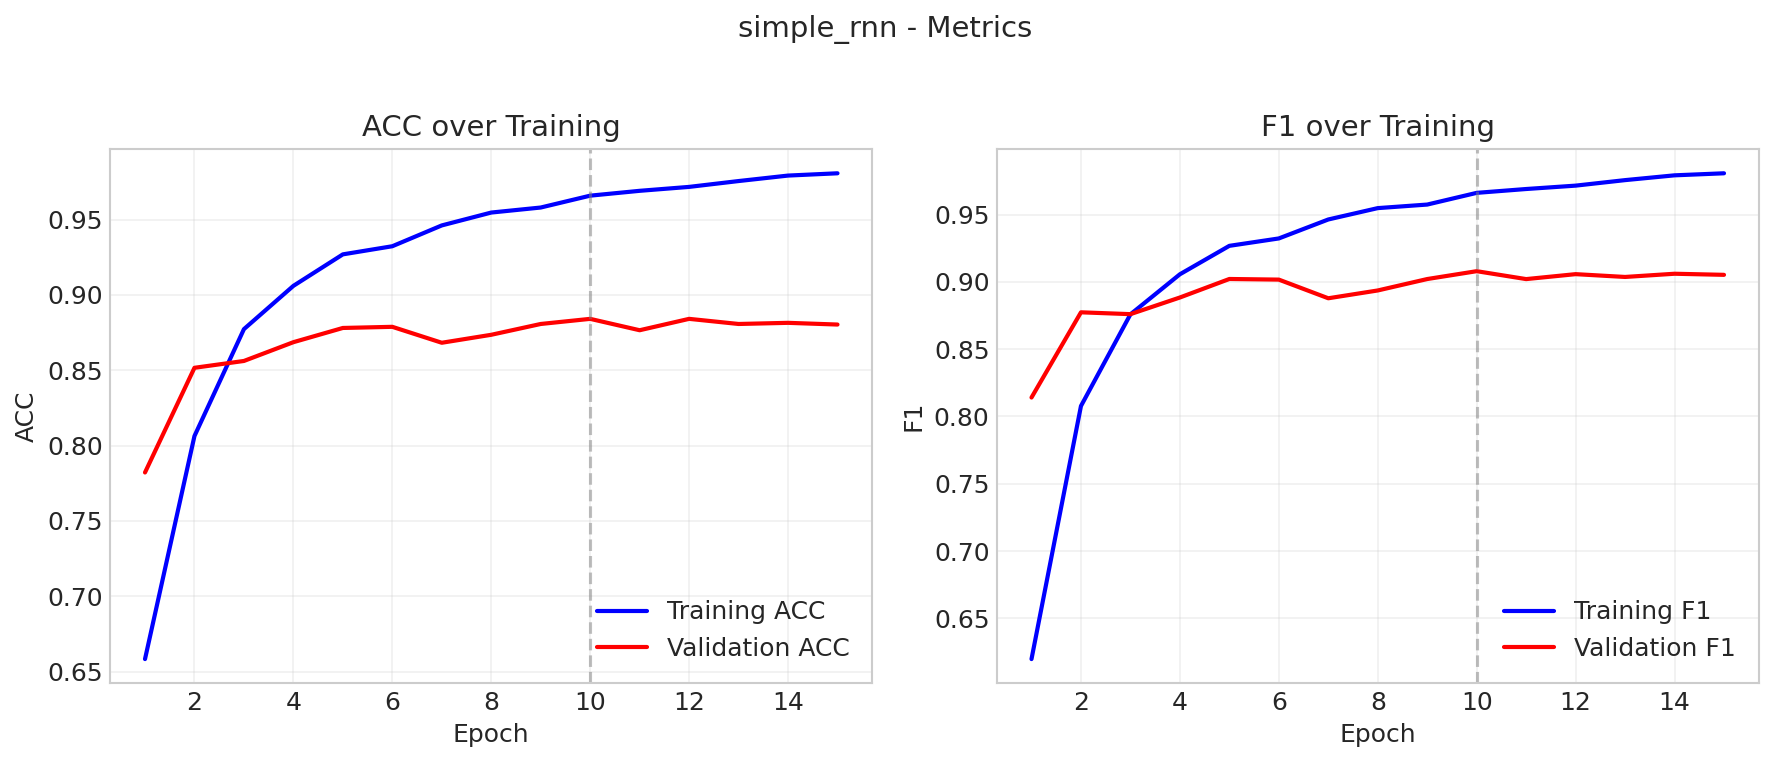


📊 simple_rnn_bi_hd128_nl1_finetune_noaug
----------------------------------------

confusion_matrix.png:


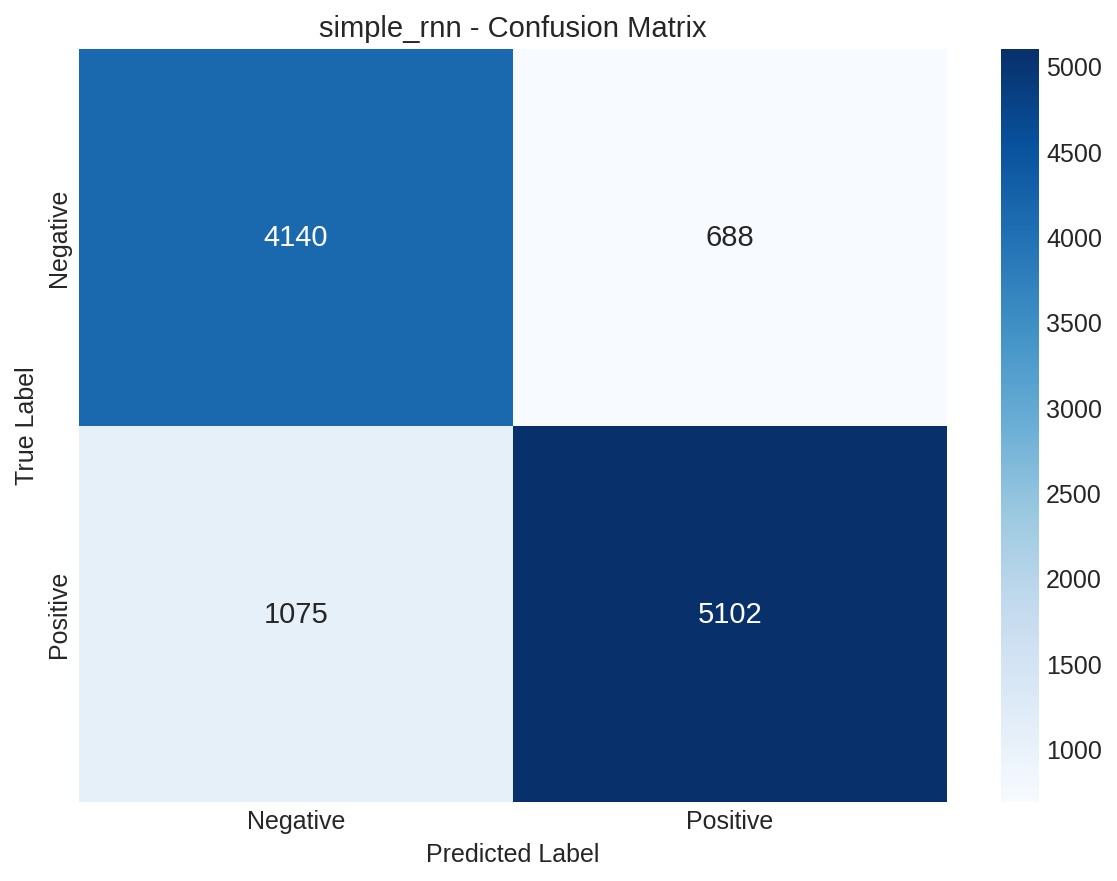


confusion_matrix_normalized.png:


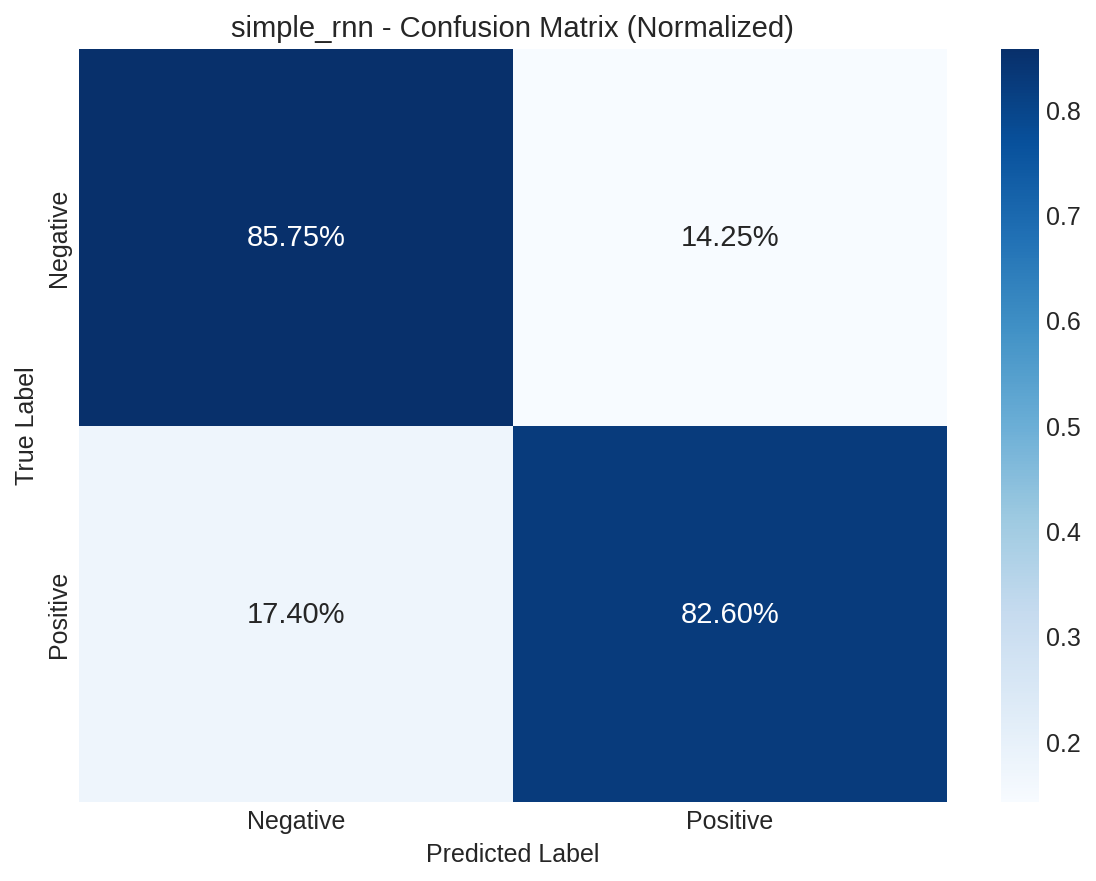


loss_curves.png:


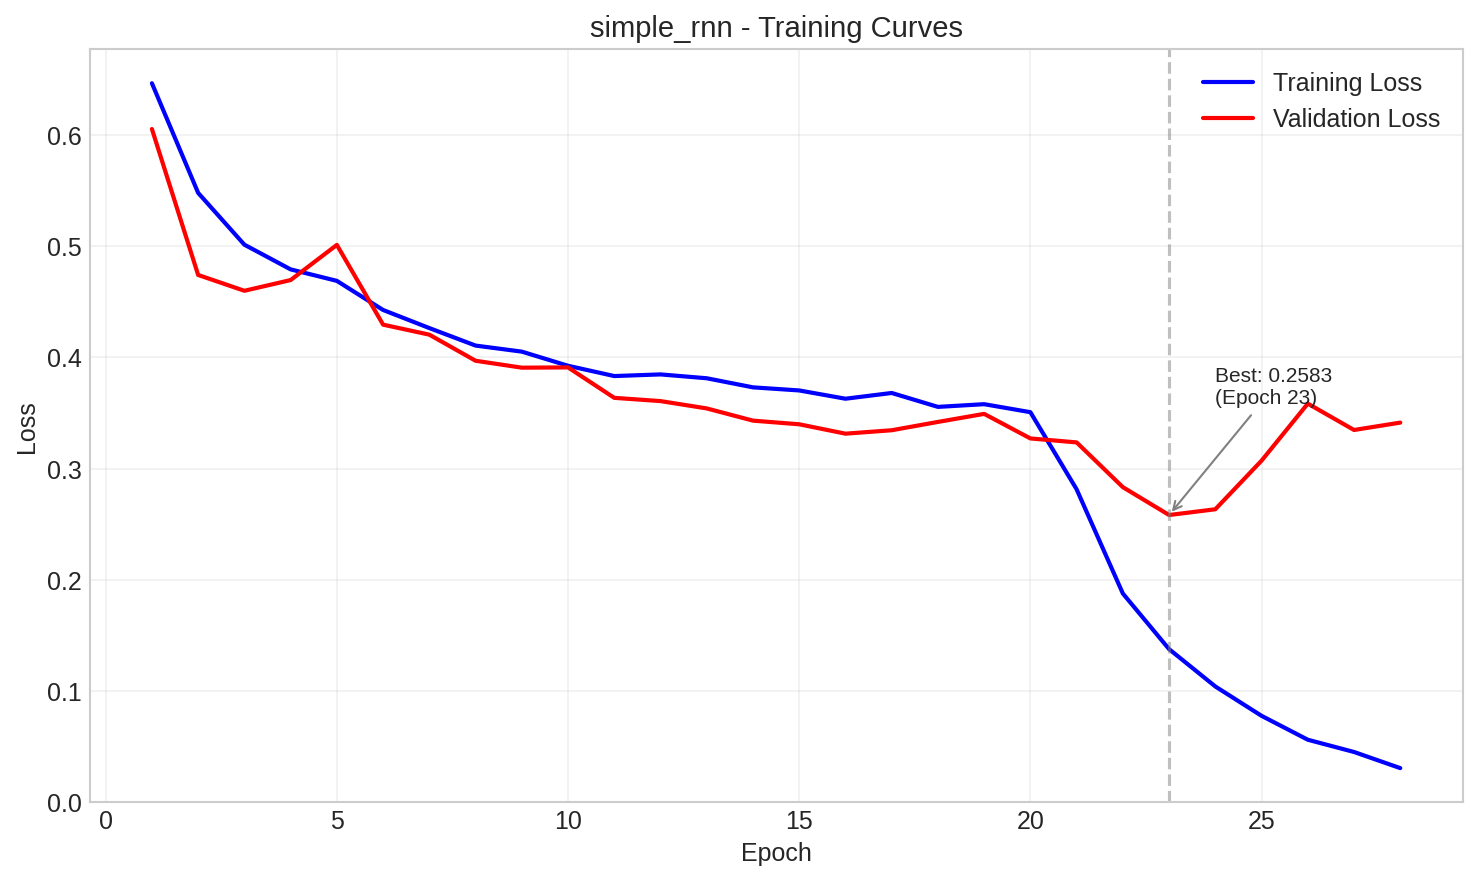


metrics_curves.png:


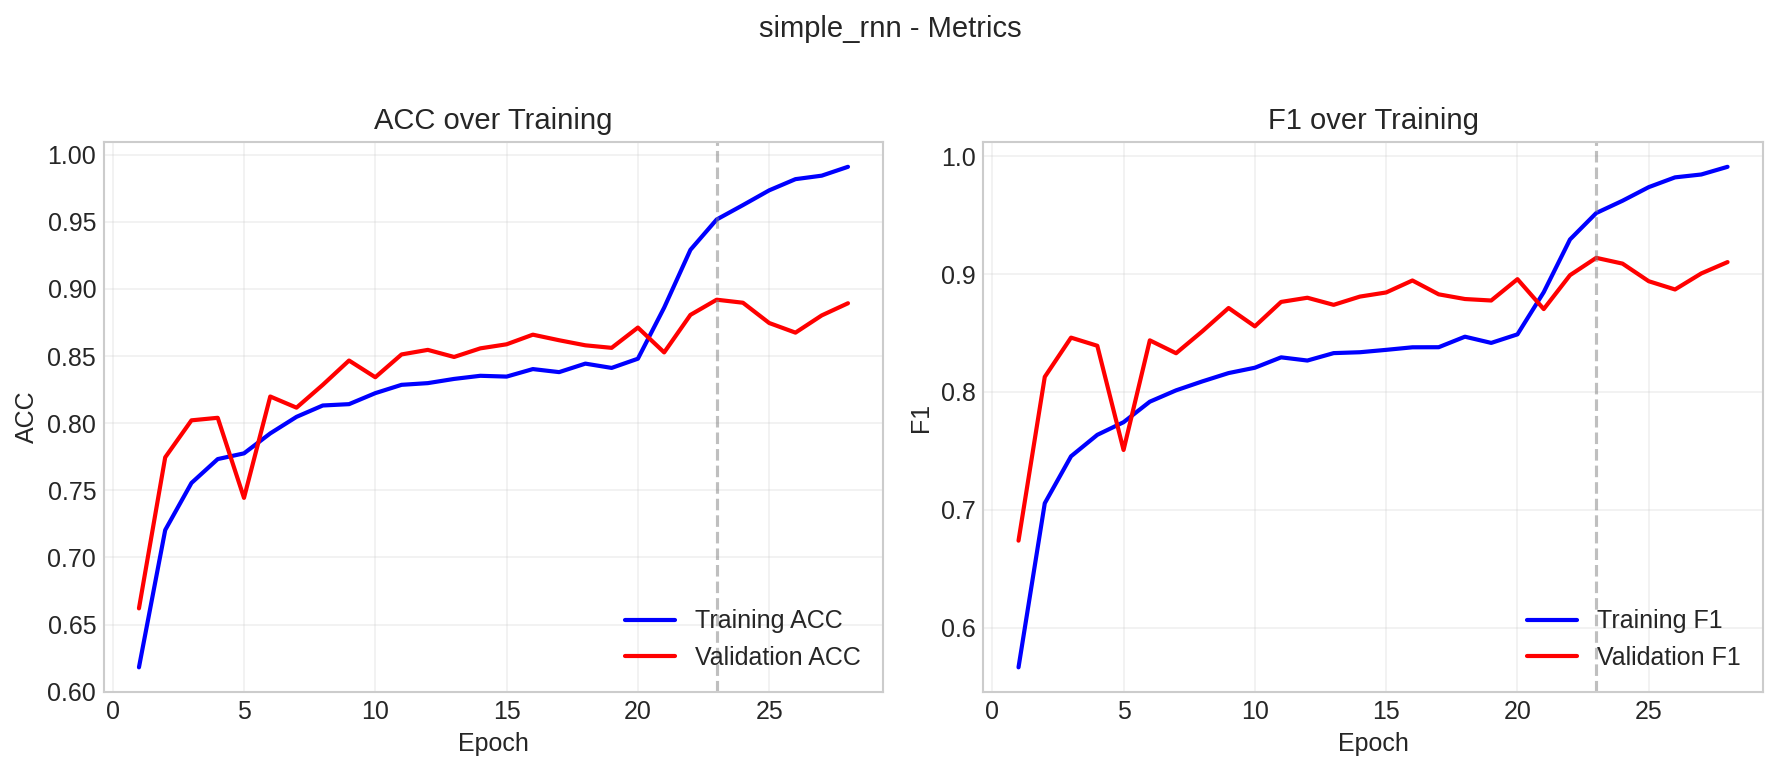


📊 simple_rnn_bi_hd128_nl1_noaug
----------------------------------------

confusion_matrix.png:


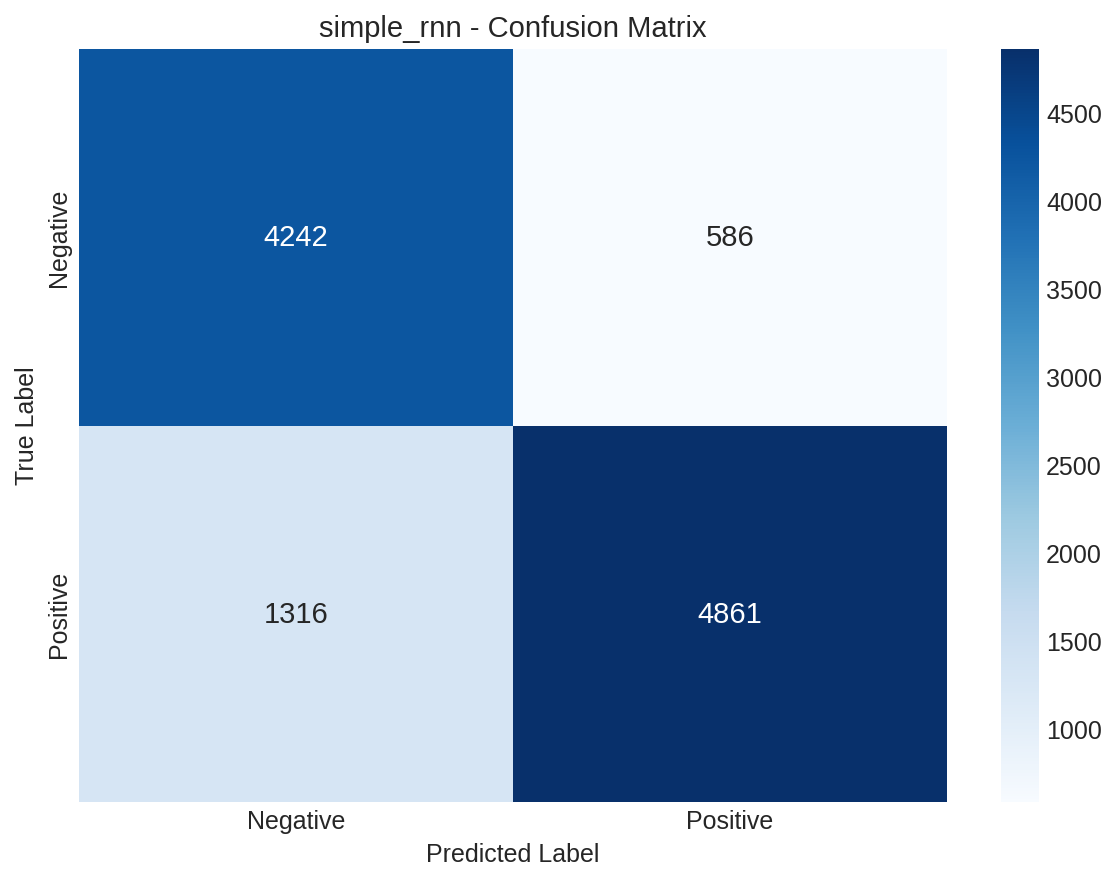


confusion_matrix_normalized.png:


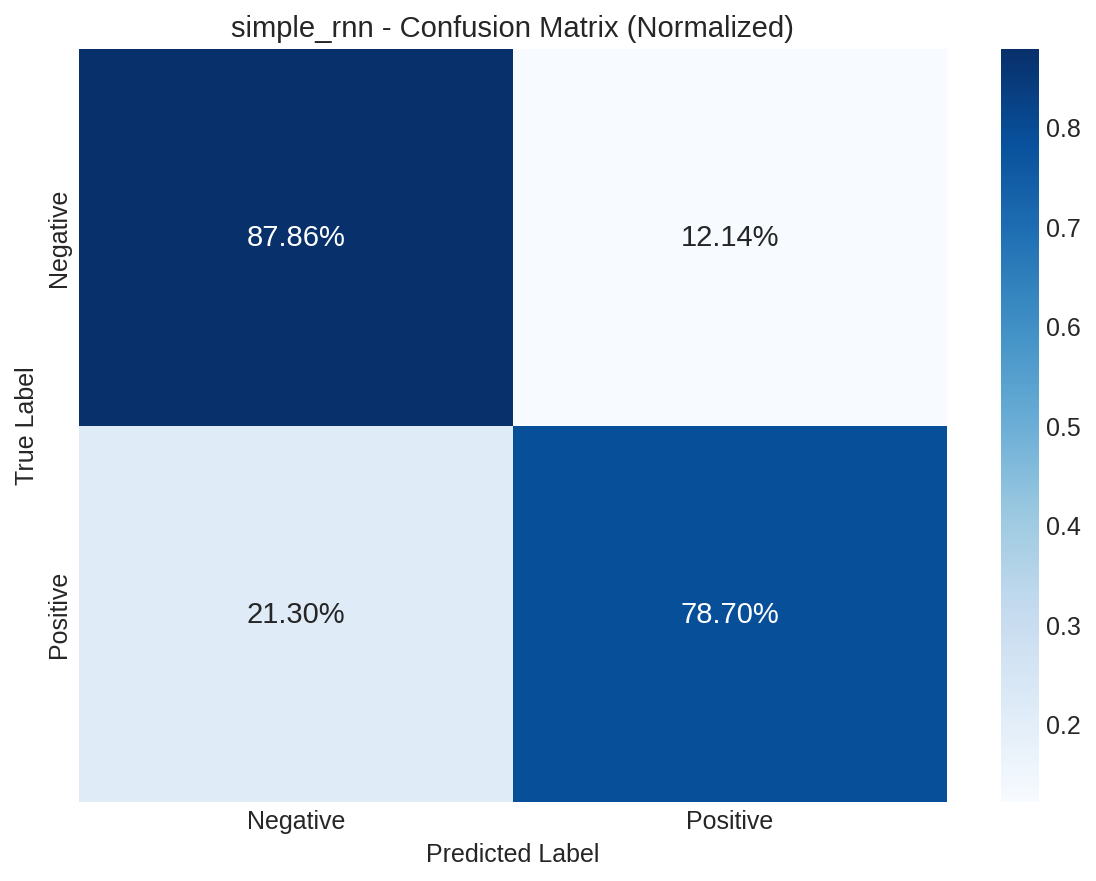


loss_curves.png:


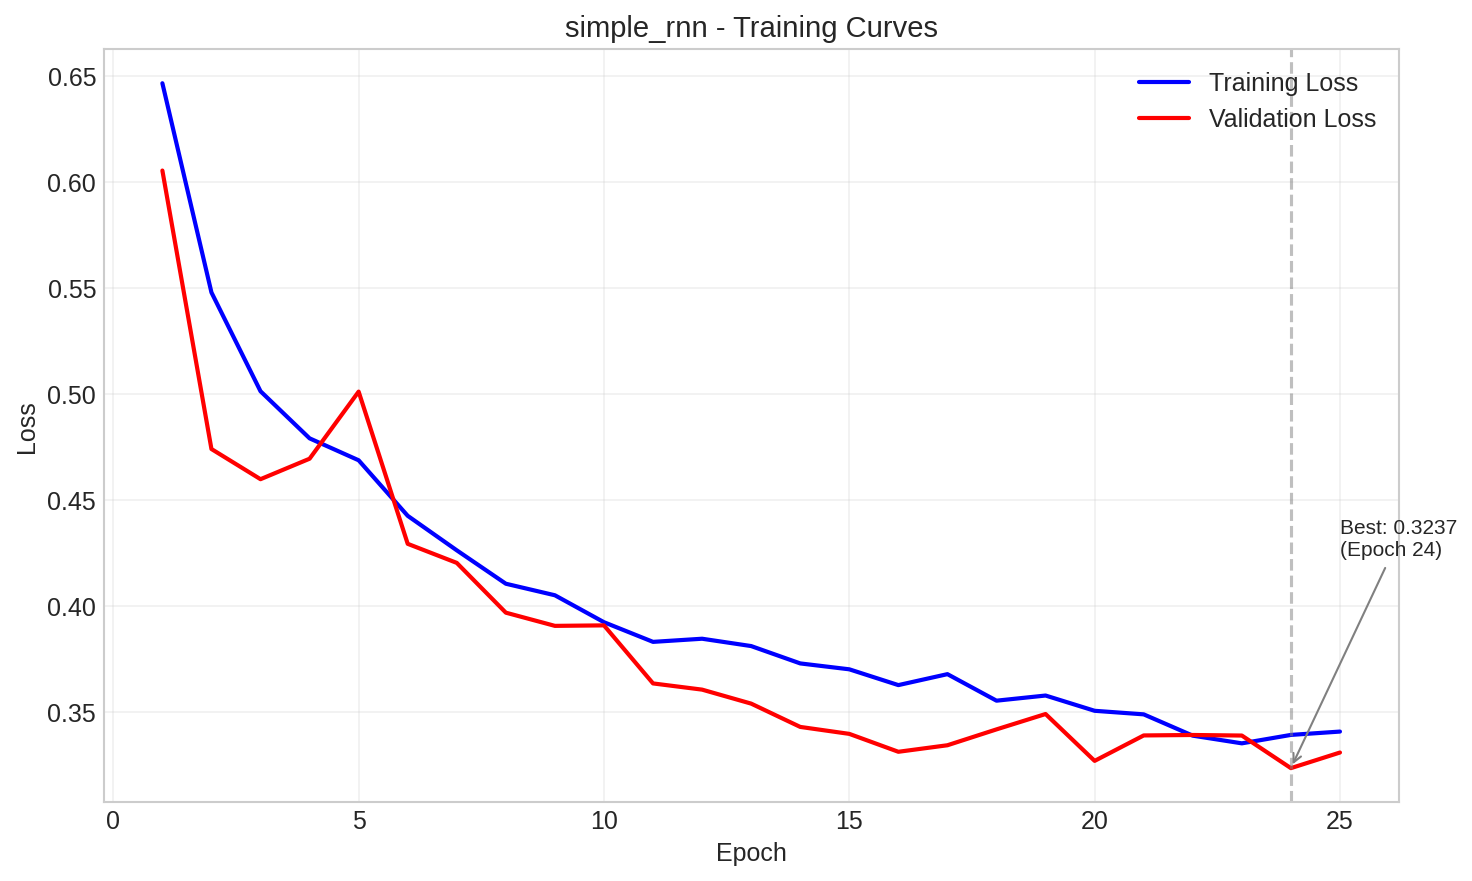


metrics_curves.png:


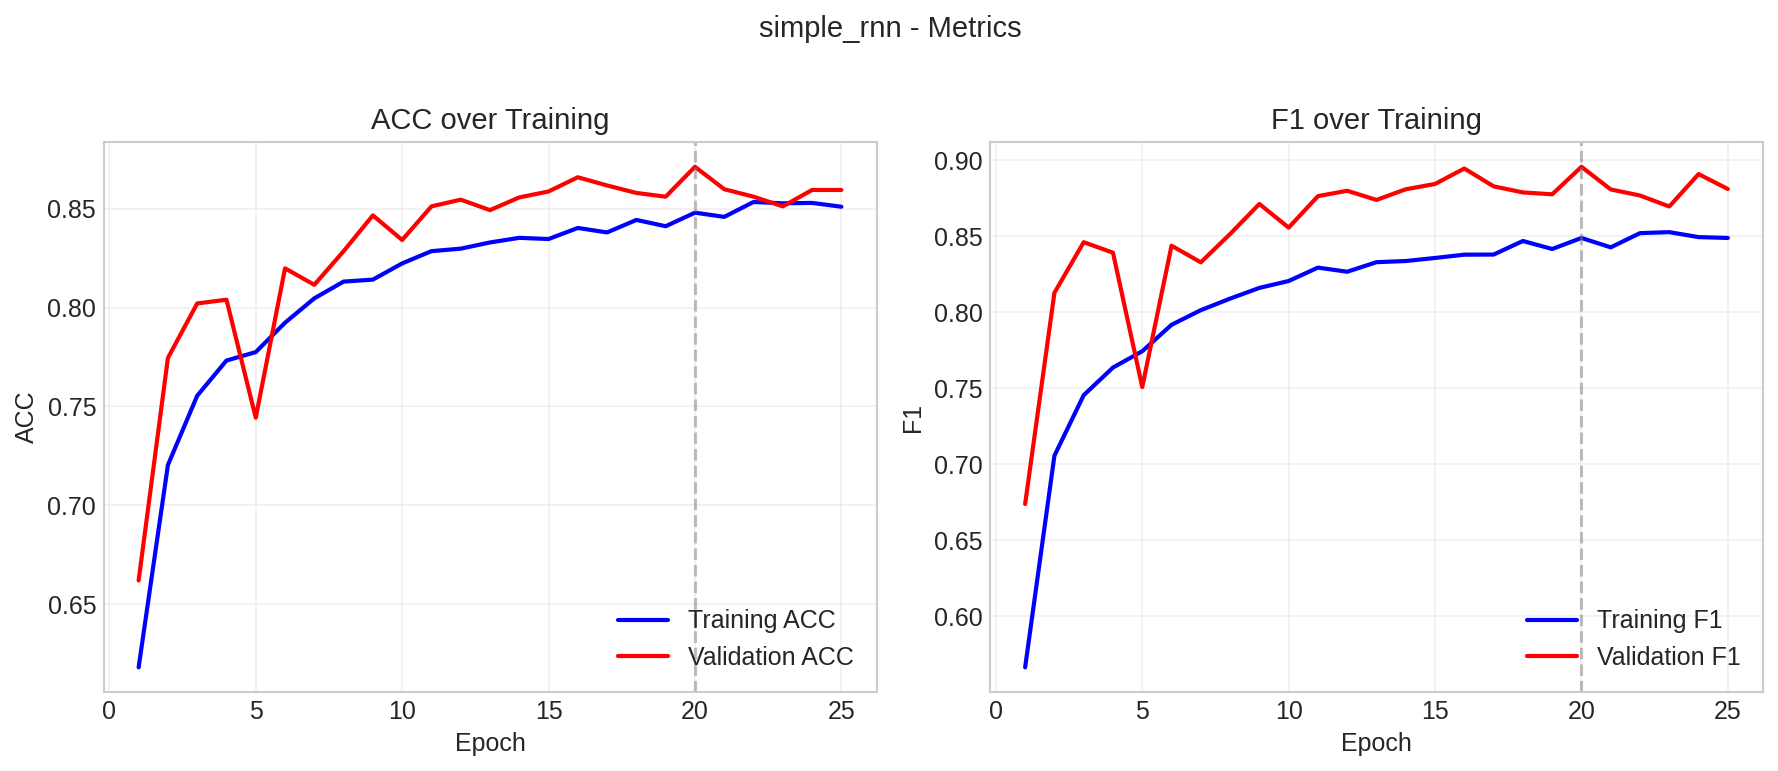


📊 simple_rnn_bi_hd128_nl2_dr0.3_noaug
----------------------------------------

confusion_matrix.png:


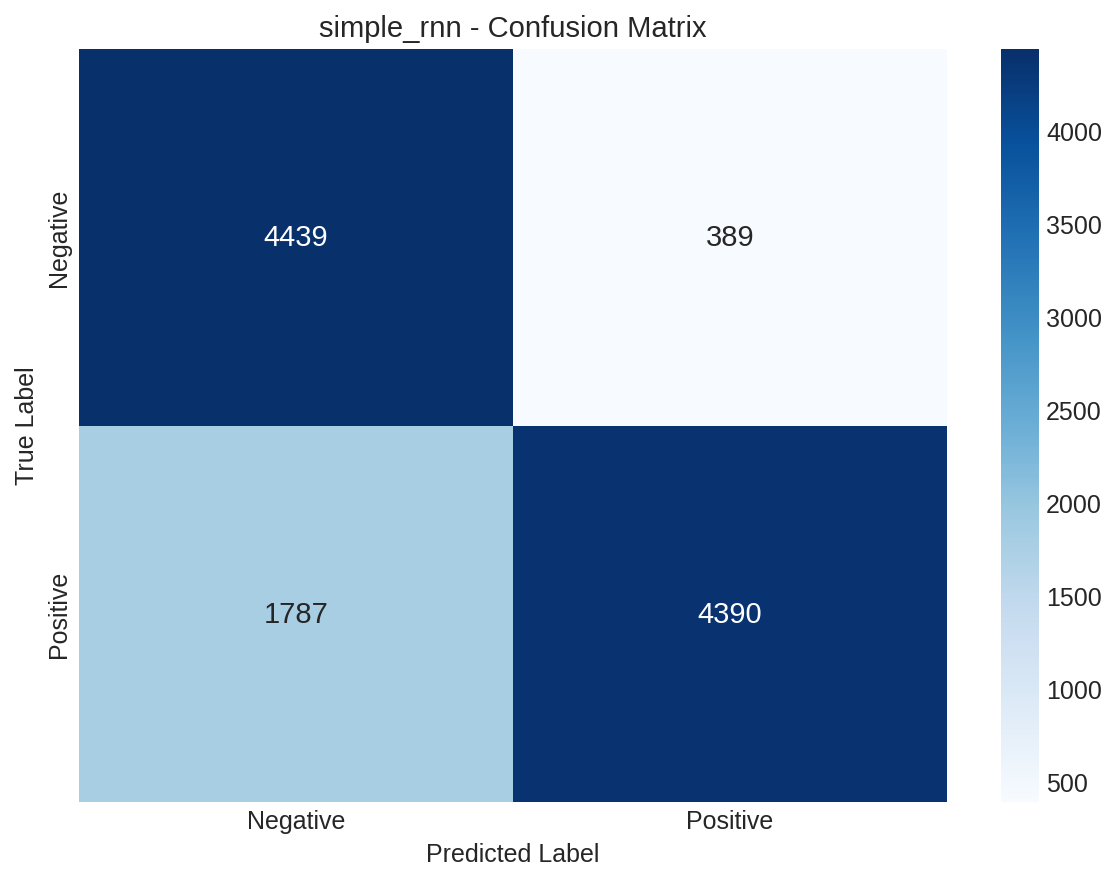


confusion_matrix_normalized.png:


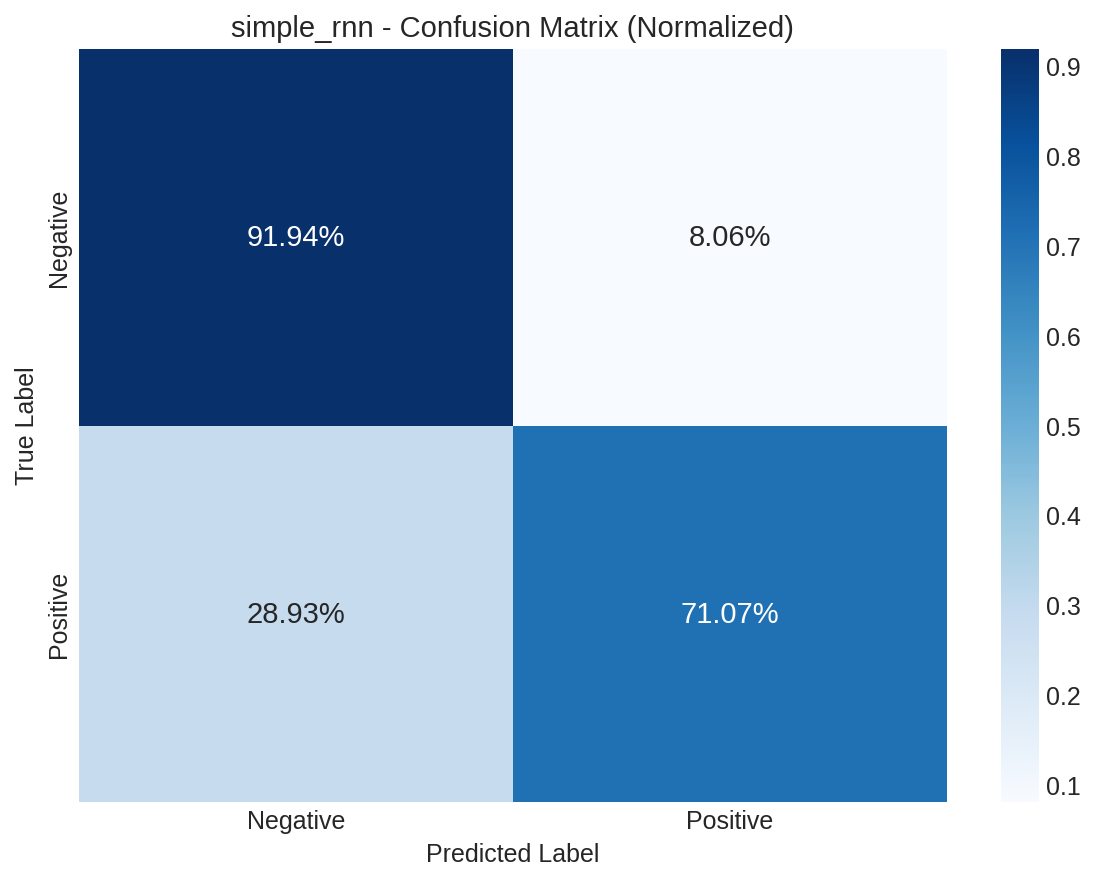


loss_curves.png:


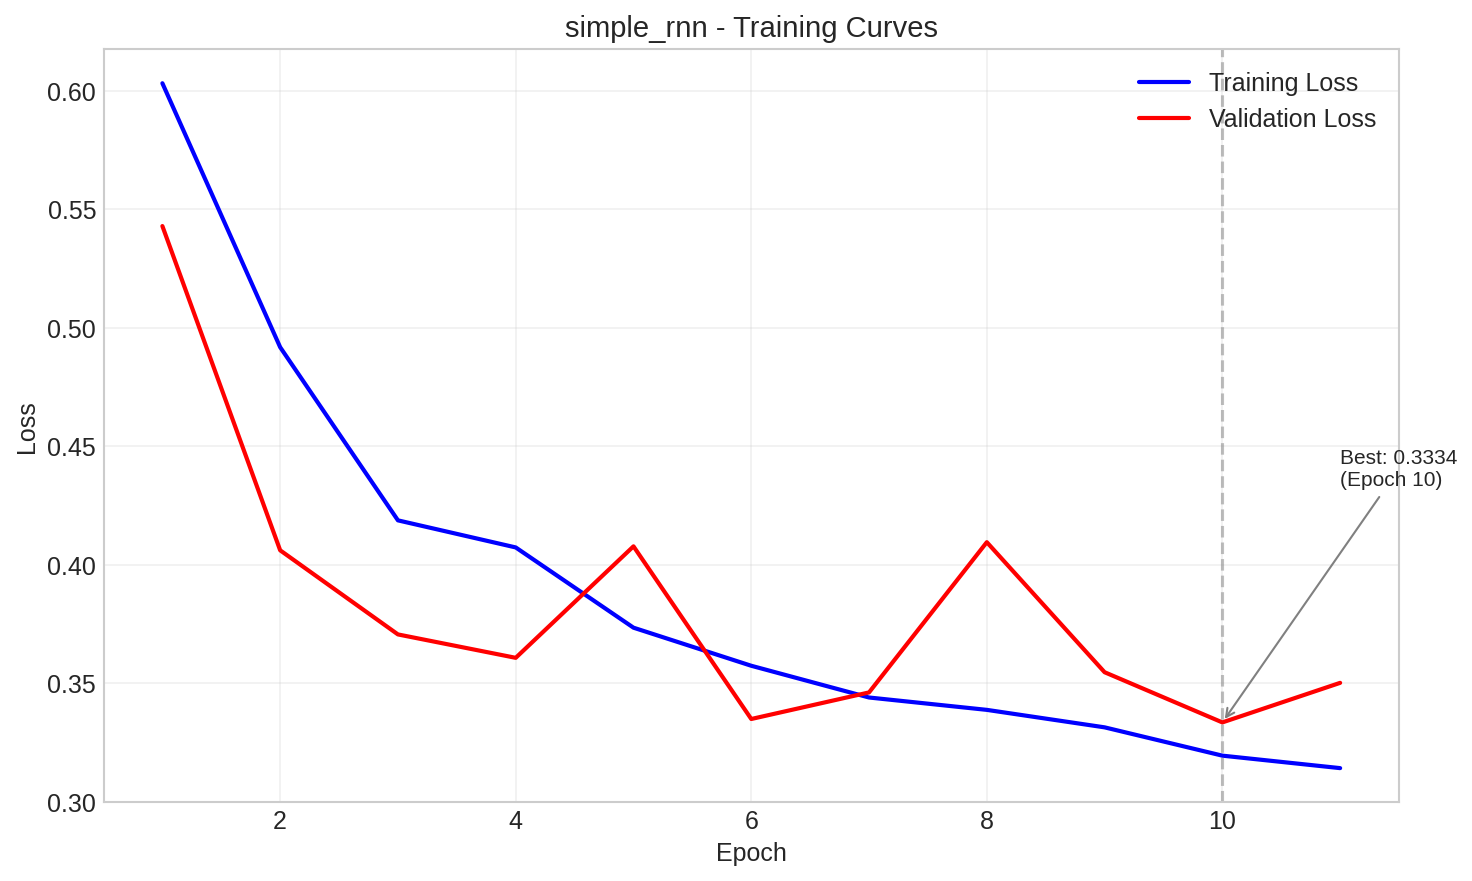


metrics_curves.png:


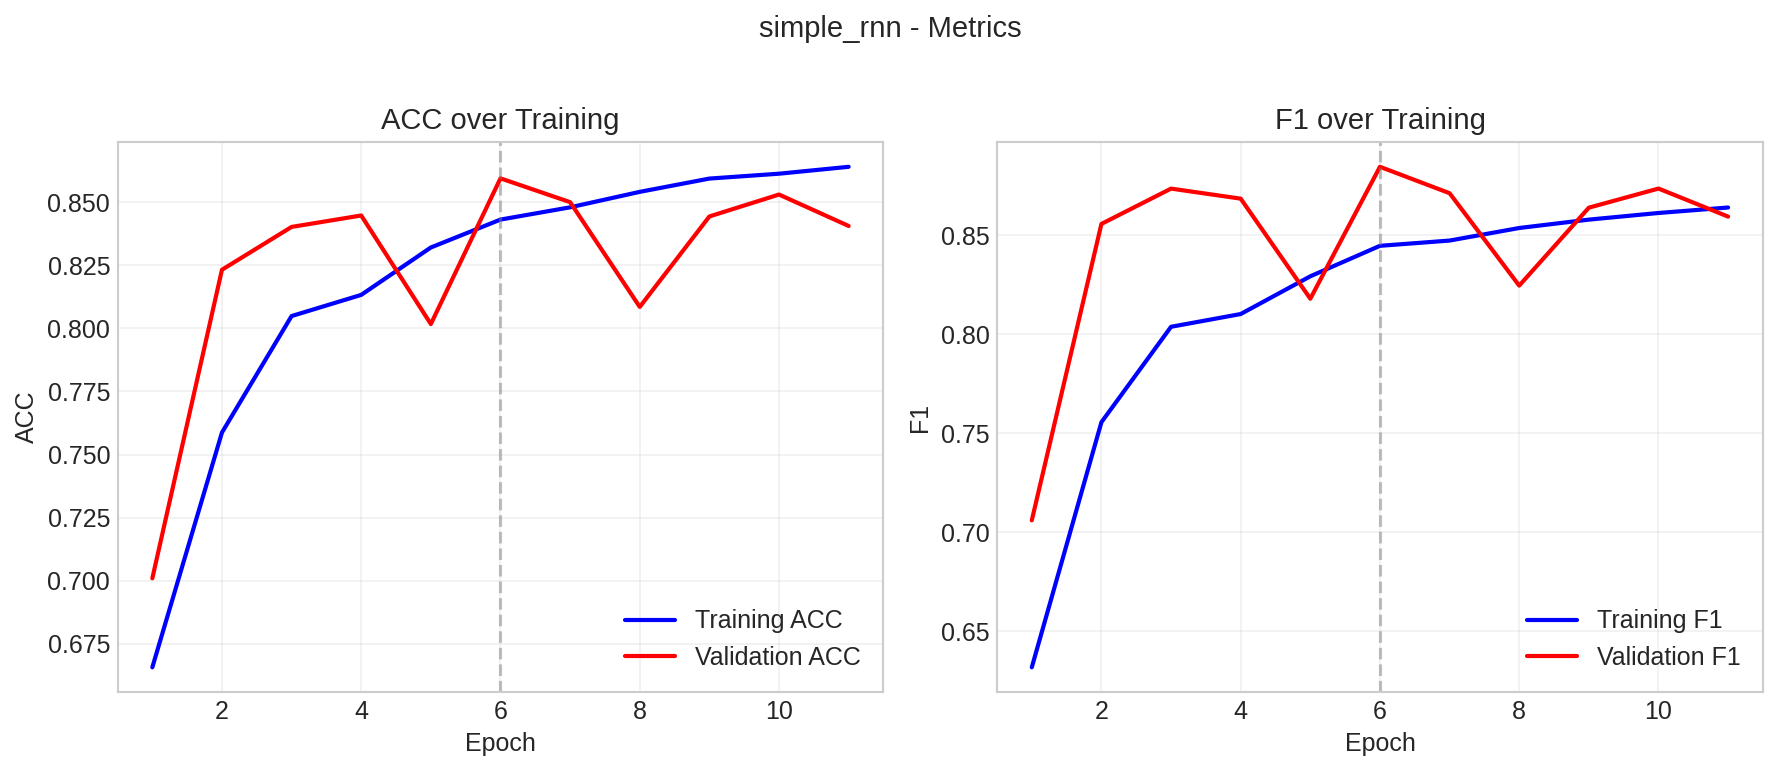


📊 simple_rnn_bi_hd128_nl2_noaug
----------------------------------------

confusion_matrix.png:


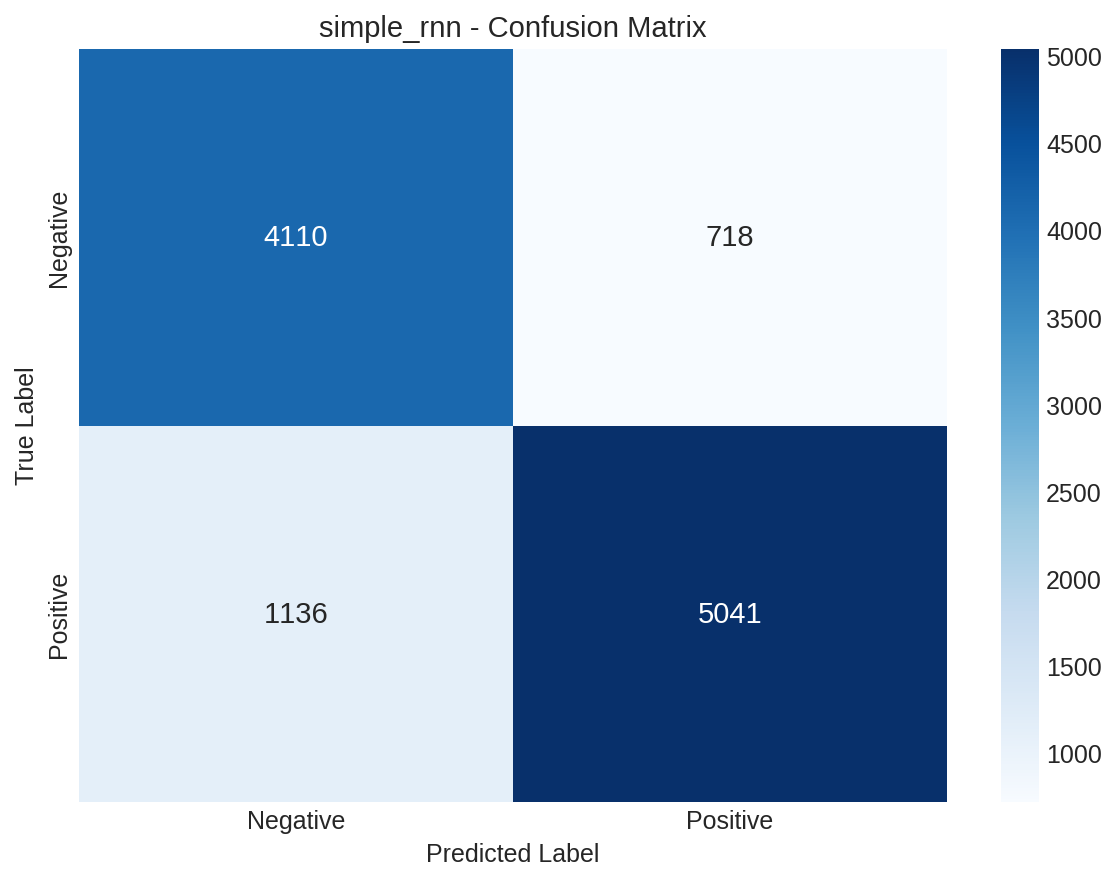


confusion_matrix_normalized.png:


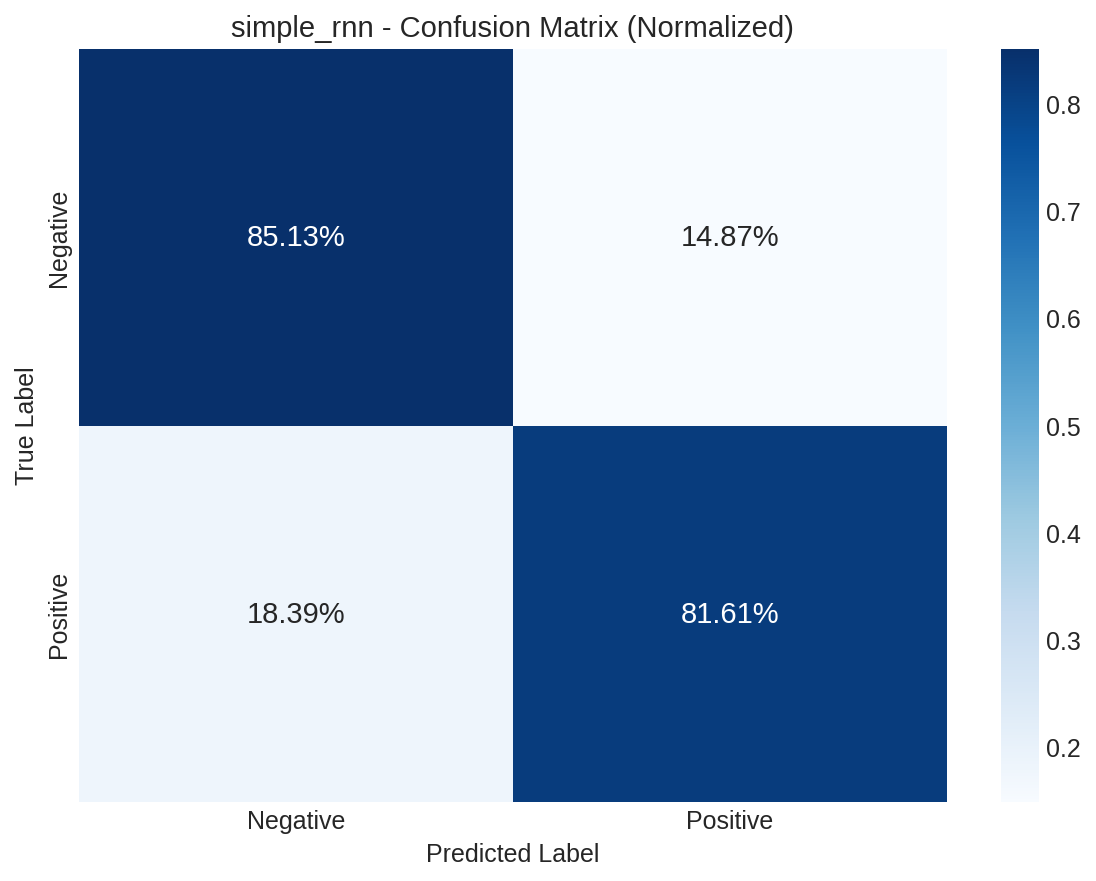


loss_curves.png:


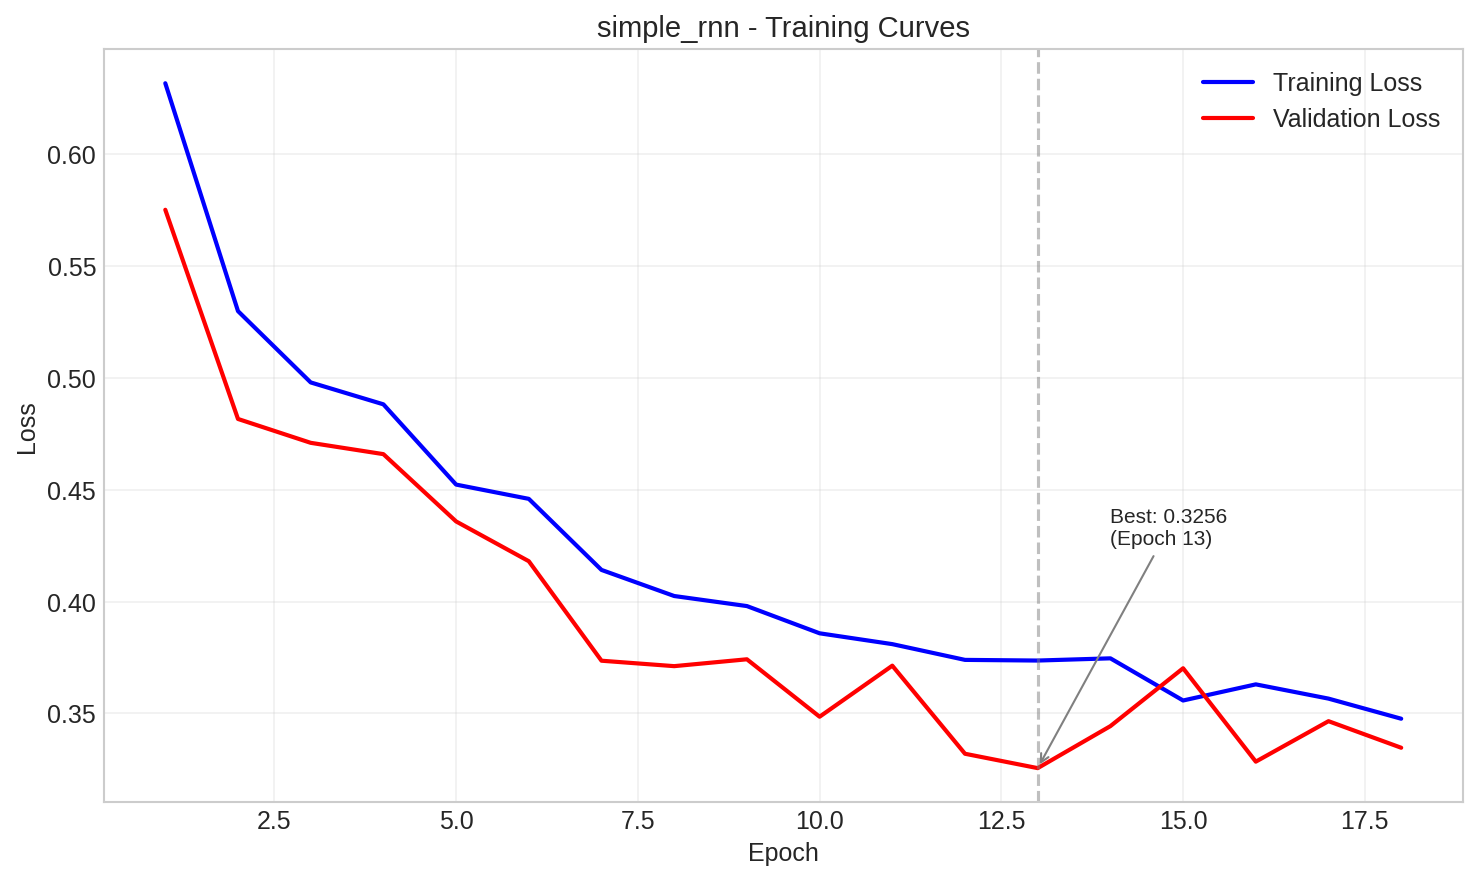


metrics_curves.png:


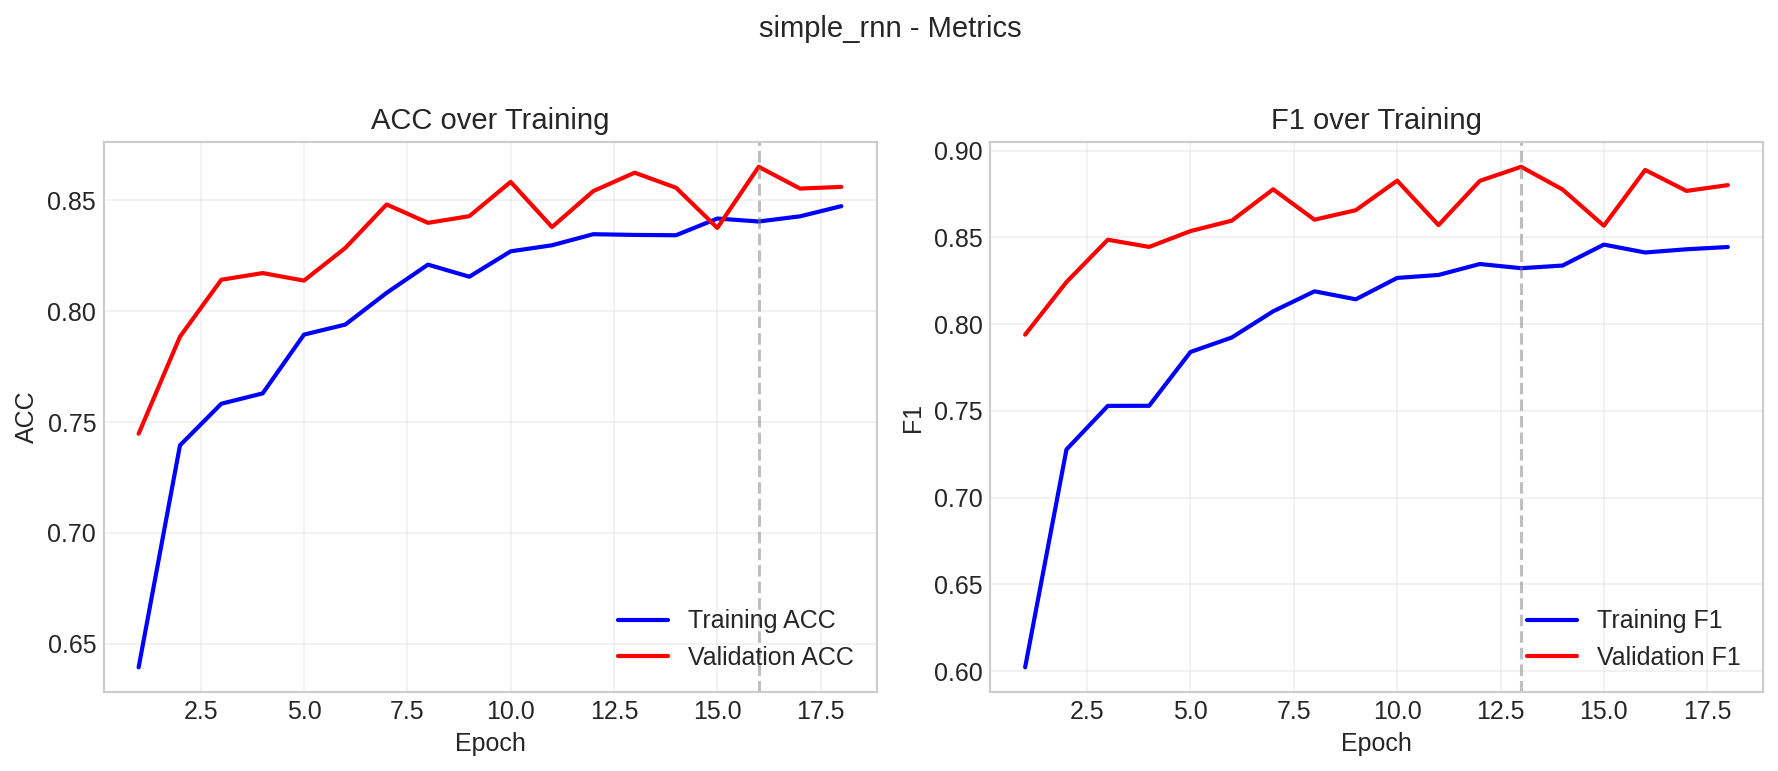


📊 simple_rnn_bi_noaug
----------------------------------------

confusion_matrix.png:


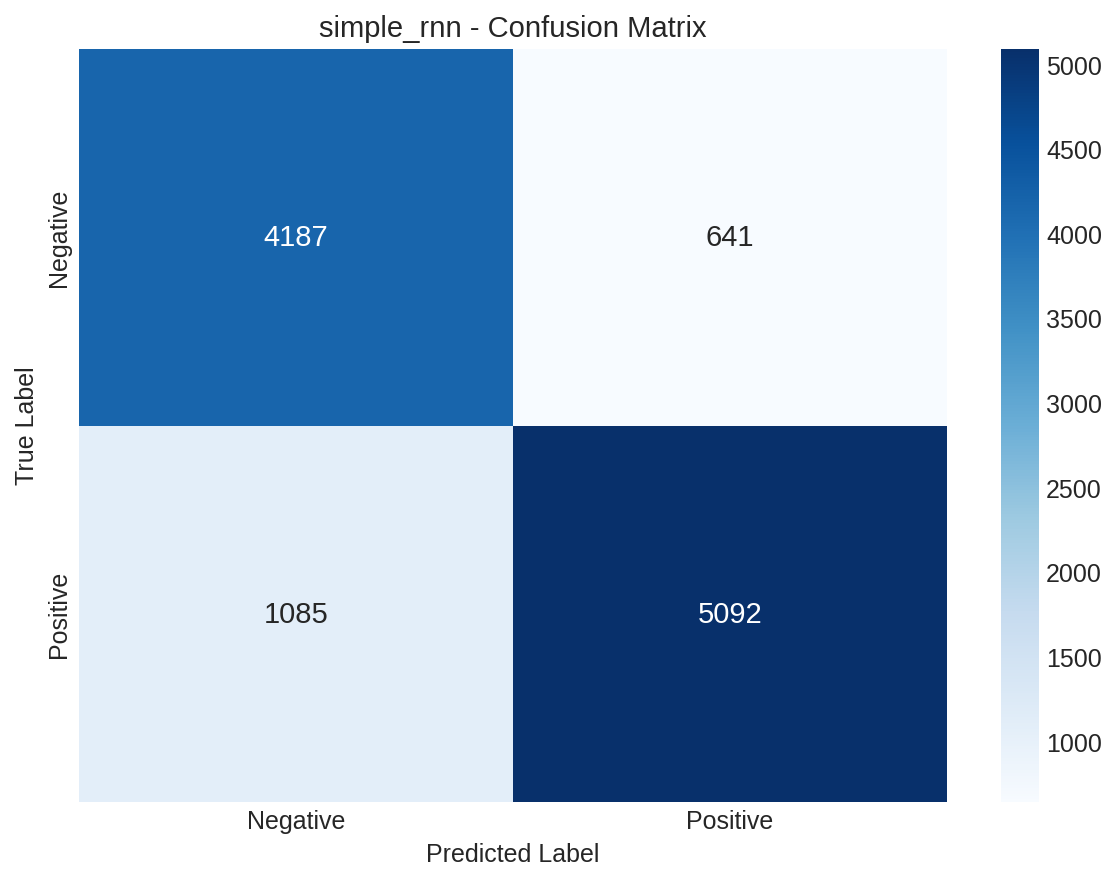


confusion_matrix_normalized.png:


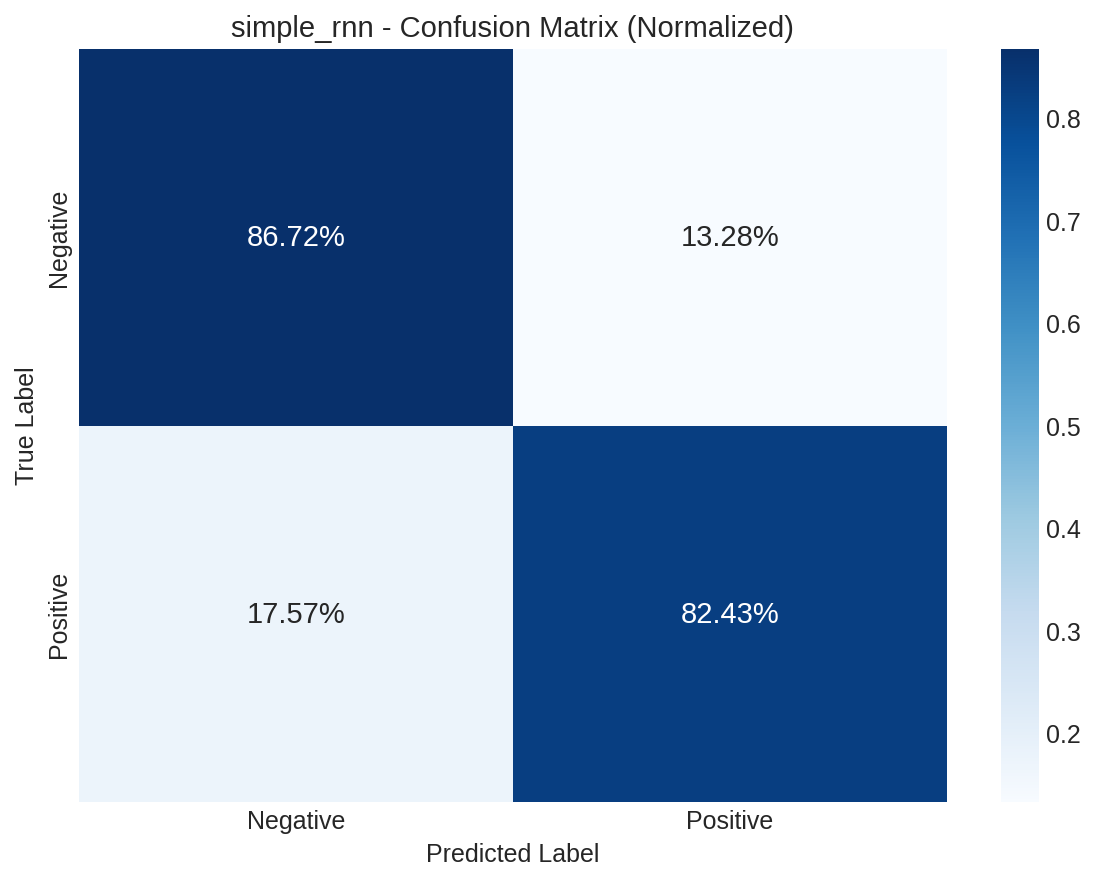


loss_curves.png:


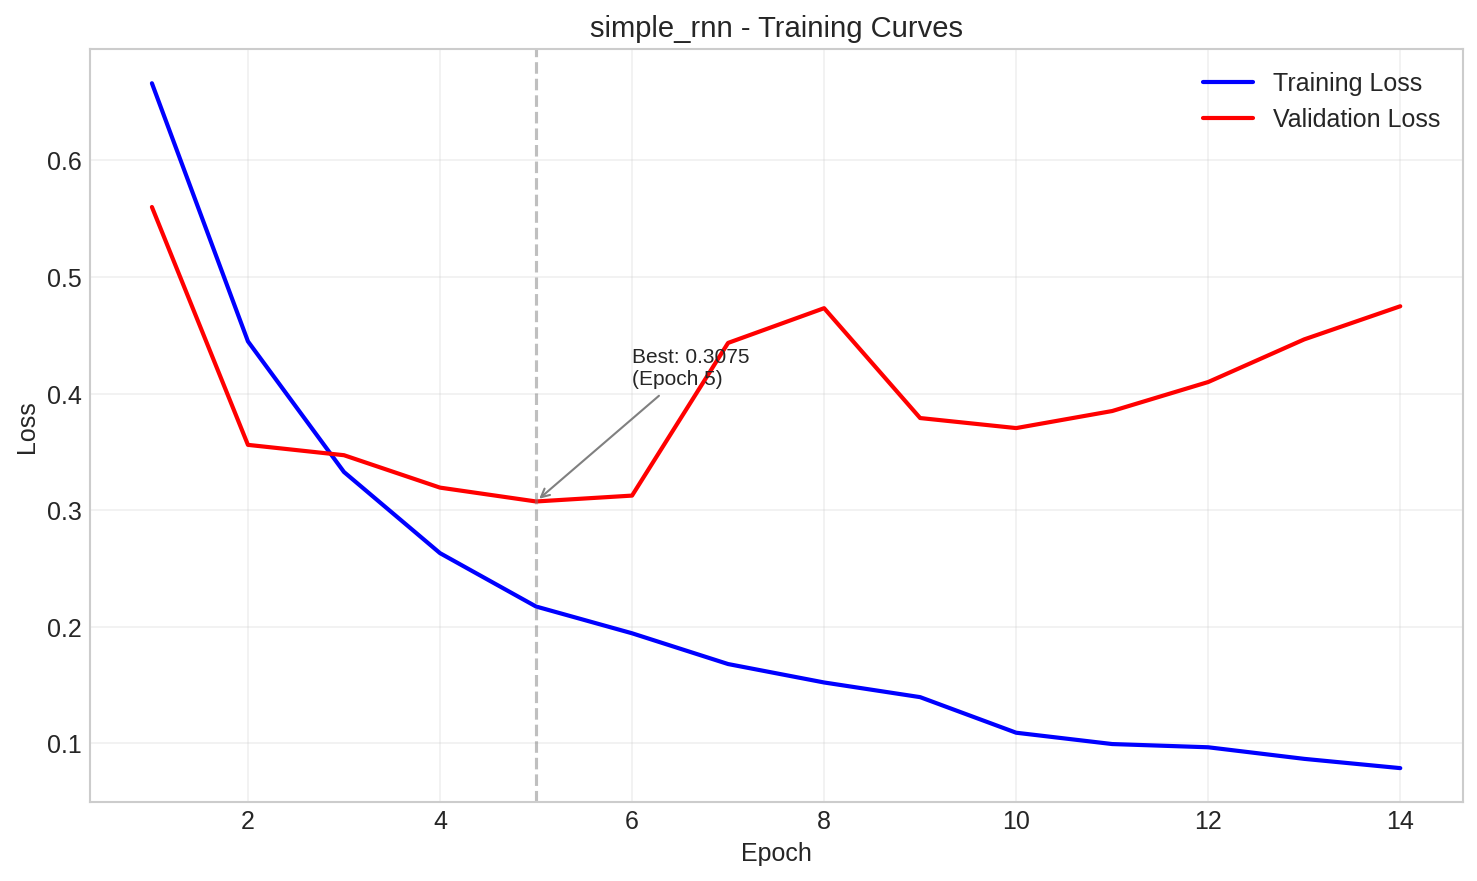


metrics_curves.png:


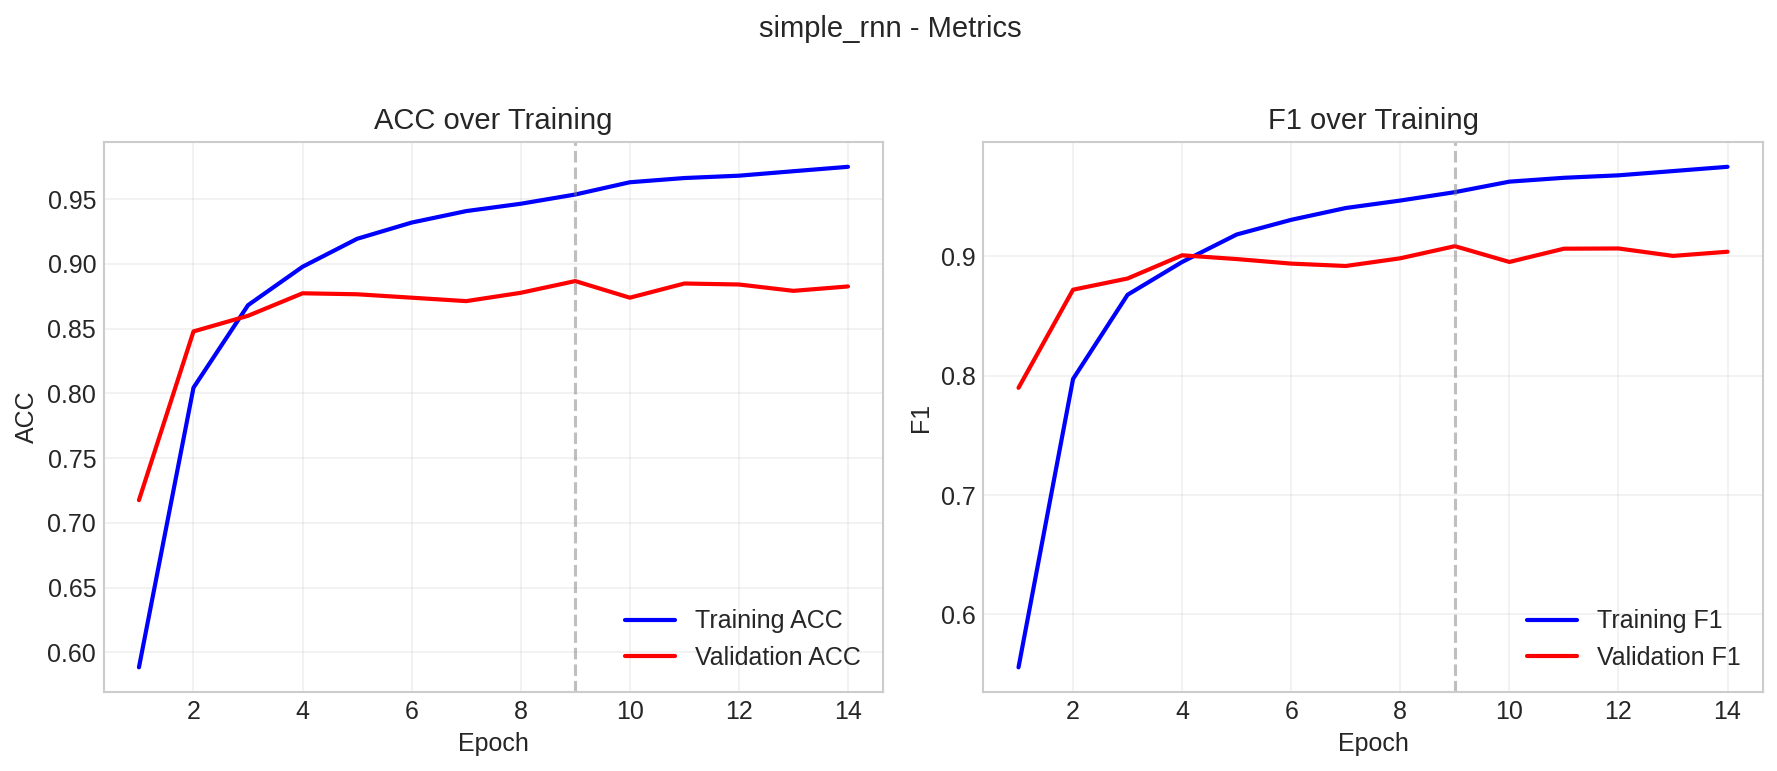


📊 simple_rnn_noaug
----------------------------------------

confusion_matrix.png:


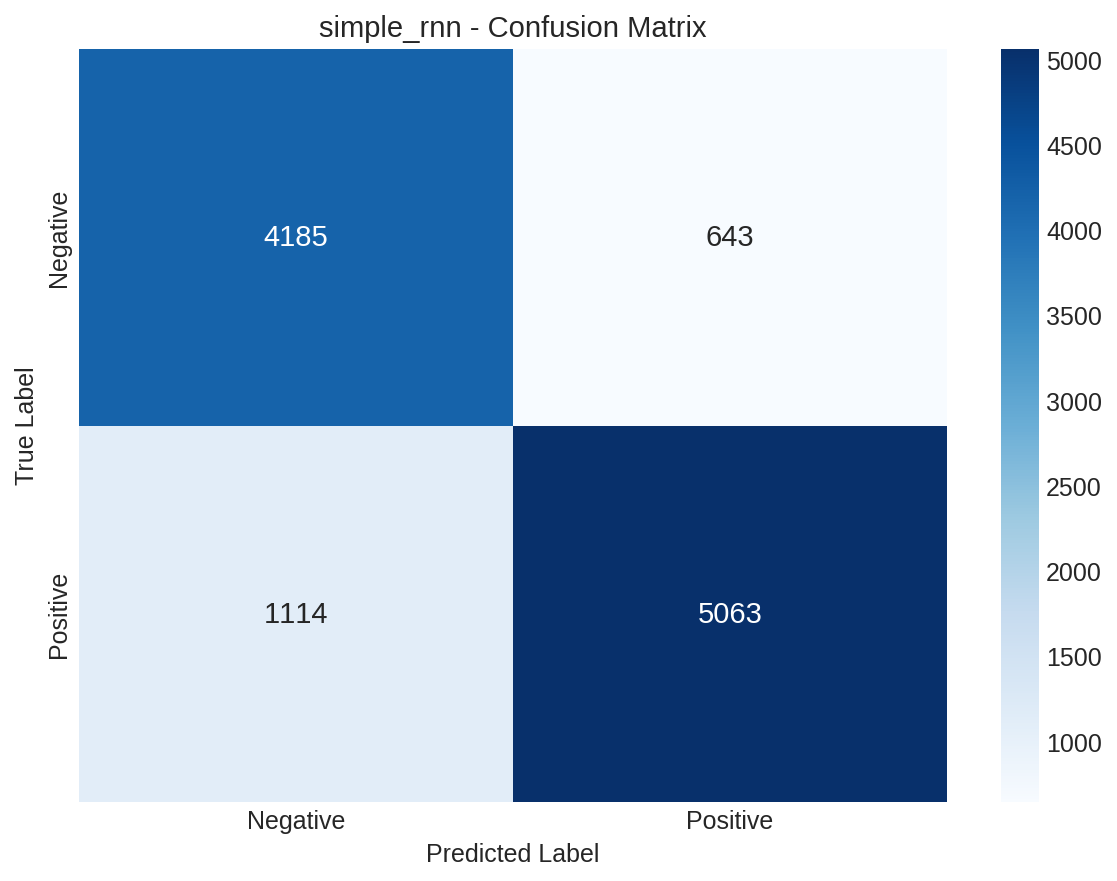


confusion_matrix_normalized.png:


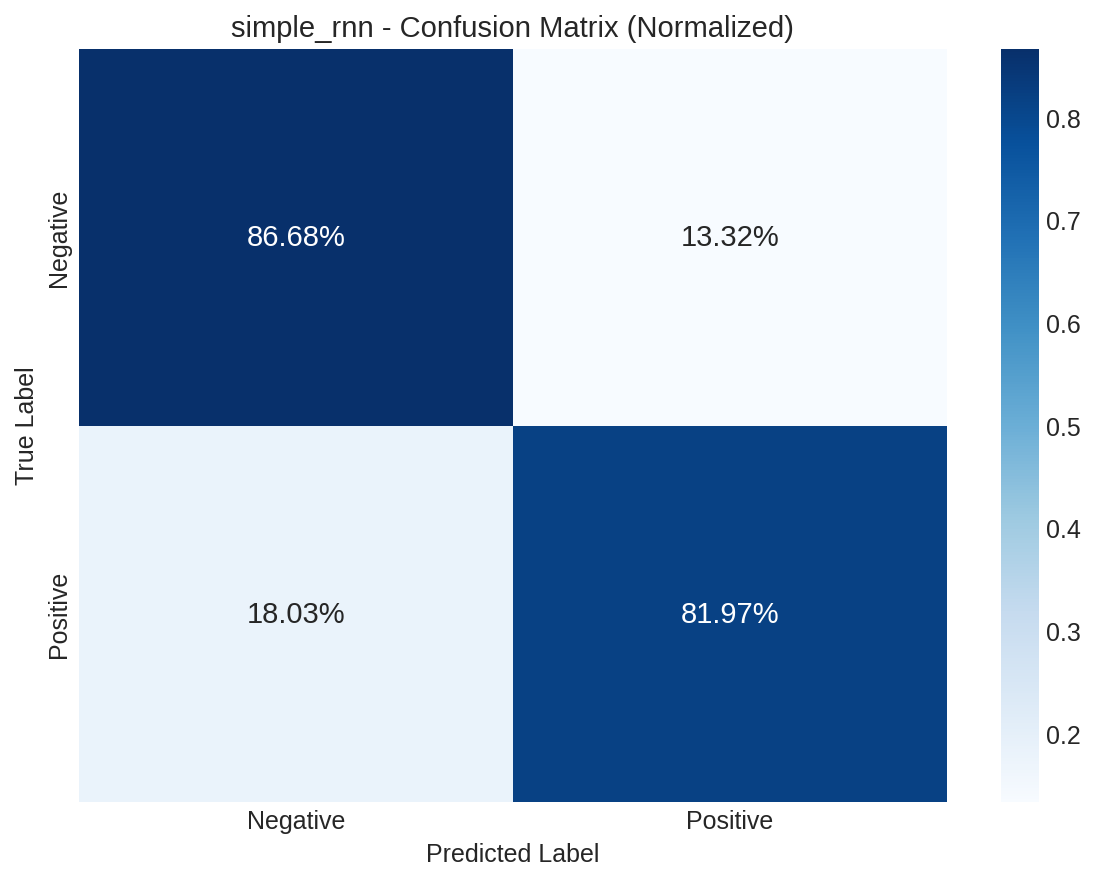


loss_curves.png:


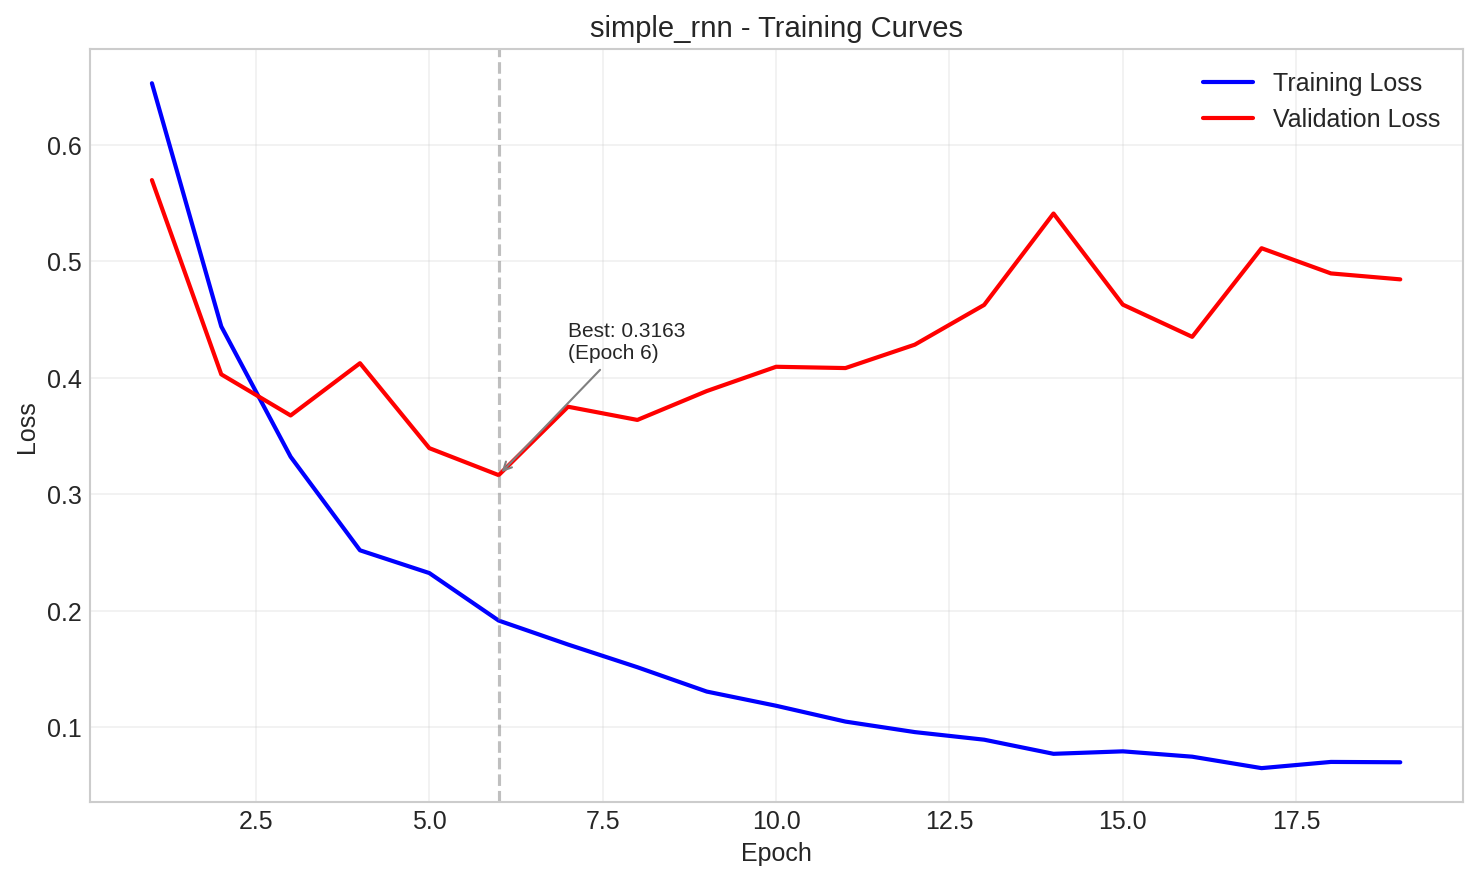


metrics_curves.png:


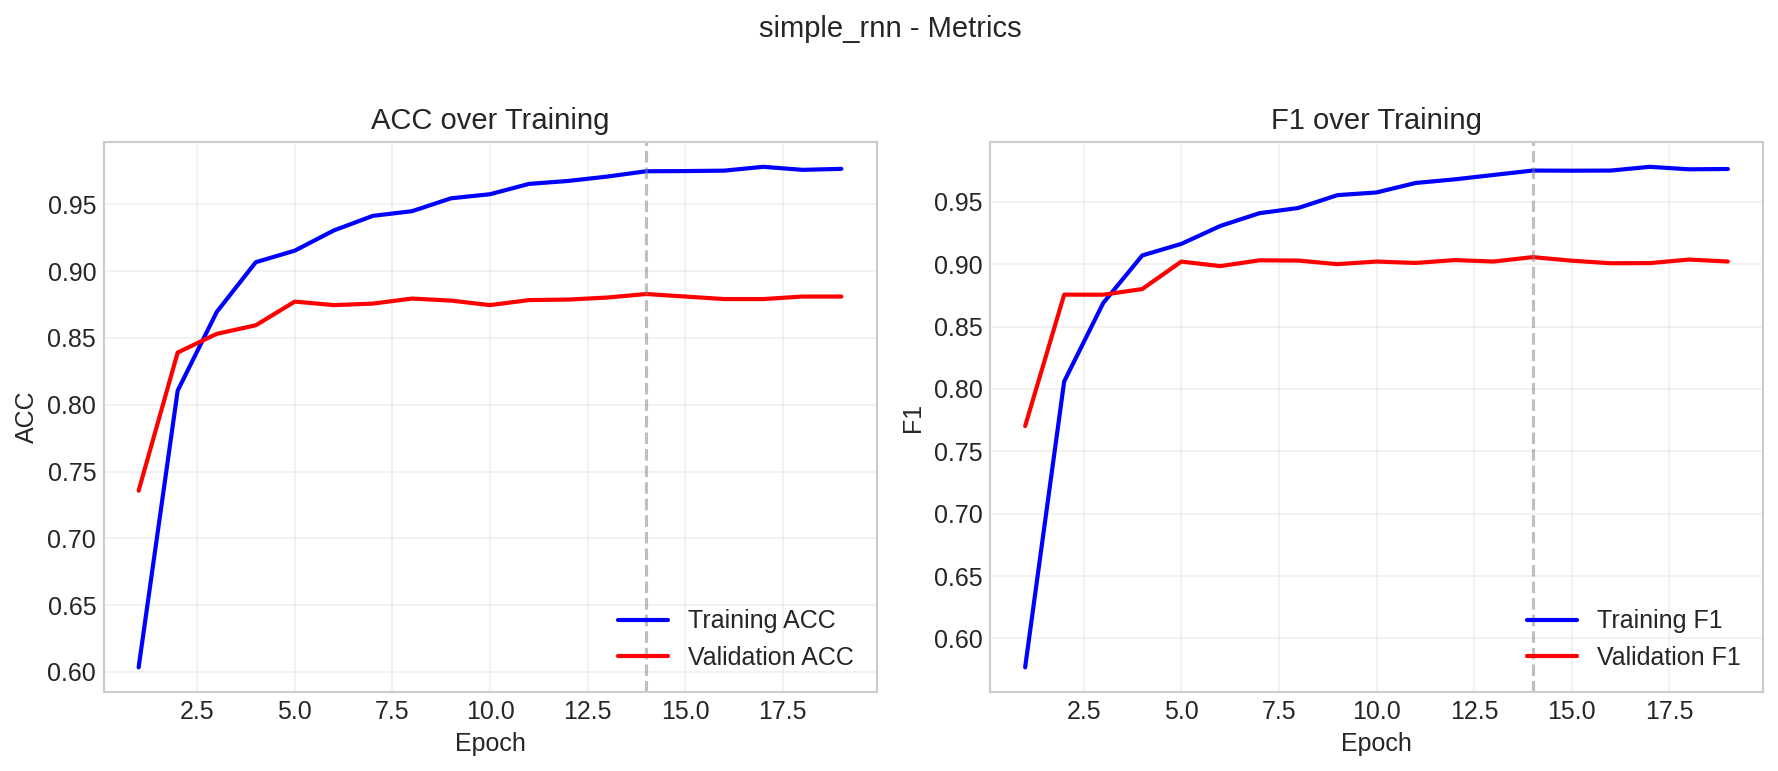


📊 stacked_lstm_bi_edaplus_p0.3
----------------------------------------

confusion_matrix.png:


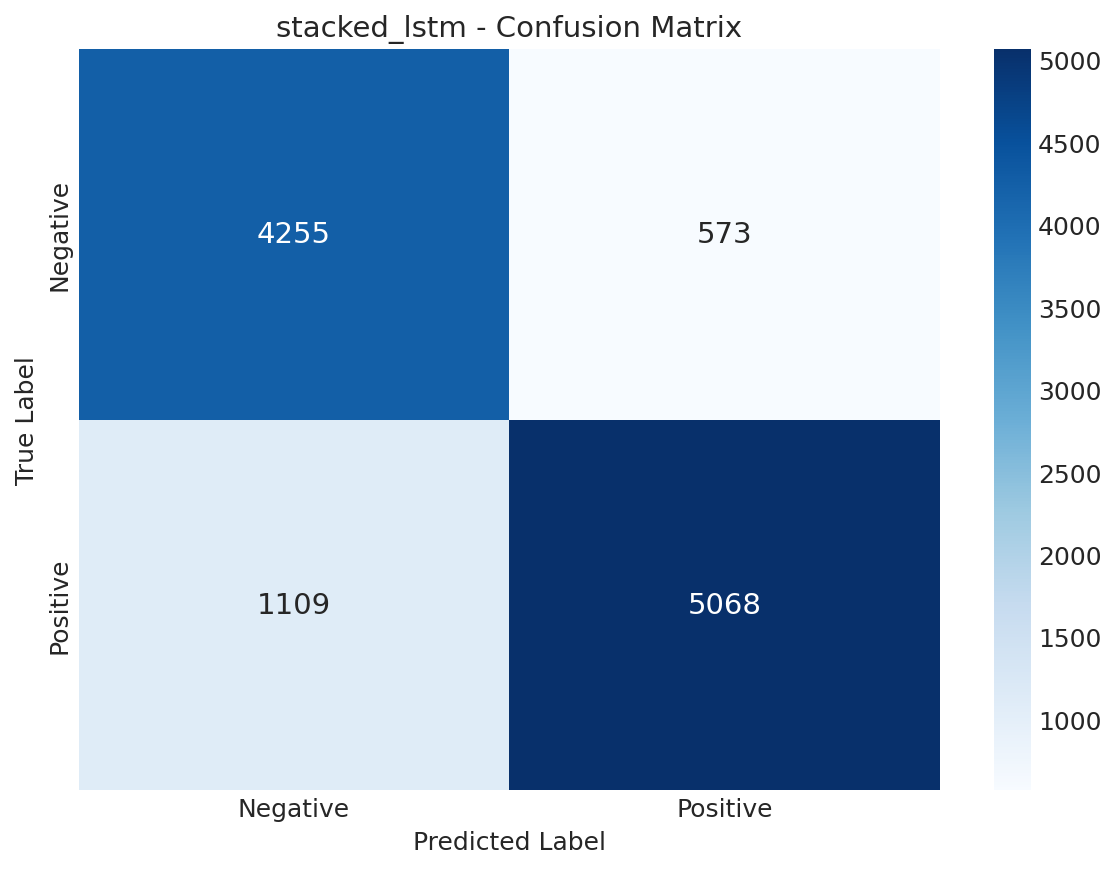


confusion_matrix_normalized.png:


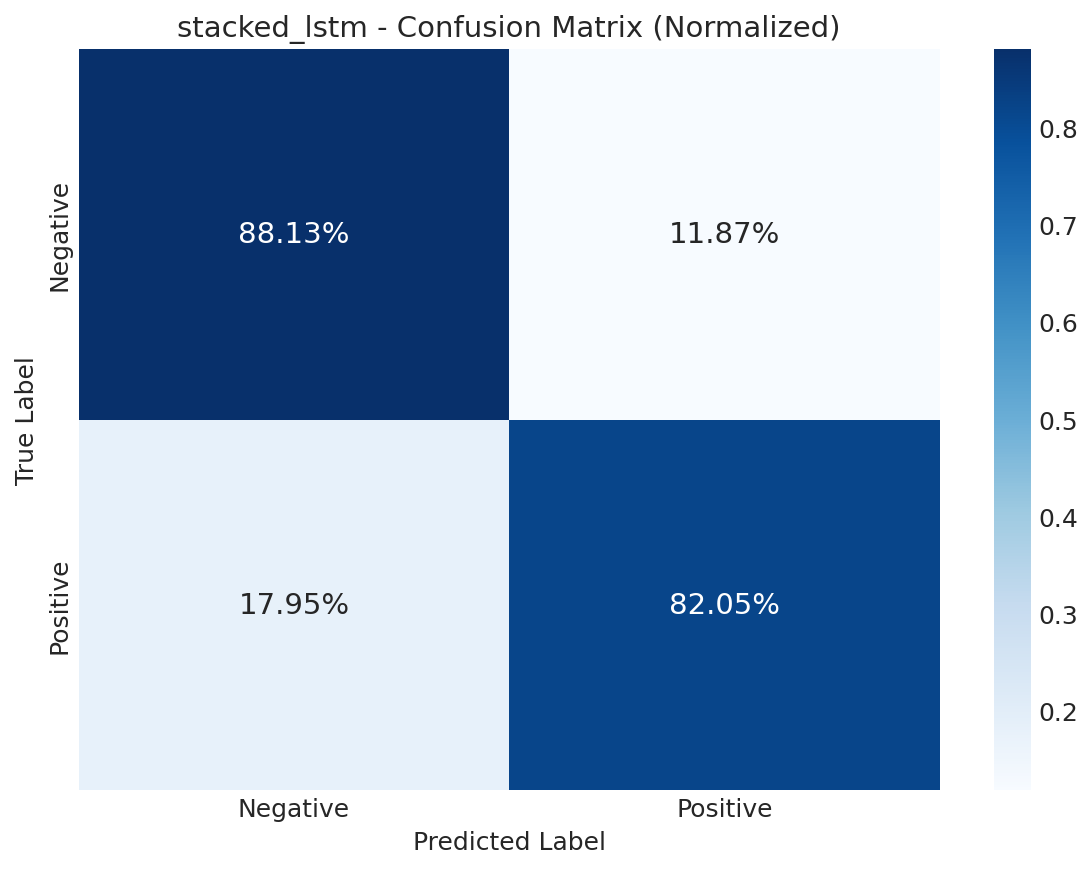


loss_curves.png:


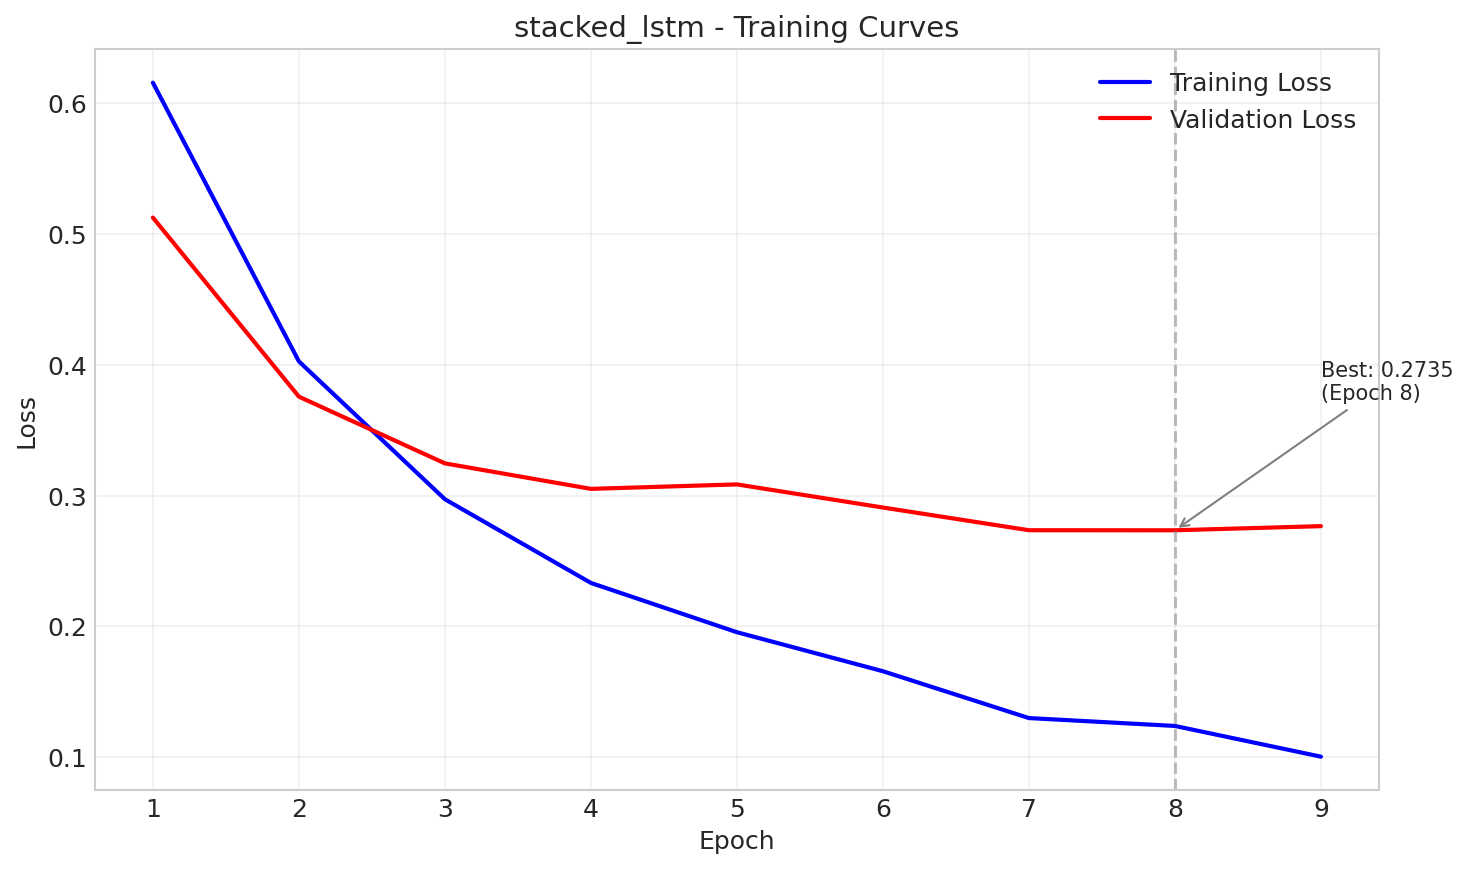


metrics_curves.png:


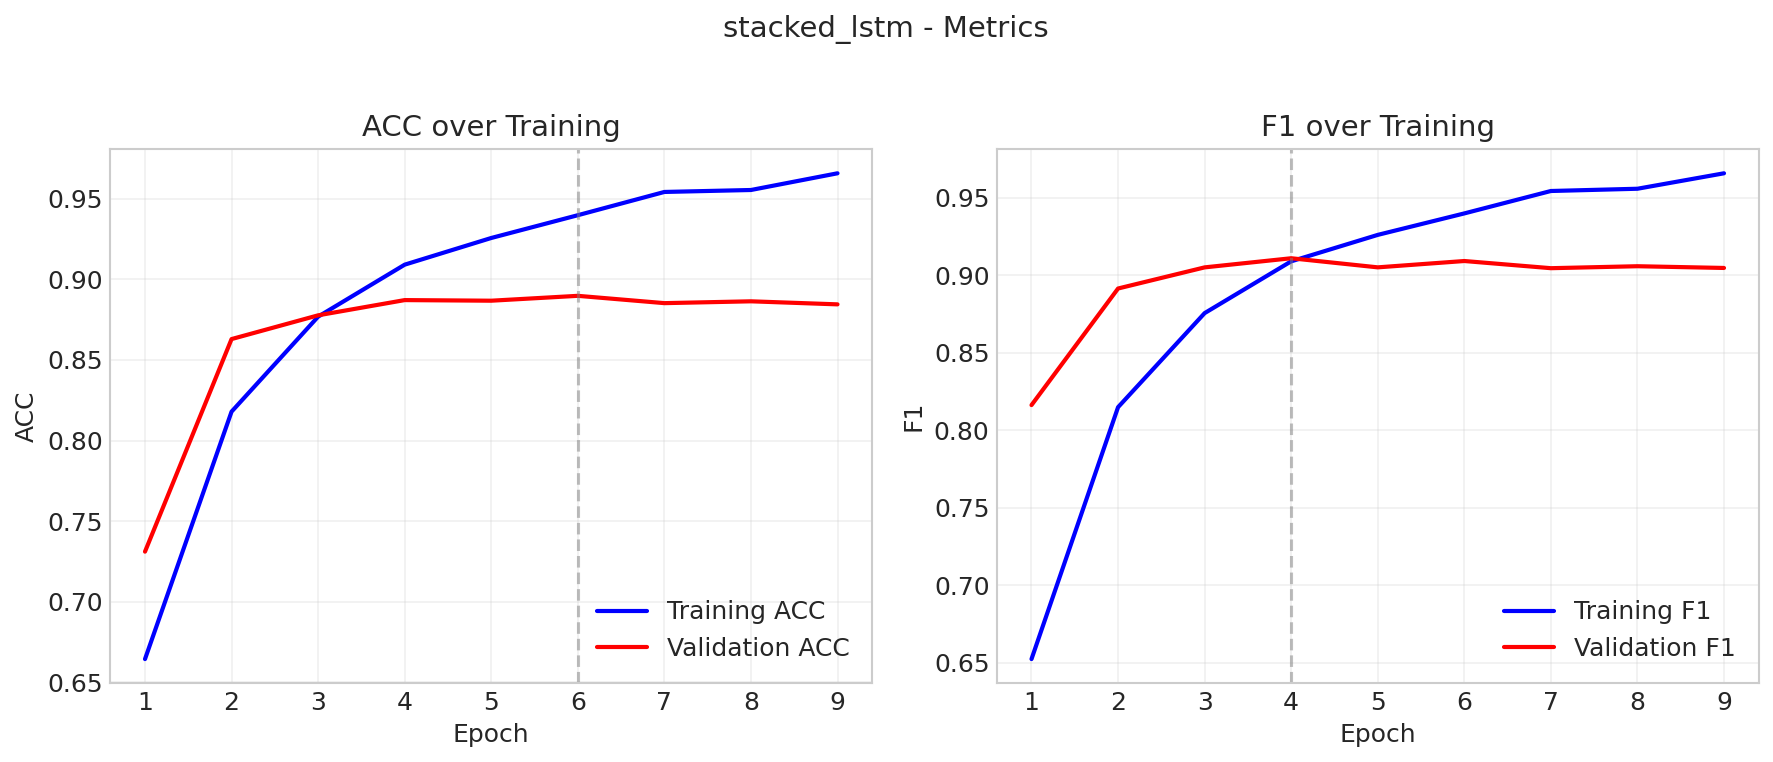


📊 stacked_lstm_bi_noaug
----------------------------------------

confusion_matrix.png:


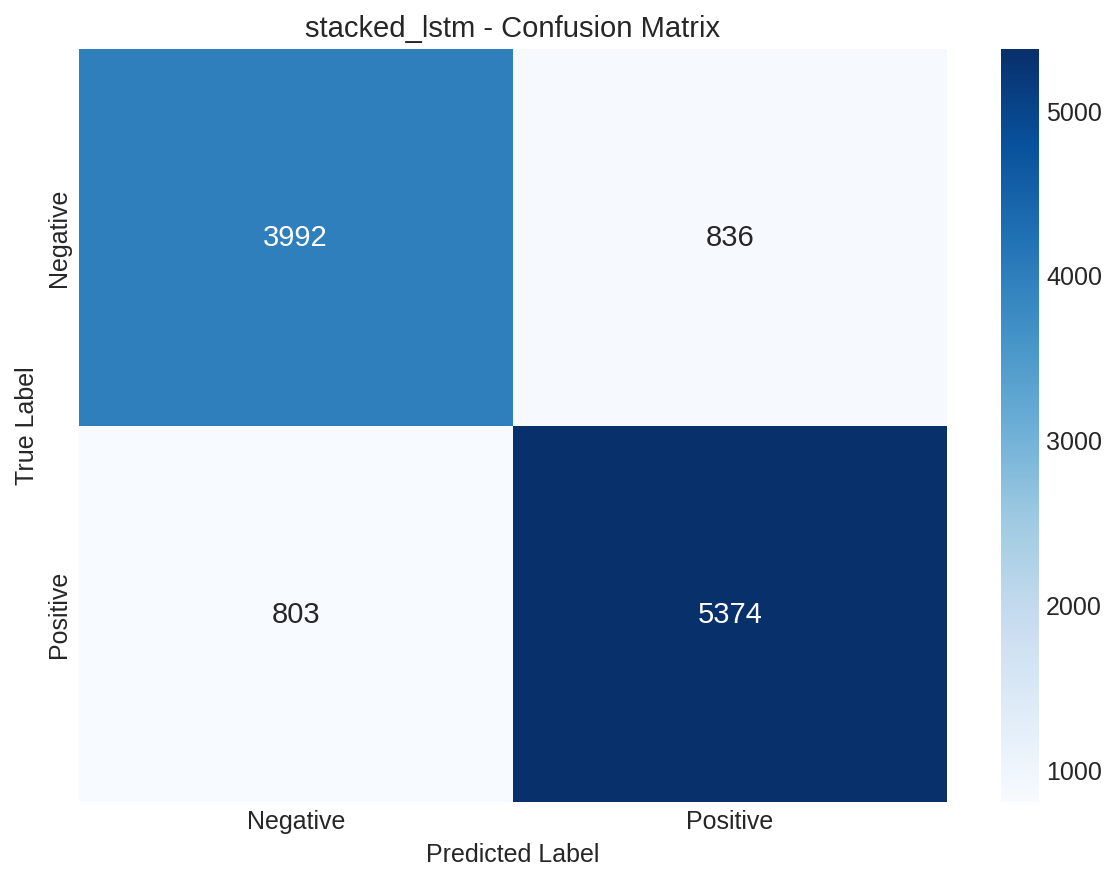


confusion_matrix_normalized.png:


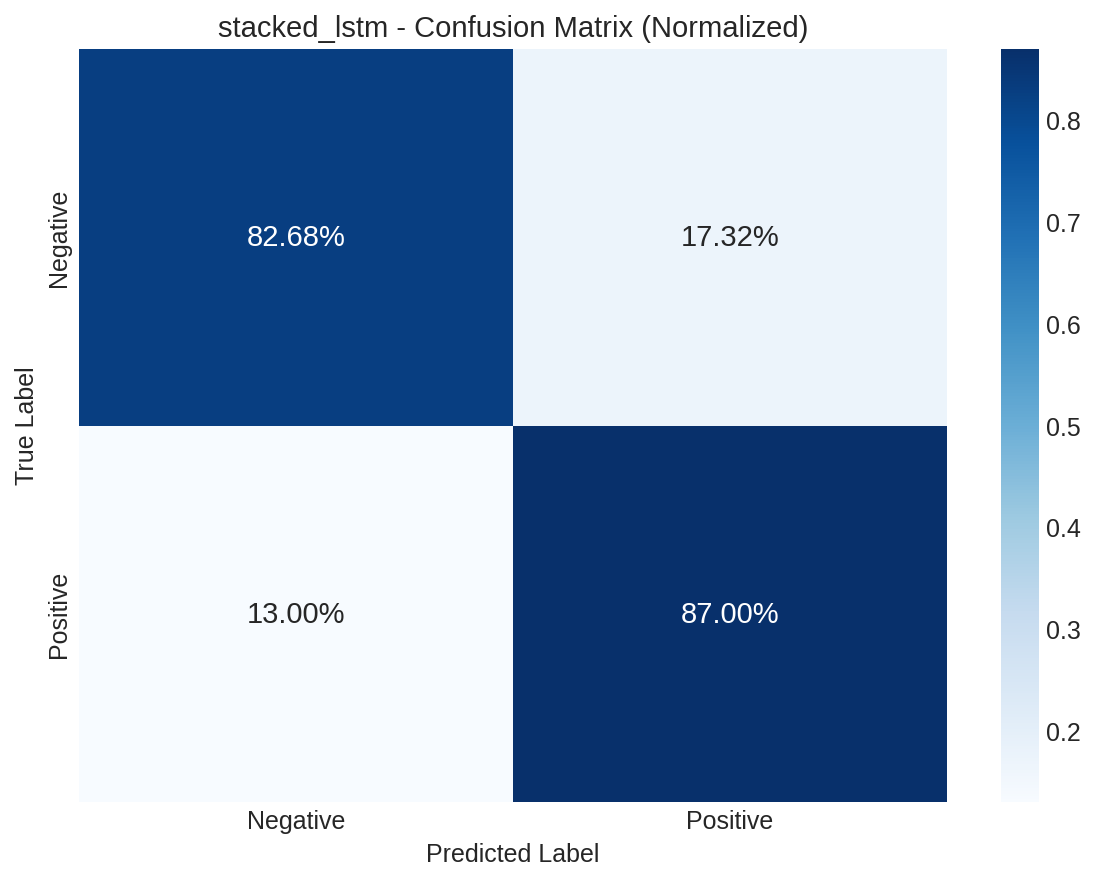


loss_curves.png:


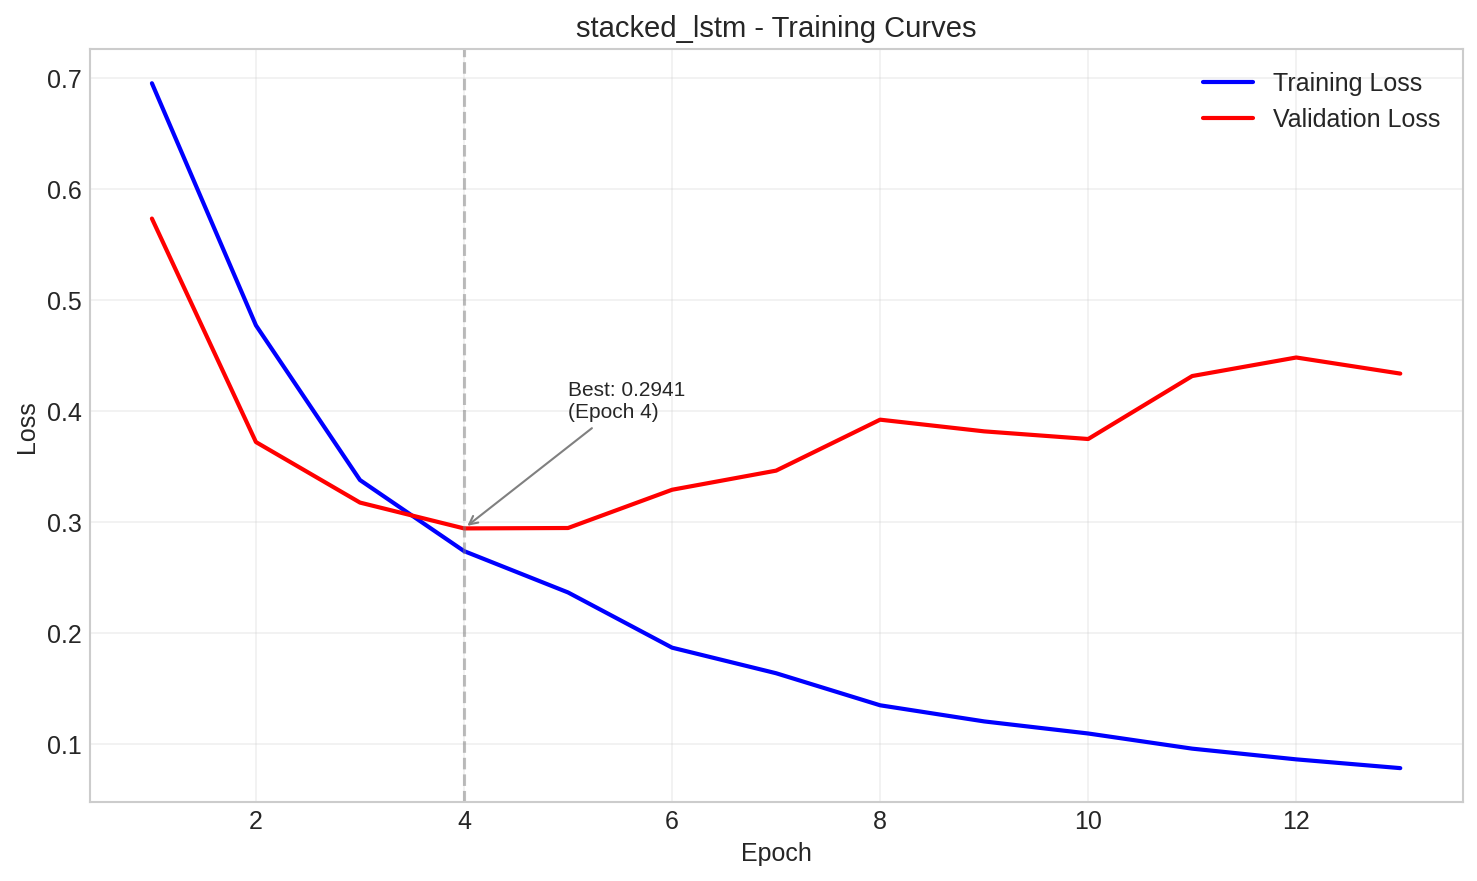


metrics_curves.png:


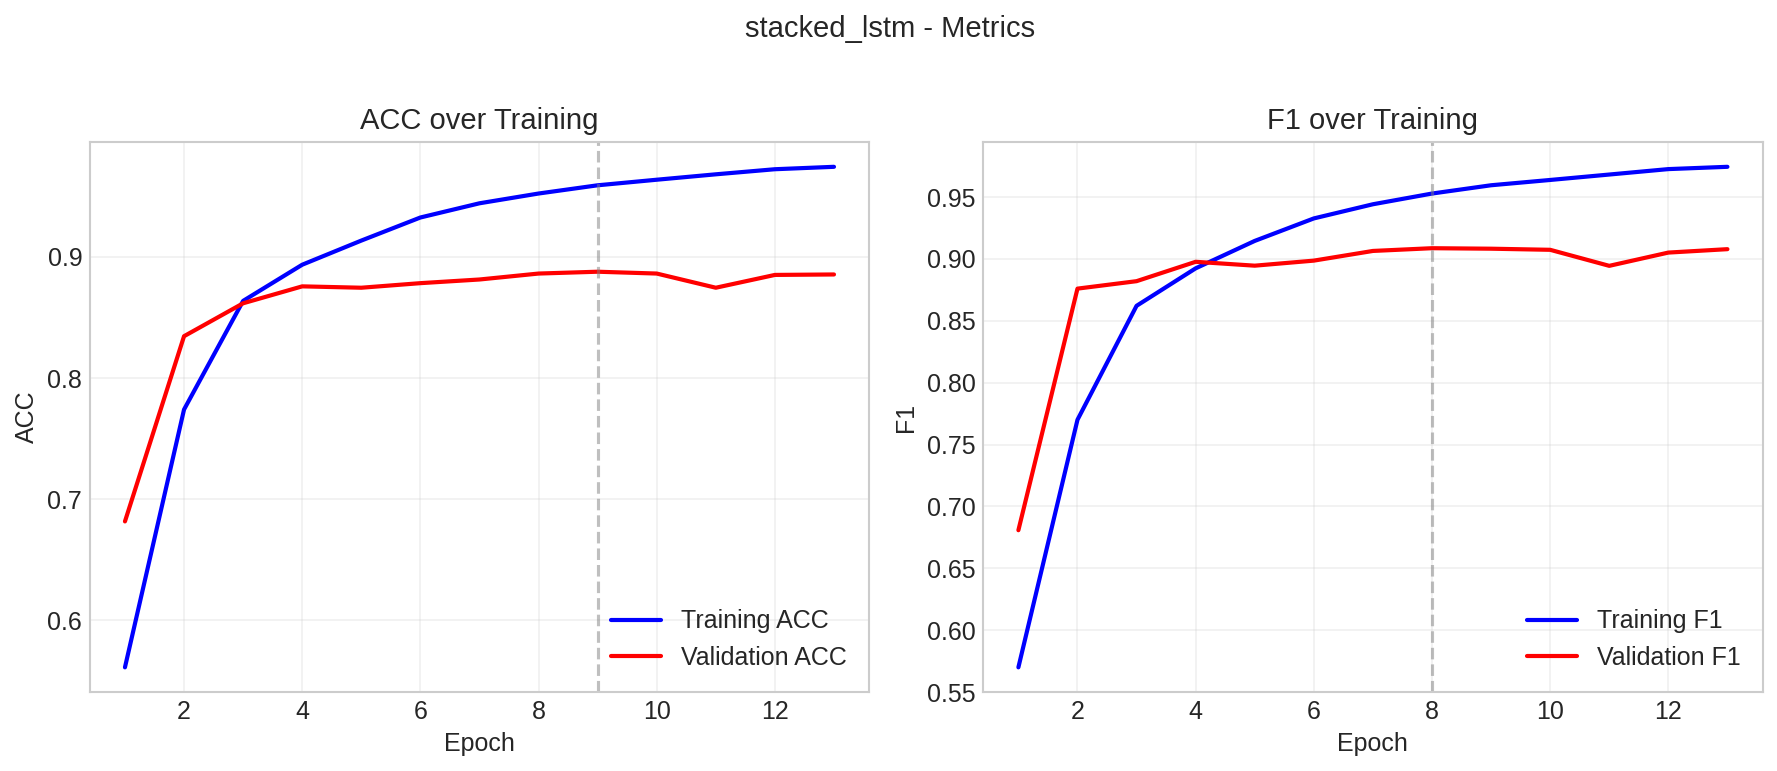


📊 stacked_rnn_bi_edaplus_p0.3
----------------------------------------

confusion_matrix.png:


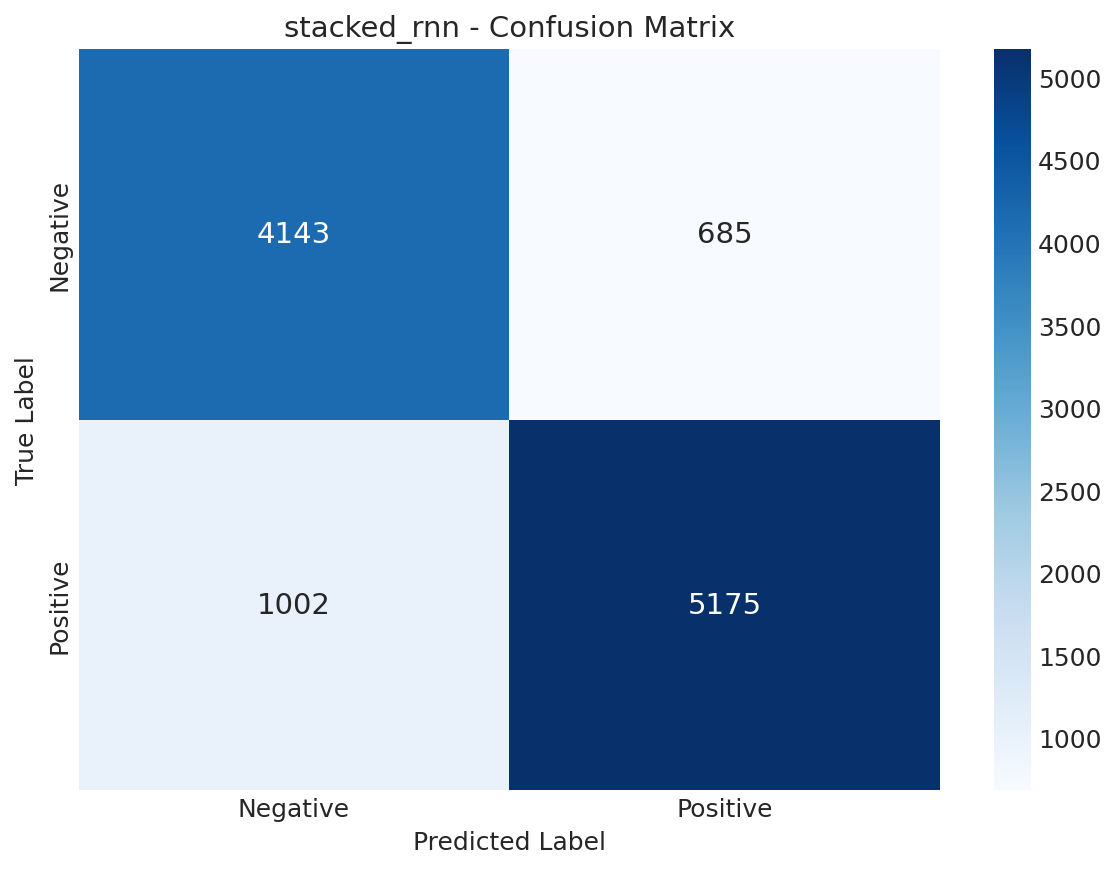


confusion_matrix_normalized.png:


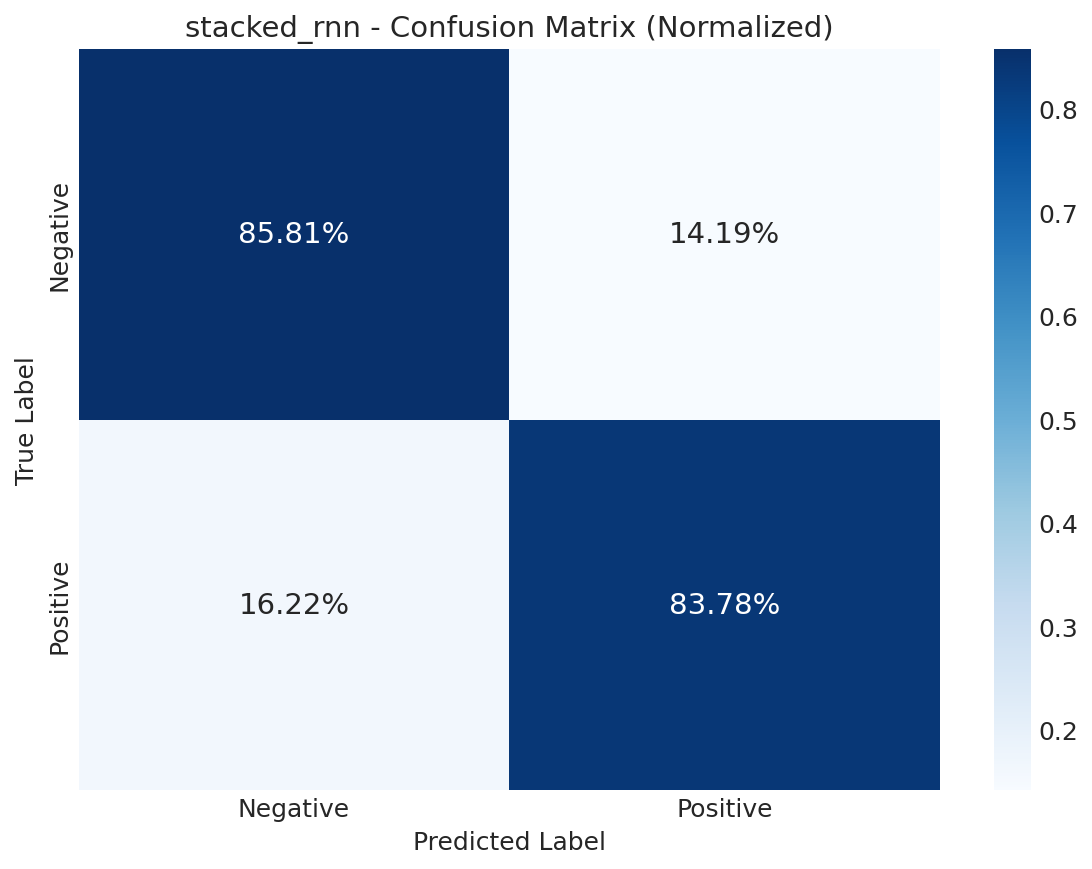


loss_curves.png:


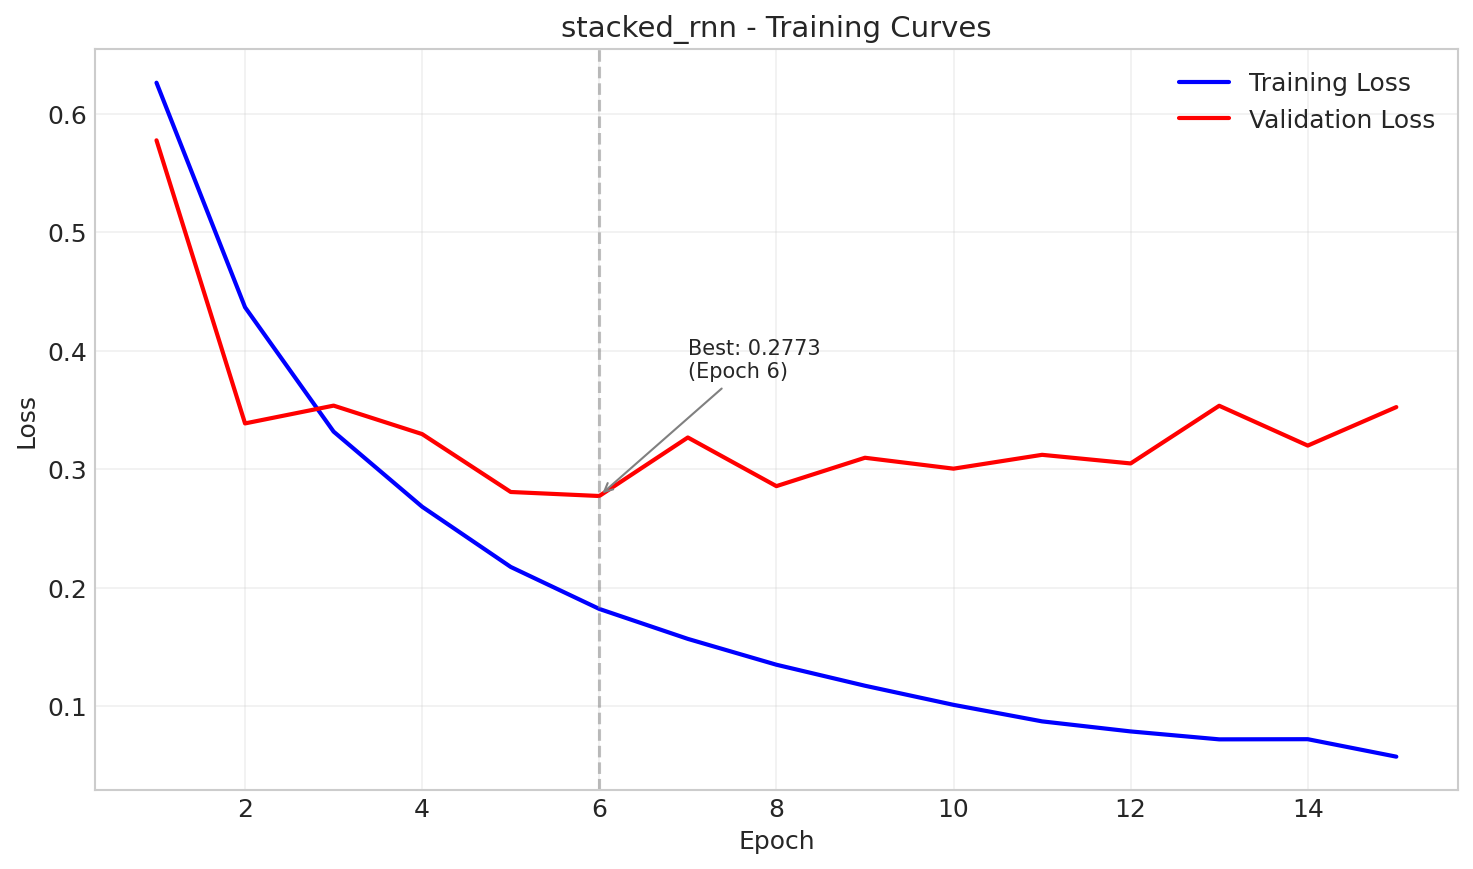


metrics_curves.png:


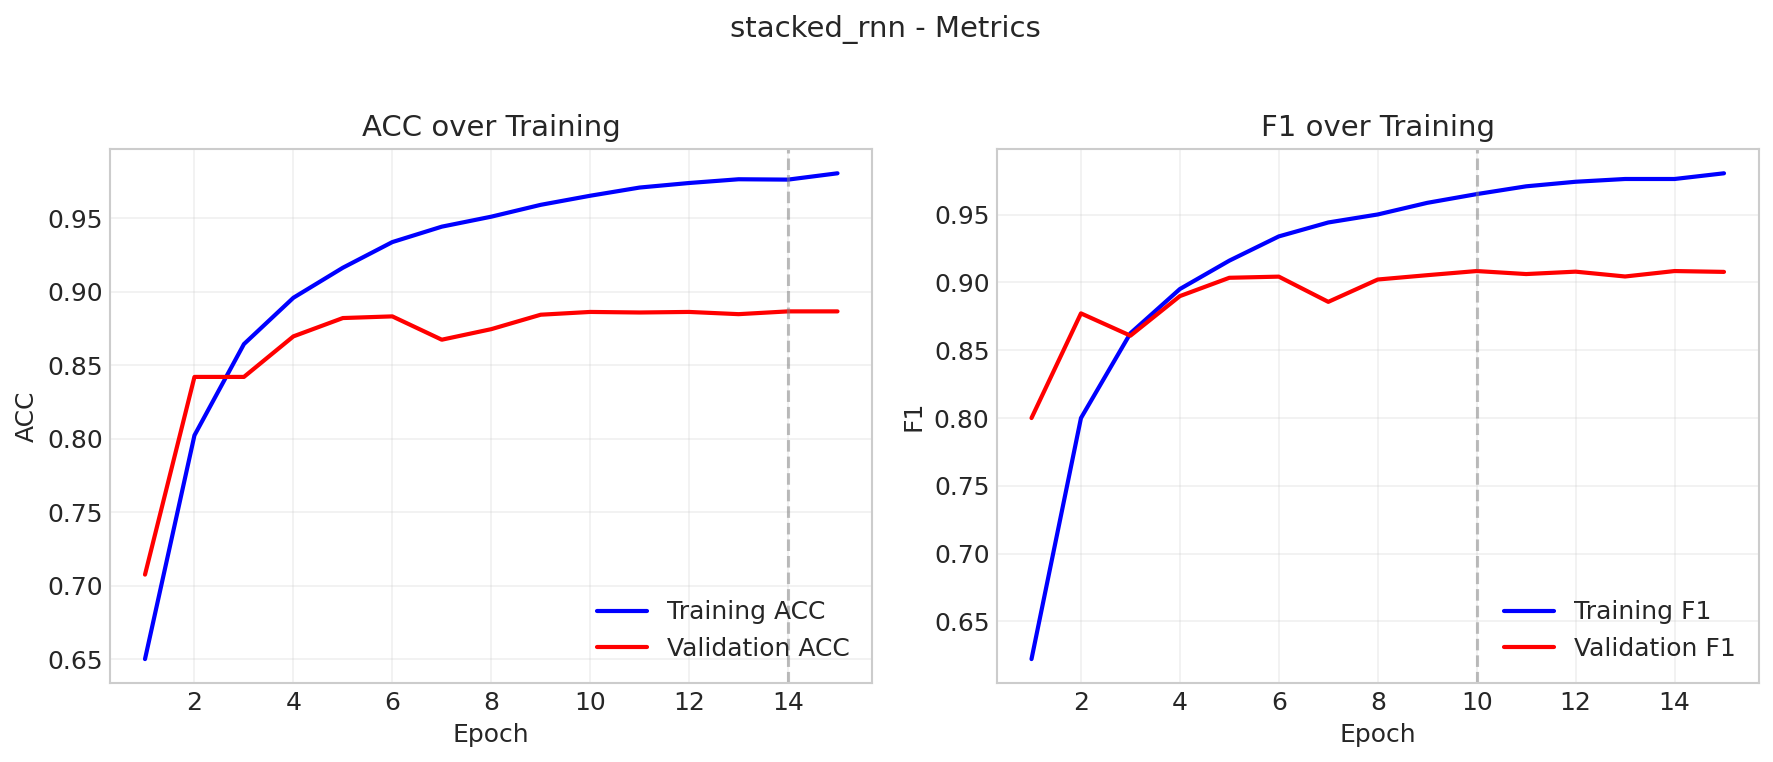


📊 stacked_rnn_bi_noaug
----------------------------------------

confusion_matrix.png:


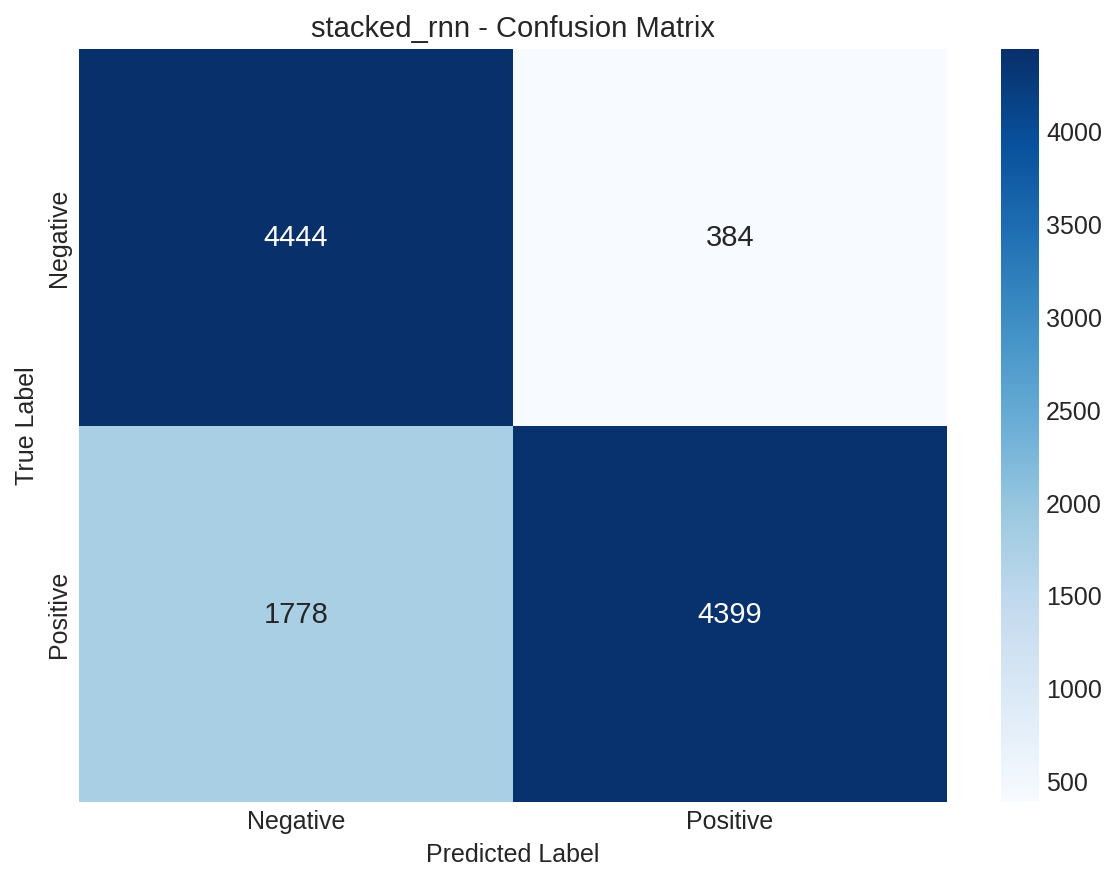


confusion_matrix_normalized.png:


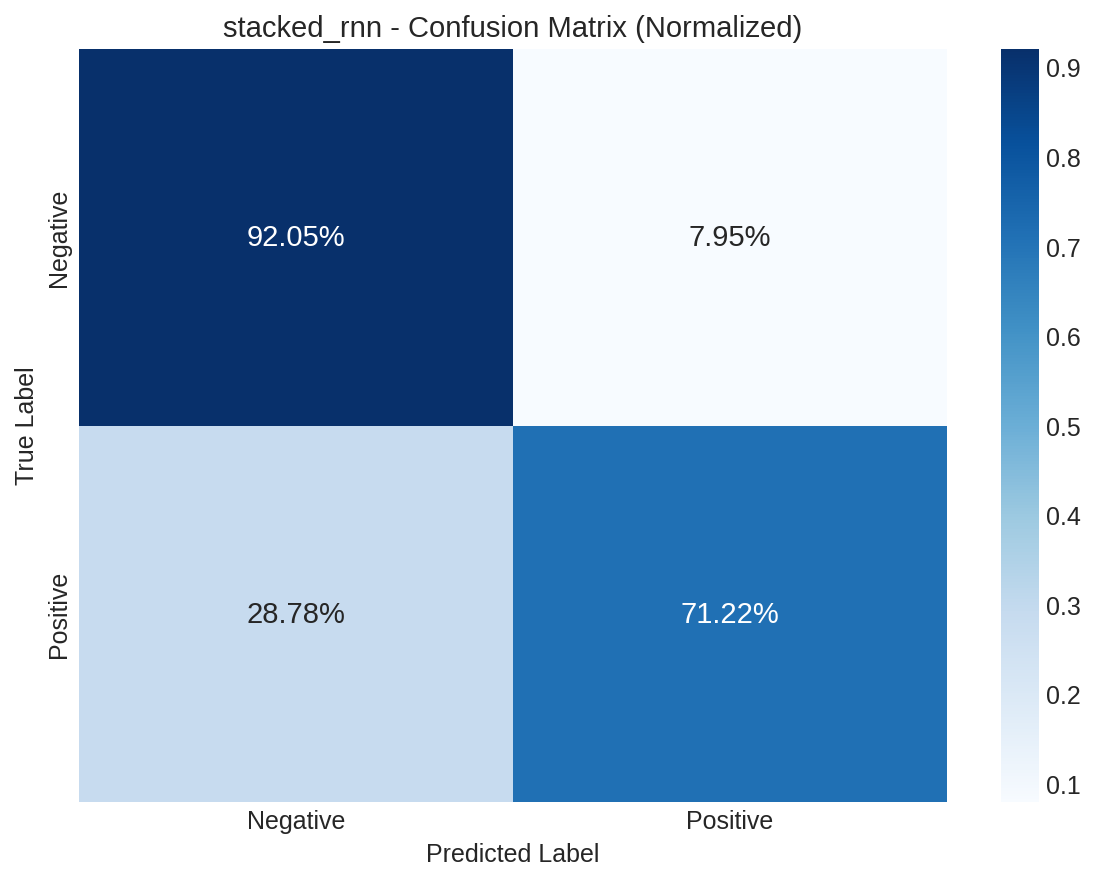


loss_curves.png:


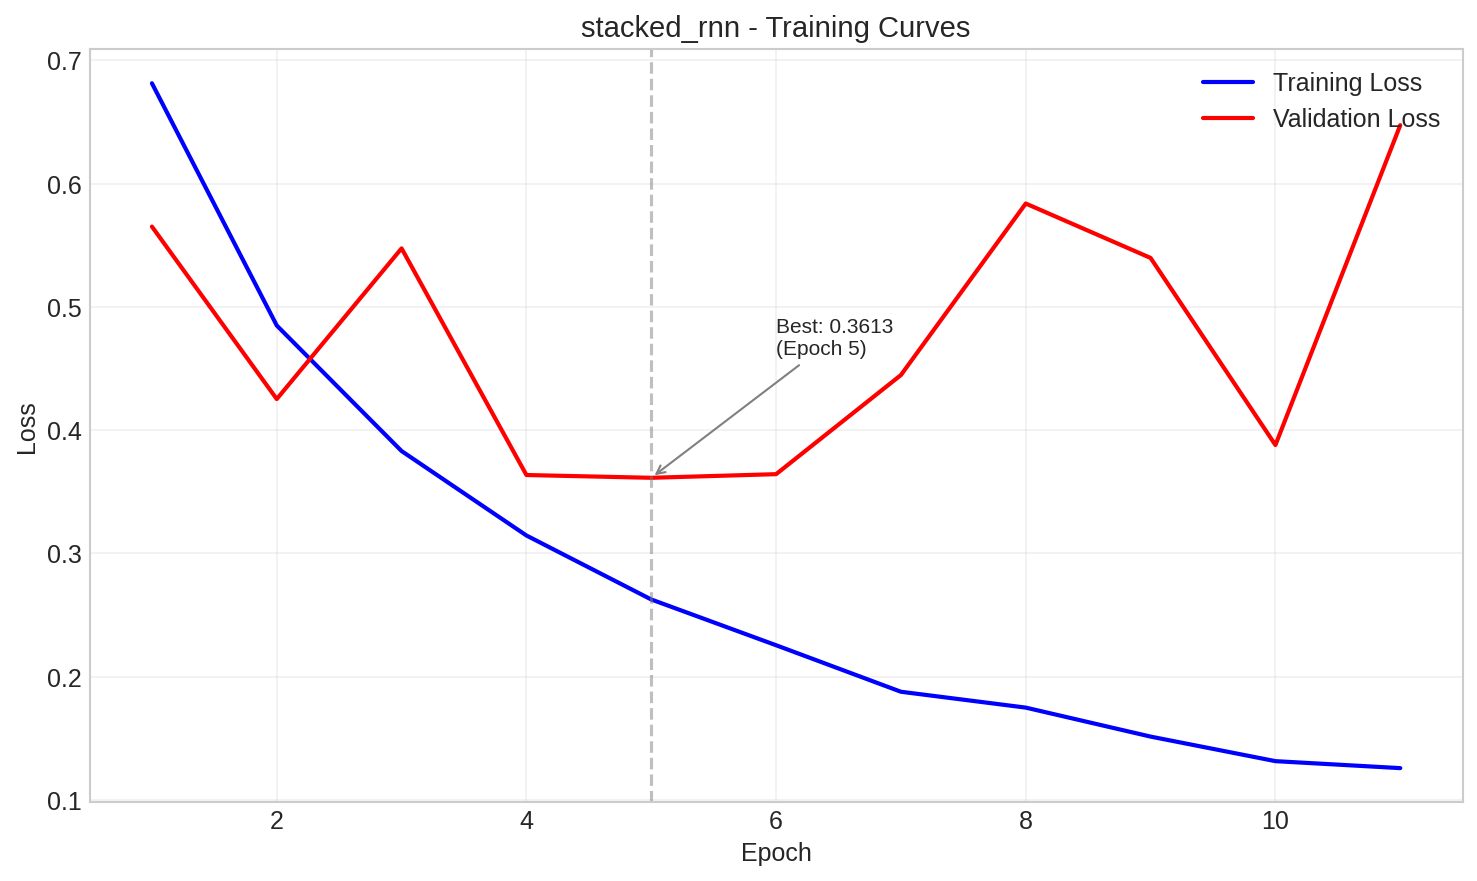


metrics_curves.png:


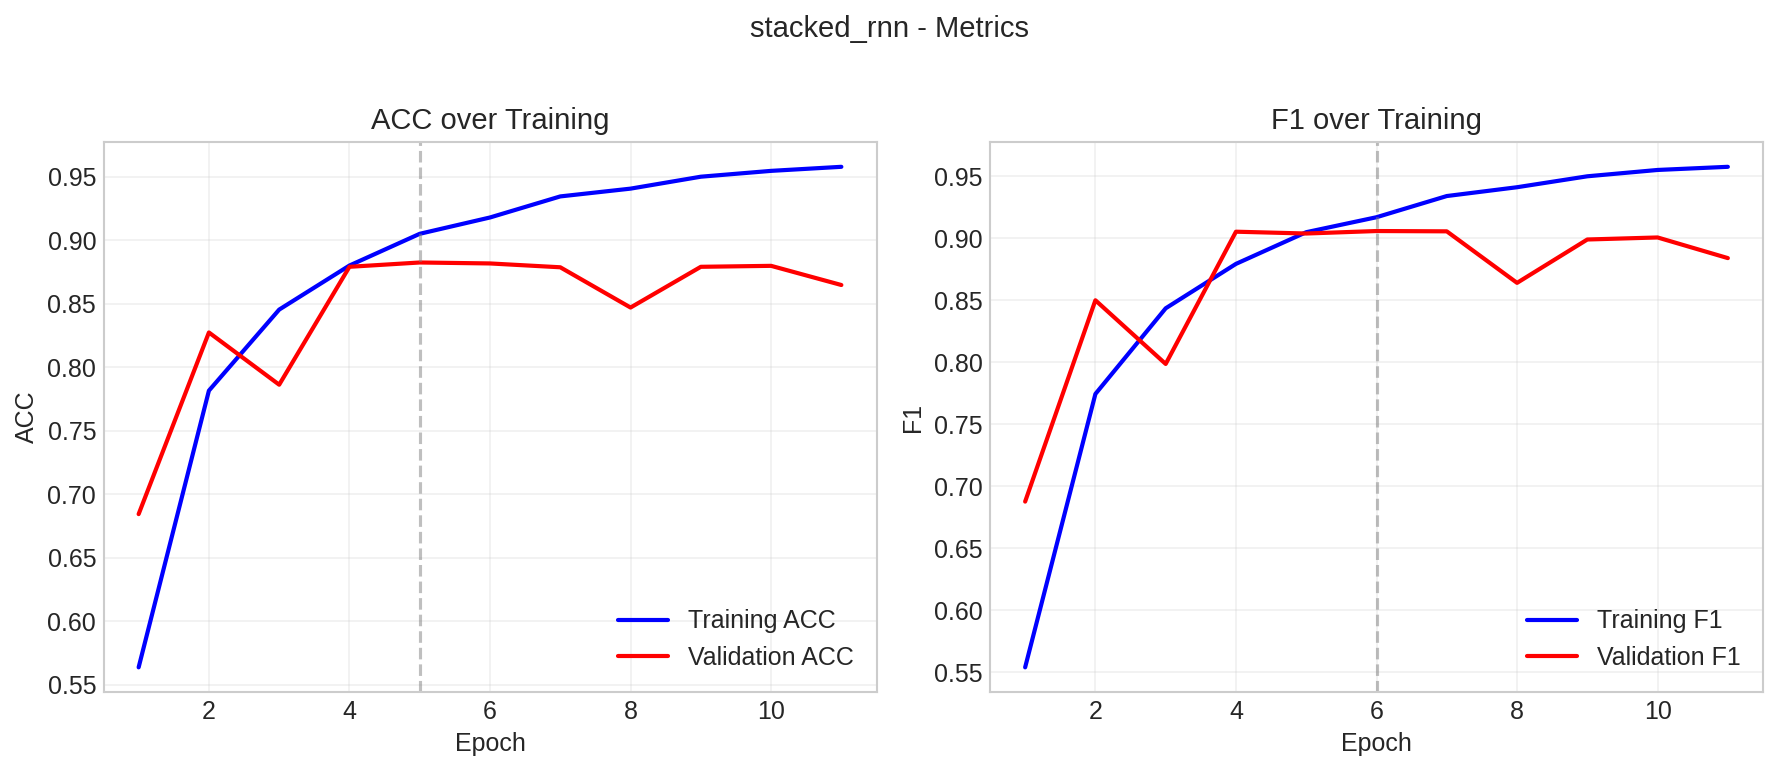

In [90]:
# Display plots from experiments
from IPython.display import Image, display
from pathlib import Path

plots_dir = Path(PLOTS_DIR)
if plots_dir.exists():
    for exp_dir in sorted(plots_dir.iterdir()):
        if exp_dir.is_dir():
            print(f"\n📊 {exp_dir.name}")
            print("-" * 40)
            for plot in sorted(exp_dir.glob('*.png')):
                print(f"\n{plot.name}:")
                display(Image(filename=str(plot), width=600))
else:
    print(f"Plots directory not found: {PLOTS_DIR}")

## 8. Download Results to Local Machine

In [ ]:
# Zip and download all results
!zip -r /content/experiment_results.zip {RESULTS_DIR} {PLOTS_DIR}

from google.colab import files
files.download('/content/experiment_results.zip')
print("✅ Results downloaded!")

# Note: Results are also saved to Google Drive at:
print(f"\n📁 Results persist in Google Drive:")
print(f"   {RESULTS_DIR}")
print(f"   {PLOTS_DIR}")